# SHAP STATE III feature selection #
## Code to select feature with combination of LightGBM and SHAP ##

## Parameters cell ##

Parameters are overiddent by papermill when run inside DVC stages



In [2]:
n_folds = 5 # this sets global setting of which how many bootstraps to use
n_hold_out = 0
repeats = 10
min_genes = 5
max_genes = 12
importance_type = "split"
stage_num = 3
opt_metrics = "huber"

life_history = ["lifespan", "mass_kg", "mtGC", "metabolic_rate", "temperature", "gestation_days"]
trait = "lifespan"
debug_local = True #to use local version

In [3]:
from pathlib import Path
import sys
import inspect

#lgb_params["importance_type"] = importance_type

local = (Path("..") / "yspecies").resolve()
if debug_local and local.exists():
  sys.path.insert(0, Path("..").as_posix())
  #sys.path.insert(0, local.as_posix())
  print("extending pathes with local yspecies")
  print(sys.path)
  %load_ext autoreload
  %autoreload 2

extending pathes with local yspecies
['..', '/data/sources/yspecies/notebooks', '/data/miniconda3/envs/yspecies/lib/python38.zip', '/data/miniconda3/envs/yspecies/lib/python3.8', '/data/miniconda3/envs/yspecies/lib/python3.8/lib-dynload', '', '/data/miniconda3/envs/yspecies/lib/python3.8/site-packages', '/data/miniconda3/envs/yspecies/lib/python3.8/site-packages/IPython/extensions', '/home/anton/.ipython']


In [4]:
from dataclasses import dataclass, replace
import numpy as np
import pandas as pd
from sklearn.pipeline import Pipeline
import seaborn as sns
import matplotlib.pyplot as plt

In [5]:
from typing import *
from yspecies.dataset import *
from yspecies.utils import *
from yspecies.workflow import TupleWith, Repeat, Collect
from yspecies.config import *
from yspecies.preprocess import FeatureSelection, DataExtractor
from yspecies.partition import DataPartitioner, PartitionParameters
from yspecies.models import Metrics

In [6]:
import optuna
from optuna import Study, Trial
from optuna import multi_objective
from optuna.multi_objective import trial
from optuna.multi_objective.study import MultiObjectiveStudy
from yspecies.tuning import MultiObjectiveResults

In [7]:
#settings
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
import pprint
pp = pprint.PrettyPrinter(indent=4)
pd.set_option('display.float_format', lambda x: '%.3f' % x)
np.set_printoptions(suppress=True)

#charts settings
import matplotlib.pyplot as plt
from IPython.display import set_matplotlib_formats
%matplotlib auto
plt.ioff()
set_matplotlib_formats('svg')

Using matplotlib backend: agg


### Loading data ###
Let's load data from species/genes/expressions selected by select_samples.py notebook

In [8]:
from pathlib import Path
locations: Locations = Locations("./") if Path("./data").exists() else Locations("../")
suffix = f"_{stage_num}"
suffix

'_3'

In [9]:
from loguru import logger
logger.add(locations.logs / f"stage{suffix}_shap_selection.log", rotation="12:00")     # New file is created each day at noon

1

In [10]:
stage_folder = locations.interim.dir / f"stage{suffix}" 
stage_folder.mkdir(exist_ok=True)
partitions_folder = stage_folder  / "partitions"
partitions_folder.mkdir(exist_ok=True)

In [11]:
data = ExpressionDataset.from_folder(locations.interim.dir / f"stage_{stage_num-1}" / "input")
data

<table border='2'><caption>input<caption><tr><th>expressions</th><th>genes</th><th>species</th><th>samples</th><th>Genes Metadata</th><th>Species Metadata</th></tr><tr><td>(408, 154)</td><td>(154, 37)</td><td>38</td><td>408</td><td>(154, 2)</td><td>(38, 18)</td></tr></table>

### Loading genes from the ranked selection ###

In [12]:
intersections = locations.output.intersections
ranked = pd.read_csv(intersections / "intersections_ranked.tsv", sep="\t", index_col="reference_gene")
print(ranked.shape)
ranked.head(10)

(152, 23)


symbol   rank  ranks_sum  repeats_rank  shap_rank  \
reference_gene                                                         
ENSG00000188747     NOXA1  1.000     46.000         2.000     12.000   
ENSG00000170835       CEL  2.000     54.000         1.000      7.000   
ENSG00000136436  CALCOCO2  3.000     63.000         7.000     27.000   
ENSG00000198663   C6orf89  4.000     64.000        10.000     35.000   
ENSG00000172531    PPP1CA  5.000     69.000         5.000     42.000   
ENSG00000006282   SPATA20  6.000     75.000         8.000     25.000   
ENSG00000142002      DPP9  7.000     76.000         4.000     26.000   
ENSG00000129187      DCTD  8.000     78.000         8.000     32.000   
ENSG00000165501      LRR1  9.000     82.000         2.000     19.000   
ENSG00000120675   DNAJC15 10.000     83.000         8.000     52.000   

                 kendall_tau_rank  frequency_rank  tissue_linear_rank  \
reference_gene                                                          
ENSG00000188747            16.000           1.000              10.000   
ENSG00000170835             7.000           6.000              33.000   
ENSG00000136436             5.000           7.000              18.000   
ENSG00000198663             1.000           2.000              12.000   
ENSG00000172531             3.000          20.000              13.000   
ENSG00000006282            31.000          16.000               5.000   
ENSG00000142002            11.000          11.000              29.000   
ENSG00000129187            26.000           8.000               6.000   
ENSG00000165501            14.000           9.000              41.000   
ENSG00000120675             9.000          20.000               8.000   

                 genage_rank  repeats_all  repeats  mean_abs_shap  \
reference_gene                                                      
ENSG00000188747        6.000       19.000   10.000          0.507   
ENSG00000170835        6.000       20.000   10.000          0.849   
ENSG00000136436        6.000       14.000   10.000          0.307   
ENSG00000198663        6.000       10.000   10.000          0.226   
ENSG00000172531        6.000       16.000   10.000          0.165   
ENSG00000006282        6.000       13.000   10.000          0.311   
ENSG00000142002        6.000       17.000   10.000          0.309   
ENSG00000129187        6.000       13.000   10.000          0.253   
ENSG00000165501        6.000       19.000   10.000          0.366   
ENSG00000120675        6.000       13.000   10.000          0.128   

                 mean_kendall_tau  frequency  max_linear_r2  genage_count  \
reference_gene                                                              
ENSG00000188747             0.697      1.000          0.627         0.000   
ENSG00000170835             0.746      0.600          0.481         0.000   
ENSG00000136436             0.763      0.420          0.559         0.000   
ENSG00000198663            -0.788      0.940          0.616         0.000   
ENSG00000172531            -0.782      0.000          0.610         0.000   
ENSG00000006282             0.649      0.080          0.675         0.000   
ENSG00000142002            -0.717      0.300          0.507         0.000   
ENSG00000129187             0.674      0.400          0.666         0.000   
ENSG00000165501             0.715      0.340          0.459         0.000   
ENSG00000120675            -0.735      0.000          0.646         0.000   

                   direction  repeats_lifespan_stage_1  \
reference_gene                                           
ENSG00000188747   strong pro                     9.000   
ENSG00000170835   strong pro                    10.000   
ENSG00000136436   strong pro                     4.000   
ENSG00000198663  strong anti                     0.000   
ENSG00000172531  strong anti                     6.000   
ENSG00000006282   strong pro                     3.000   
ENSG00000142002  strong anti                     7.000   
E

In [13]:
def data_genes(genes: List[str]):
    return data.by_genes.collect(lambda gs: gs.loc[genes])

def data_head(num: int):
    return data_genes(ranked.head(num).index.to_list())

## Setting up features to select ##

In [14]:
default_selection = FeatureSelection(
    samples = ["tissue","species"], #samples metadata to include
    species =  [], #species metadata other then Y label to include
    exclude_from_training = ["species"],  #exclude some fields from LightGBM training
    to_predict = "lifespan", #column to predict
    categorical = ["tissue"],
    select_by = "shap",
    importance_type =  importance_type,
    feature_perturbation = "tree_path_dependent"
)
no_genes_selection =  replace(default_selection, categorical = [], samples = ["species"])
default_selection

FeatureSelection(samples=['tissue', 'species'], species=[], genes=None, to_predict='lifespan', categorical=['tissue'], exclude_from_training=['species'], genes_meta=None, select_by='shap', importance_type='split', feature_perturbation='tree_path_dependent', not_validated_species=[])

In [15]:
def selection(num: int, trait: str = "lifespan", criteria = default_selection):
    d = data_head(num)
    return (d,  replace(criteria, to_predict = trait, not_validated_species = d.min_max_trait(trait) ))
selection(10)[1]

FeatureSelection(samples=['tissue', 'species'], species=[], genes=None, to_predict='lifespan', categorical=['tissue'], exclude_from_training=['species'], genes_meta=None, select_by='shap', importance_type='split', feature_perturbation='tree_path_dependent', not_validated_species=['Mus_caroli', 'Homo_sapiens'])

### Setting up pipelines ###

In [16]:
from yspecies.helpers import PipelineFactory
factory = PipelineFactory(locations, repeats, n_folds, n_hold_out)

In [18]:
def opt_by_trait(trait: str, sufix: str = ""):
    return locations.interim.optimization / f"{trait}{sufix}.sqlite"

In [19]:
lifespan_pipeline = factory.make_repeated_shap_pipeline(study_path = opt_by_trait(trait, f"_{stage_num}"), study_name=f"{trait}_r2_huber_kendall", opt_metrics = opt_metrics)
#pipelines = {trait:factory.make_shap_pipeline(trait) for trait in life_history}
lifespan_pipeline

create_study is experimental (supported from v1.4.0). The interface can change in the future.
NSGAIIMultiObjectiveSampler is experimental (supported from v1.5.0). The interface can change in the future.
RandomMultiObjectiveSampler is experimental (supported from v1.4.0). The interface can change in the future.
[I 2020-11-14 18:24:09,130] Using an existing study with name 'lifespan_r2_huber_kendall' instead of creating a new one.


loading (if exists) study from sqlite:////data/sources/yspecies/notebooks/../data/interim/optimization/lifespan_3.sqlite


MultiObjectiveStudy is experimental (supported from v1.4.0). The interface can change in the future.
FrozenMultiObjectiveTrial is experimental (supported from v1.4.0). The interface can change in the future.


Pipeline(steps=[('extractor', DataExtractor()),
                ('prepare_for_partitioning',
                 TupleWith(parameters=PartitionParameters(n_folds=5, n_hold_out=0, species_in_validation=2, seed=42), map_left=<function TupleWith.<lambda>.<locals>.<lambda> at 0x7f5ceac82940>, map_right=<function TupleWith.<lambda>.<locals>.<lambda> at 0x7f5ceac82a60>)),
                ('repeated_partition_shap',
                 Repea...
                 CrossValidator(early_stopping_rounds=10, models=[], evals=[])),
                ('shap_computation', ShapSelector())]), repeats=10, map=<function PipelineFactory.make_repeated_shap_pipeline.<locals>.<lambda> at 0x7f5cead18310>)),
                ('summarize',
                 Collect(fold=<function PipelineFactory.make_repeated_shap_pipeline.<locals>.<lambda> at 0x7f5ceac484c0>, filter=<function Collect.<lambda>.<locals>.<lambda> at 0x7f5ceac48dc0>))])

# Run third stage #

In [ ]:
six = lifespan_pipeline.fit_transform(selection(6,"lifespan", no_genes_selection))
six

In [ ]:
print(six.average_metrics)

In [ ]:
print("???")

In [ ]:
lifespan_results = [lifespan_pipeline.fit_transform(selection(i,"lifespan", no_genes_selection)) for i in range(min_genes, max_genes)] #all genes
len(lifespan_results)

2020-11-14 04:40:37.596 | INFO     | yspecies.selection:fit:157 - ===== fitting models with seed 0 =====
2020-11-14 04:40:37.613 | INFO     | yspecies.selection:fit:158 - PARAMETERS:
{'bagging_fraction': 0.5980047542116902, 'boosting_type': 'dart', 'drop_rate': 0.1812277548899702, 'feature_fraction': 0.7714086403267406, 'lambda_l1': 0.9663167136186577, 'lambda_l2': 0.8714460518112714, 'learning_rate': 0.08554380802136563, 'max_depth': 6, 'max_leaves': 23, 'min_data_in_leaf': 5, 'objective': 'regression', 'metrics': ['l1', 'l2', 'huber'], 'verbose': -1, 'early_stopping_round': 10}
2020-11-14 04:40:37.618 | INFO     | yspecies.selection:fit:161 - SEED: 0 | FOLD: 0 | VALIDATION_SPECIES: ['Gorilla_gorilla', 'Pan_paniscus']
/data/miniconda3/envs/yspecies/lib/python3.8/site-packages/lightgbm/engine.py:156: UserWarning:

Found `early_stopping_round` in params. Will use it instead of argument

/data/miniconda3/envs/yspecies/lib/python3.8/site-packages/lightgbm/callback.py:186: UserWarning:

Ea

[250]	valid_0's l1: 8.32898	valid_0's l2: 250.893	valid_0's huber: 7.16211


2020-11-14 04:46:54.330 | INFO     | yspecies.selection:fit:161 - SEED: 0 | FOLD: 2 | VALIDATION_SPECIES: ['Bos_taurus', 'Otolemur_garnettii']


[250]	valid_0's l1: 8.86024	valid_0's l2: 434.986	valid_0's huber: 7.64404


2020-11-14 04:50:08.756 | INFO     | yspecies.selection:fit:161 - SEED: 0 | FOLD: 3 | VALIDATION_SPECIES: ['Macaca_nemestrina', 'Microcebus_murinus']


[250]	valid_0's l1: 8.77209	valid_0's l2: 411.744	valid_0's huber: 7.59108


2020-11-14 04:53:15.869 | INFO     | yspecies.selection:fit:161 - SEED: 0 | FOLD: 4 | VALIDATION_SPECIES: ['Felis_catus', 'Pan_troglodytes']


[250]	valid_0's l1: 6.91772	valid_0's l2: 201.151	valid_0's huber: 5.89092
[250]	valid_0's l1: 8.26535	valid_0's l2: 257.406	valid_0's huber: 7.13106


2020-11-14 04:56:26.975 | INFO     | yspecies.explanations:transform:646 - Metrics: 
Metrics(R2=0.5485184903860146, MAE=8.228875348503745, MSE=311.2360672635051, huber=7.083842612266141)
2020-11-14 04:56:26.982 | INFO     | yspecies.selection:fit:157 - ===== fitting models with seed 1 =====
2020-11-14 04:56:26.983 | INFO     | yspecies.selection:fit:158 - PARAMETERS:
{'bagging_fraction': 0.5980047542116902, 'boosting_type': 'dart', 'drop_rate': 0.1812277548899702, 'feature_fraction': 0.7714086403267406, 'lambda_l1': 0.9663167136186577, 'lambda_l2': 0.8714460518112714, 'learning_rate': 0.08554380802136563, 'max_depth': 6, 'max_leaves': 23, 'min_data_in_leaf': 5, 'objective': 'regression', 'metrics': ['l1', 'l2', 'huber'], 'verbose': -1, 'early_stopping_round': 10, 'seed': 0}
2020-11-14 04:56:26.987 | INFO     | yspecies.selection:fit:161 - SEED: 1 | FOLD: 0 | VALIDATION_SPECIES: ['Felis_catus', 'Ursus_americanus']
/data/miniconda3/envs/yspecies/lib/python3.8/site-packages/lightgbm/engin

[250]	valid_0's l1: 7.78015	valid_0's l2: 222.034	valid_0's huber: 6.66931


2020-11-14 05:02:39.223 | INFO     | yspecies.selection:fit:161 - SEED: 1 | FOLD: 2 | VALIDATION_SPECIES: ['Macaca_fascicularis', 'Rhinopithecus_bieti']


[250]	valid_0's l1: 8.56779	valid_0's l2: 394.888	valid_0's huber: 7.38554


2020-11-14 05:05:53.824 | INFO     | yspecies.selection:fit:161 - SEED: 1 | FOLD: 3 | VALIDATION_SPECIES: ['Gorilla_gorilla', 'Ovis_aries']


[250]	valid_0's l1: 9.19932	valid_0's l2: 404.398	valid_0's huber: 7.93257


2020-11-14 05:09:02.107 | INFO     | yspecies.selection:fit:161 - SEED: 1 | FOLD: 4 | VALIDATION_SPECIES: ['Pan_troglodytes', 'Ailuropoda_melanoleuca']


[250]	valid_0's l1: 7.10254	valid_0's l2: 181.181	valid_0's huber: 6.05847
[250]	valid_0's l1: 7.27257	valid_0's l2: 254.599	valid_0's huber: 6.24901


2020-11-14 05:12:20.025 | INFO     | yspecies.explanations:transform:646 - Metrics: 
Metrics(R2=0.5948950985267188, MAE=7.9844726420042305, MSE=291.4199176731986, huber=6.858979662669336)
2020-11-14 05:12:20.034 | INFO     | yspecies.selection:fit:157 - ===== fitting models with seed 2 =====
2020-11-14 05:12:20.035 | INFO     | yspecies.selection:fit:158 - PARAMETERS:
{'bagging_fraction': 0.5980047542116902, 'boosting_type': 'dart', 'drop_rate': 0.1812277548899702, 'feature_fraction': 0.7714086403267406, 'lambda_l1': 0.9663167136186577, 'lambda_l2': 0.8714460518112714, 'learning_rate': 0.08554380802136563, 'max_depth': 6, 'max_leaves': 23, 'min_data_in_leaf': 5, 'objective': 'regression', 'metrics': ['l1', 'l2', 'huber'], 'verbose': -1, 'early_stopping_round': 10, 'seed': 1}
2020-11-14 05:12:20.039 | INFO     | yspecies.selection:fit:161 - SEED: 2 | FOLD: 0 | VALIDATION_SPECIES: ['Rhinopithecus_bieti', 'Ursus_americanus']
/data/miniconda3/envs/yspecies/lib/python3.8/site-packages/light

[250]	valid_0's l1: 10.7357	valid_0's l2: 382.036	valid_0's huber: 9.31779


2020-11-14 05:18:55.795 | INFO     | yspecies.selection:fit:161 - SEED: 2 | FOLD: 2 | VALIDATION_SPECIES: ['Vombatus_ursinus', 'Ailuropoda_melanoleuca']


[250]	valid_0's l1: 10.922	valid_0's l2: 515.583	valid_0's huber: 9.46298


2020-11-14 05:22:13.237 | INFO     | yspecies.selection:fit:161 - SEED: 2 | FOLD: 3 | VALIDATION_SPECIES: ['Rattus_norvegicus', 'Monodelphis_domestica']


[250]	valid_0's l1: 10.5676	valid_0's l2: 565.928	valid_0's huber: 9.16632


2020-11-14 05:25:25.085 | INFO     | yspecies.selection:fit:161 - SEED: 2 | FOLD: 4 | VALIDATION_SPECIES: ['Bos_taurus', 'Tupaia_belangeri']


[250]	valid_0's l1: 8.84673	valid_0's l2: 200.127	valid_0's huber: 7.60506
[250]	valid_0's l1: 9.37118	valid_0's l2: 315.717	valid_0's huber: 8.07228


2020-11-14 05:28:43.619 | INFO     | yspecies.explanations:transform:646 - Metrics: 
Metrics(R2=0.46567253401845166, MAE=10.088653378369862, MSE=395.878075235945, huber=8.724884639375842)
2020-11-14 05:28:43.626 | INFO     | yspecies.selection:fit:157 - ===== fitting models with seed 3 =====
2020-11-14 05:28:43.629 | INFO     | yspecies.selection:fit:158 - PARAMETERS:
{'bagging_fraction': 0.5980047542116902, 'boosting_type': 'dart', 'drop_rate': 0.1812277548899702, 'feature_fraction': 0.7714086403267406, 'lambda_l1': 0.9663167136186577, 'lambda_l2': 0.8714460518112714, 'learning_rate': 0.08554380802136563, 'max_depth': 6, 'max_leaves': 23, 'min_data_in_leaf': 5, 'objective': 'regression', 'metrics': ['l1', 'l2', 'huber'], 'verbose': -1, 'early_stopping_round': 10, 'seed': 2}
2020-11-14 05:28:43.634 | INFO     | yspecies.selection:fit:161 - SEED: 3 | FOLD: 0 | VALIDATION_SPECIES: ['Microcebus_murinus', 'Pan_paniscus']
/data/miniconda3/envs/yspecies/lib/python3.8/site-packages/lightgbm/e

[250]	valid_0's l1: 10.1066	valid_0's l2: 347.382	valid_0's huber: 8.74742


2020-11-14 05:35:03.981 | INFO     | yspecies.selection:fit:161 - SEED: 3 | FOLD: 2 | VALIDATION_SPECIES: ['Bos_taurus', 'Capra_hircus']


[250]	valid_0's l1: 10.3889	valid_0's l2: 420.923	valid_0's huber: 9.00518


2020-11-14 05:38:10.967 | INFO     | yspecies.selection:fit:161 - SEED: 3 | FOLD: 3 | VALIDATION_SPECIES: ['Rhinolophus_ferrumequinum', 'Mus_musculus']


[250]	valid_0's l1: 10.0454	valid_0's l2: 478.477	valid_0's huber: 8.71847


2020-11-14 05:41:23.722 | INFO     | yspecies.selection:fit:161 - SEED: 3 | FOLD: 4 | VALIDATION_SPECIES: ['Suricata_suricatta', 'Meriones_unguiculatus']


[250]	valid_0's l1: 4.37218	valid_0's l2: 139	valid_0's huber: 3.61517
[250]	valid_0's l1: 6.64247	valid_0's l2: 242.542	valid_0's huber: 5.66177


2020-11-14 05:44:34.563 | INFO     | yspecies.explanations:transform:646 - Metrics: 
Metrics(R2=0.5480107273556201, MAE=8.311109114486936, MSE=325.66462801505185, huber=7.149601996648163)
2020-11-14 05:44:34.570 | INFO     | yspecies.selection:fit:157 - ===== fitting models with seed 4 =====
2020-11-14 05:44:34.571 | INFO     | yspecies.selection:fit:158 - PARAMETERS:
{'bagging_fraction': 0.5980047542116902, 'boosting_type': 'dart', 'drop_rate': 0.1812277548899702, 'feature_fraction': 0.7714086403267406, 'lambda_l1': 0.9663167136186577, 'lambda_l2': 0.8714460518112714, 'learning_rate': 0.08554380802136563, 'max_depth': 6, 'max_leaves': 23, 'min_data_in_leaf': 5, 'objective': 'regression', 'metrics': ['l1', 'l2', 'huber'], 'verbose': -1, 'early_stopping_round': 10, 'seed': 3}
2020-11-14 05:44:34.575 | INFO     | yspecies.selection:fit:161 - SEED: 4 | FOLD: 0 | VALIDATION_SPECIES: ['Macaca_fascicularis', 'Pan_troglodytes']
/data/miniconda3/envs/yspecies/lib/python3.8/site-packages/lightg

[250]	valid_0's l1: 10.6061	valid_0's l2: 428.221	valid_0's huber: 9.21184


2020-11-14 05:50:55.700 | INFO     | yspecies.selection:fit:161 - SEED: 4 | FOLD: 2 | VALIDATION_SPECIES: ['Heterocephalus_glaber', 'Cavia_aperea']


[250]	valid_0's l1: 9.51405	valid_0's l2: 464.872	valid_0's huber: 8.23206


2020-11-14 05:54:11.468 | INFO     | yspecies.selection:fit:161 - SEED: 4 | FOLD: 3 | VALIDATION_SPECIES: ['Pan_paniscus', 'Gorilla_gorilla']


[250]	valid_0's l1: 8.50383	valid_0's l2: 403.169	valid_0's huber: 7.33931


2020-11-14 05:57:27.461 | INFO     | yspecies.selection:fit:161 - SEED: 4 | FOLD: 4 | VALIDATION_SPECIES: ['Bos_taurus', 'Equus_caballus']


[250]	valid_0's l1: 8.69927	valid_0's l2: 279.485	valid_0's huber: 7.49339
[250]	valid_0's l1: 7.98448	valid_0's l2: 312.122	valid_0's huber: 6.88617


2020-11-14 06:00:44.690 | INFO     | yspecies.explanations:transform:646 - Metrics: 
Metrics(R2=0.45574983321527335, MAE=9.061536914892626, MSE=377.5738317478058, huber=7.832552713295316)
2020-11-14 06:00:44.697 | INFO     | yspecies.selection:fit:157 - ===== fitting models with seed 5 =====
2020-11-14 06:00:44.698 | INFO     | yspecies.selection:fit:158 - PARAMETERS:
{'bagging_fraction': 0.5980047542116902, 'boosting_type': 'dart', 'drop_rate': 0.1812277548899702, 'feature_fraction': 0.7714086403267406, 'lambda_l1': 0.9663167136186577, 'lambda_l2': 0.8714460518112714, 'learning_rate': 0.08554380802136563, 'max_depth': 6, 'max_leaves': 23, 'min_data_in_leaf': 5, 'objective': 'regression', 'metrics': ['l1', 'l2', 'huber'], 'verbose': -1, 'early_stopping_round': 10, 'seed': 4}
2020-11-14 06:00:44.702 | INFO     | yspecies.selection:fit:161 - SEED: 5 | FOLD: 0 | VALIDATION_SPECIES: ['Mus_spicilegus', 'Canis_lupus_familiaris']
/data/miniconda3/envs/yspecies/lib/python3.8/site-packages/ligh

[250]	valid_0's l1: 10.5087	valid_0's l2: 452.186	valid_0's huber: 9.13814


2020-11-14 06:06:56.322 | INFO     | yspecies.selection:fit:161 - SEED: 5 | FOLD: 2 | VALIDATION_SPECIES: ['Ursus_americanus', 'Oryctolagus_cuniculus']


[250]	valid_0's l1: 8.52776	valid_0's l2: 338.94	valid_0's huber: 7.34012


2020-11-14 06:10:07.824 | INFO     | yspecies.selection:fit:161 - SEED: 5 | FOLD: 3 | VALIDATION_SPECIES: ['Cavia_aperea', 'Ailuropoda_melanoleuca']


[250]	valid_0's l1: 8.53083	valid_0's l2: 409.223	valid_0's huber: 7.3594


2020-11-14 06:13:15.148 | INFO     | yspecies.selection:fit:161 - SEED: 5 | FOLD: 4 | VALIDATION_SPECIES: ['Felis_catus', 'Rhinopithecus_bieti']


[250]	valid_0's l1: 6.18465	valid_0's l2: 188.268	valid_0's huber: 5.24554
[250]	valid_0's l1: 8.14727	valid_0's l2: 218.758	valid_0's huber: 7.0015


2020-11-14 06:16:26.252 | INFO     | yspecies.explanations:transform:646 - Metrics: 
Metrics(R2=0.5593671318590392, MAE=8.379834835867872, MSE=321.4749992333836, huber=7.216939137865677)
2020-11-14 06:16:26.258 | INFO     | yspecies.selection:fit:157 - ===== fitting models with seed 6 =====
2020-11-14 06:16:26.259 | INFO     | yspecies.selection:fit:158 - PARAMETERS:
{'bagging_fraction': 0.5980047542116902, 'boosting_type': 'dart', 'drop_rate': 0.1812277548899702, 'feature_fraction': 0.7714086403267406, 'lambda_l1': 0.9663167136186577, 'lambda_l2': 0.8714460518112714, 'learning_rate': 0.08554380802136563, 'max_depth': 6, 'max_leaves': 23, 'min_data_in_leaf': 5, 'objective': 'regression', 'metrics': ['l1', 'l2', 'huber'], 'verbose': -1, 'early_stopping_round': 10, 'seed': 5}
2020-11-14 06:16:26.263 | INFO     | yspecies.selection:fit:161 - SEED: 6 | FOLD: 0 | VALIDATION_SPECIES: ['Rhinolophus_ferrumequinum', 'Heterocephalus_glaber']
/data/miniconda3/envs/yspecies/lib/python3.8/site-pack

[250]	valid_0's l1: 8.26739	valid_0's l2: 267.41	valid_0's huber: 7.11528


2020-11-14 06:20:00.818 | INFO     | yspecies.selection:fit:161 - SEED: 6 | FOLD: 2 | VALIDATION_SPECIES: ['Rhinopithecus_bieti', 'Ovis_aries']


[250]	valid_0's l1: 9.00525	valid_0's l2: 437.862	valid_0's huber: 7.77475


2020-11-14 06:23:10.329 | INFO     | yspecies.selection:fit:161 - SEED: 6 | FOLD: 3 | VALIDATION_SPECIES: ['Cavia_porcellus', 'Pan_troglodytes']


[250]	valid_0's l1: 8.50215	valid_0's l2: 390.392	valid_0's huber: 7.31374


2020-11-14 06:26:18.109 | INFO     | yspecies.selection:fit:161 - SEED: 6 | FOLD: 4 | VALIDATION_SPECIES: ['Vombatus_ursinus', 'Sus_scrofa']


[250]	valid_0's l1: 6.55837	valid_0's l2: 163.154	valid_0's huber: 5.56273
[250]	valid_0's l1: 8.76438	valid_0's l2: 298.76	valid_0's huber: 7.56589


2020-11-14 06:29:30.615 | INFO     | yspecies.explanations:transform:646 - Metrics: 
Metrics(R2=0.5724797705032583, MAE=8.219507979813134, MSE=311.5157166201378, huber=7.066478503555173)
2020-11-14 06:29:30.622 | INFO     | yspecies.selection:fit:157 - ===== fitting models with seed 7 =====
2020-11-14 06:29:30.623 | INFO     | yspecies.selection:fit:158 - PARAMETERS:
{'bagging_fraction': 0.5980047542116902, 'boosting_type': 'dart', 'drop_rate': 0.1812277548899702, 'feature_fraction': 0.7714086403267406, 'lambda_l1': 0.9663167136186577, 'lambda_l2': 0.8714460518112714, 'learning_rate': 0.08554380802136563, 'max_depth': 6, 'max_leaves': 23, 'min_data_in_leaf': 5, 'objective': 'regression', 'metrics': ['l1', 'l2', 'huber'], 'verbose': -1, 'early_stopping_round': 10, 'seed': 6}
2020-11-14 06:29:30.628 | INFO     | yspecies.selection:fit:161 - SEED: 7 | FOLD: 0 | VALIDATION_SPECIES: ['Macaca_mulatta', 'Cavia_porcellus']
/data/miniconda3/envs/yspecies/lib/python3.8/site-packages/lightgbm/eng

[250]	valid_0's l1: 8.9412	valid_0's l2: 271.502	valid_0's huber: 7.70251


2020-11-14 06:35:44.550 | INFO     | yspecies.selection:fit:161 - SEED: 7 | FOLD: 2 | VALIDATION_SPECIES: ['Otolemur_garnettii', 'Ictidomys_tridecemlineatus']


[250]	valid_0's l1: 8.77463	valid_0's l2: 384.113	valid_0's huber: 7.56231


2020-11-14 06:38:50.793 | INFO     | yspecies.selection:fit:161 - SEED: 7 | FOLD: 3 | VALIDATION_SPECIES: ['Canis_lupus_familiaris', 'Ursus_americanus']


[250]	valid_0's l1: 8.41822	valid_0's l2: 393.019	valid_0's huber: 7.25802


2020-11-14 06:41:54.391 | INFO     | yspecies.selection:fit:161 - SEED: 7 | FOLD: 4 | VALIDATION_SPECIES: ['Tupaia_belangeri', 'Ailuropoda_melanoleuca']


[250]	valid_0's l1: 6.98316	valid_0's l2: 194.744	valid_0's huber: 5.94291
[250]	valid_0's l1: 7.7866	valid_0's l2: 266.607	valid_0's huber: 6.68973


2020-11-14 06:45:05.835 | INFO     | yspecies.explanations:transform:646 - Metrics: 
Metrics(R2=0.5807657118924969, MAE=8.180762482157302, MSE=301.9969465243802, huber=7.0310968790478245)
2020-11-14 06:45:05.841 | INFO     | yspecies.selection:fit:157 - ===== fitting models with seed 8 =====
2020-11-14 06:45:05.843 | INFO     | yspecies.selection:fit:158 - PARAMETERS:
{'bagging_fraction': 0.5980047542116902, 'boosting_type': 'dart', 'drop_rate': 0.1812277548899702, 'feature_fraction': 0.7714086403267406, 'lambda_l1': 0.9663167136186577, 'lambda_l2': 0.8714460518112714, 'learning_rate': 0.08554380802136563, 'max_depth': 6, 'max_leaves': 23, 'min_data_in_leaf': 5, 'objective': 'regression', 'metrics': ['l1', 'l2', 'huber'], 'verbose': -1, 'early_stopping_round': 10, 'seed': 7}
2020-11-14 06:45:05.847 | INFO     | yspecies.selection:fit:161 - SEED: 8 | FOLD: 0 | VALIDATION_SPECIES: ['Pan_paniscus', 'Suricata_suricatta']
/data/miniconda3/envs/yspecies/lib/python3.8/site-packages/lightgbm/e

[250]	valid_0's l1: 8.4526	valid_0's l2: 268.965	valid_0's huber: 7.28013


2020-11-14 06:51:52.016 | INFO     | yspecies.selection:fit:161 - SEED: 8 | FOLD: 2 | VALIDATION_SPECIES: ['Ursus_americanus', 'Capra_hircus']


[250]	valid_0's l1: 8.02144	valid_0's l2: 369.969	valid_0's huber: 6.87458


2020-11-14 06:55:13.532 | INFO     | yspecies.selection:fit:161 - SEED: 8 | FOLD: 3 | VALIDATION_SPECIES: ['Bos_taurus', 'Rhinolophus_ferrumequinum']


[250]	valid_0's l1: 8.09088	valid_0's l2: 406.502	valid_0's huber: 6.94742


2020-11-14 06:58:33.572 | INFO     | yspecies.selection:fit:161 - SEED: 8 | FOLD: 4 | VALIDATION_SPECIES: ['Oryctolagus_cuniculus', 'Sus_scrofa']


[250]	valid_0's l1: 6.50525	valid_0's l2: 197.891	valid_0's huber: 5.51545
[250]	valid_0's l1: 7.32877	valid_0's l2: 242.59	valid_0's huber: 6.25407


2020-11-14 07:02:01.396 | INFO     | yspecies.explanations:transform:646 - Metrics: 
Metrics(R2=0.582468407784701, MAE=7.679787645434734, MSE=297.1832949490523, huber=6.574328637497835)
2020-11-14 07:02:01.403 | INFO     | yspecies.selection:fit:157 - ===== fitting models with seed 9 =====
2020-11-14 07:02:01.404 | INFO     | yspecies.selection:fit:158 - PARAMETERS:
{'bagging_fraction': 0.5980047542116902, 'boosting_type': 'dart', 'drop_rate': 0.1812277548899702, 'feature_fraction': 0.7714086403267406, 'lambda_l1': 0.9663167136186577, 'lambda_l2': 0.8714460518112714, 'learning_rate': 0.08554380802136563, 'max_depth': 6, 'max_leaves': 23, 'min_data_in_leaf': 5, 'objective': 'regression', 'metrics': ['l1', 'l2', 'huber'], 'verbose': -1, 'early_stopping_round': 10, 'seed': 8}
2020-11-14 07:02:01.409 | INFO     | yspecies.selection:fit:161 - SEED: 9 | FOLD: 0 | VALIDATION_SPECIES: ['Ictidomys_tridecemlineatus', 'Aotus_nancymaae']
/data/miniconda3/envs/yspecies/lib/python3.8/site-packages/l

[250]	valid_0's l1: 7.67672	valid_0's l2: 239.922	valid_0's huber: 6.5667


2020-11-14 07:08:35.609 | INFO     | yspecies.selection:fit:161 - SEED: 9 | FOLD: 2 | VALIDATION_SPECIES: ['Mesocricetus_auratus', 'Meriones_unguiculatus']


[250]	valid_0's l1: 9.48709	valid_0's l2: 432.869	valid_0's huber: 8.19463


2020-11-14 07:11:55.710 | INFO     | yspecies.selection:fit:161 - SEED: 9 | FOLD: 3 | VALIDATION_SPECIES: ['Gorilla_gorilla', 'Microcebus_murinus']


[250]	valid_0's l1: 7.52414	valid_0's l2: 353.161	valid_0's huber: 6.42171


2020-11-14 07:15:12.194 | INFO     | yspecies.selection:fit:161 - SEED: 9 | FOLD: 4 | VALIDATION_SPECIES: ['Rhinolophus_ferrumequinum', 'Felis_catus']


[250]	valid_0's l1: 8.34552	valid_0's l2: 245.074	valid_0's huber: 7.17095
[250]	valid_0's l1: 9.14369	valid_0's l2: 253.613	valid_0's huber: 7.8986


2020-11-14 07:18:29.880 | INFO     | yspecies.explanations:transform:646 - Metrics: 
Metrics(R2=0.5686620441587458, MAE=8.435431058611922, MSE=304.92776756402566, huber=7.250518485308109)
2020-11-14 07:18:29.894 | INFO     | yspecies.selection:fit:157 - ===== fitting models with seed 0 =====
2020-11-14 07:18:29.895 | INFO     | yspecies.selection:fit:158 - PARAMETERS:
{'bagging_fraction': 0.5980047542116902, 'boosting_type': 'dart', 'drop_rate': 0.1812277548899702, 'feature_fraction': 0.7714086403267406, 'lambda_l1': 0.9663167136186577, 'lambda_l2': 0.8714460518112714, 'learning_rate': 0.08554380802136563, 'max_depth': 6, 'max_leaves': 23, 'min_data_in_leaf': 5, 'objective': 'regression', 'metrics': ['l1', 'l2', 'huber'], 'verbose': -1, 'early_stopping_round': 10, 'seed': 9}
2020-11-14 07:18:29.899 | INFO     | yspecies.selection:fit:161 - SEED: 0 | FOLD: 0 | VALIDATION_SPECIES: ['Gorilla_gorilla', 'Pan_paniscus']
/data/miniconda3/envs/yspecies/lib/python3.8/site-packages/lightgbm/engi

[250]	valid_0's l1: 9.02506	valid_0's l2: 251.895	valid_0's huber: 7.7892


2020-11-14 07:24:38.229 | INFO     | yspecies.selection:fit:161 - SEED: 0 | FOLD: 2 | VALIDATION_SPECIES: ['Bos_taurus', 'Otolemur_garnettii']


[250]	valid_0's l1: 9.50126	valid_0's l2: 428.384	valid_0's huber: 8.21836


2020-11-14 07:27:44.089 | INFO     | yspecies.selection:fit:161 - SEED: 0 | FOLD: 3 | VALIDATION_SPECIES: ['Macaca_nemestrina', 'Microcebus_murinus']


[250]	valid_0's l1: 7.23985	valid_0's l2: 215.548	valid_0's huber: 6.20233


2020-11-14 07:30:53.257 | INFO     | yspecies.selection:fit:161 - SEED: 0 | FOLD: 4 | VALIDATION_SPECIES: ['Felis_catus', 'Pan_troglodytes']


[250]	valid_0's l1: 6.27212	valid_0's l2: 181.245	valid_0's huber: 5.32278
[250]	valid_0's l1: 6.79077	valid_0's l2: 208.233	valid_0's huber: 5.80211


2020-11-14 07:34:02.093 | INFO     | yspecies.explanations:transform:646 - Metrics: 
Metrics(R2=0.6295796450696427, MAE=7.765813248868346, MSE=257.06098707721384, huber=6.6669546531000154)
2020-11-14 07:34:02.099 | INFO     | yspecies.selection:fit:157 - ===== fitting models with seed 1 =====
2020-11-14 07:34:02.100 | INFO     | yspecies.selection:fit:158 - PARAMETERS:
{'bagging_fraction': 0.5980047542116902, 'boosting_type': 'dart', 'drop_rate': 0.1812277548899702, 'feature_fraction': 0.7714086403267406, 'lambda_l1': 0.9663167136186577, 'lambda_l2': 0.8714460518112714, 'learning_rate': 0.08554380802136563, 'max_depth': 6, 'max_leaves': 23, 'min_data_in_leaf': 5, 'objective': 'regression', 'metrics': ['l1', 'l2', 'huber'], 'verbose': -1, 'early_stopping_round': 10, 'seed': 0}
2020-11-14 07:34:02.106 | INFO     | yspecies.selection:fit:161 - SEED: 1 | FOLD: 0 | VALIDATION_SPECIES: ['Felis_catus', 'Ursus_americanus']
/data/miniconda3/envs/yspecies/lib/python3.8/site-packages/lightgbm/eng

[250]	valid_0's l1: 5.12871	valid_0's l2: 108.07	valid_0's huber: 4.28888


2020-11-14 07:40:17.710 | INFO     | yspecies.selection:fit:161 - SEED: 1 | FOLD: 2 | VALIDATION_SPECIES: ['Macaca_fascicularis', 'Rhinopithecus_bieti']


[250]	valid_0's l1: 8.88432	valid_0's l2: 387.455	valid_0's huber: 7.66445


2020-11-14 07:43:23.671 | INFO     | yspecies.selection:fit:161 - SEED: 1 | FOLD: 3 | VALIDATION_SPECIES: ['Gorilla_gorilla', 'Ovis_aries']


[250]	valid_0's l1: 6.52448	valid_0's l2: 188.203	valid_0's huber: 5.54579


2020-11-14 07:46:25.173 | INFO     | yspecies.selection:fit:161 - SEED: 1 | FOLD: 4 | VALIDATION_SPECIES: ['Pan_troglodytes', 'Ailuropoda_melanoleuca']


[250]	valid_0's l1: 10.776	valid_0's l2: 405.585	valid_0's huber: 9.35814
[250]	valid_0's l1: 7.92093	valid_0's l2: 267.095	valid_0's huber: 6.79906


2020-11-14 07:49:39.258 | INFO     | yspecies.explanations:transform:646 - Metrics: 
Metrics(R2=0.6202006262172386, MAE=7.846896182768326, MSE=271.2812381802238, huber=6.731265125500338)
2020-11-14 07:49:39.265 | INFO     | yspecies.selection:fit:157 - ===== fitting models with seed 2 =====
2020-11-14 07:49:39.266 | INFO     | yspecies.selection:fit:158 - PARAMETERS:
{'bagging_fraction': 0.5980047542116902, 'boosting_type': 'dart', 'drop_rate': 0.1812277548899702, 'feature_fraction': 0.7714086403267406, 'lambda_l1': 0.9663167136186577, 'lambda_l2': 0.8714460518112714, 'learning_rate': 0.08554380802136563, 'max_depth': 6, 'max_leaves': 23, 'min_data_in_leaf': 5, 'objective': 'regression', 'metrics': ['l1', 'l2', 'huber'], 'verbose': -1, 'early_stopping_round': 10, 'seed': 1}
2020-11-14 07:49:39.270 | INFO     | yspecies.selection:fit:161 - SEED: 2 | FOLD: 0 | VALIDATION_SPECIES: ['Rhinopithecus_bieti', 'Ursus_americanus']
/data/miniconda3/envs/yspecies/lib/python3.8/site-packages/lightg

[250]	valid_0's l1: 7.35845	valid_0's l2: 160.647	valid_0's huber: 6.2604


2020-11-14 07:56:15.574 | INFO     | yspecies.selection:fit:161 - SEED: 2 | FOLD: 2 | VALIDATION_SPECIES: ['Vombatus_ursinus', 'Ailuropoda_melanoleuca']


[250]	valid_0's l1: 9.17625	valid_0's l2: 365.624	valid_0's huber: 7.89771


2020-11-14 07:59:38.038 | INFO     | yspecies.selection:fit:161 - SEED: 2 | FOLD: 3 | VALIDATION_SPECIES: ['Rattus_norvegicus', 'Monodelphis_domestica']


[250]	valid_0's l1: 8.2794	valid_0's l2: 242.292	valid_0's huber: 7.0998


2020-11-14 08:02:30.106 | INFO     | yspecies.selection:fit:161 - SEED: 2 | FOLD: 4 | VALIDATION_SPECIES: ['Bos_taurus', 'Tupaia_belangeri']


[250]	valid_0's l1: 7.39715	valid_0's l2: 132.27	valid_0's huber: 6.29215
[250]	valid_0's l1: 9.31938	valid_0's l2: 335.57	valid_0's huber: 8.02721


2020-11-14 08:03:12.206 | INFO     | yspecies.explanations:transform:646 - Metrics: 
Metrics(R2=0.6558451936644258, MAE=8.306124188093117, MSE=247.280536432379, huber=7.115451007046429)
2020-11-14 08:03:12.213 | INFO     | yspecies.selection:fit:157 - ===== fitting models with seed 3 =====
2020-11-14 08:03:12.214 | INFO     | yspecies.selection:fit:158 - PARAMETERS:
{'bagging_fraction': 0.5980047542116902, 'boosting_type': 'dart', 'drop_rate': 0.1812277548899702, 'feature_fraction': 0.7714086403267406, 'lambda_l1': 0.9663167136186577, 'lambda_l2': 0.8714460518112714, 'learning_rate': 0.08554380802136563, 'max_depth': 6, 'max_leaves': 23, 'min_data_in_leaf': 5, 'objective': 'regression', 'metrics': ['l1', 'l2', 'huber'], 'verbose': -1, 'early_stopping_round': 10, 'seed': 2}
2020-11-14 08:03:12.218 | INFO     | yspecies.selection:fit:161 - SEED: 3 | FOLD: 0 | VALIDATION_SPECIES: ['Microcebus_murinus', 'Pan_paniscus']
/data/miniconda3/envs/yspecies/lib/python3.8/site-packages/lightgbm/eng

[250]	valid_0's l1: 6.38325	valid_0's l2: 144.973	valid_0's huber: 5.42704


2020-11-14 08:09:29.571 | INFO     | yspecies.selection:fit:161 - SEED: 3 | FOLD: 2 | VALIDATION_SPECIES: ['Bos_taurus', 'Capra_hircus']


[250]	valid_0's l1: 10.3765	valid_0's l2: 435.852	valid_0's huber: 9.0143


2020-11-14 08:12:33.121 | INFO     | yspecies.selection:fit:161 - SEED: 3 | FOLD: 3 | VALIDATION_SPECIES: ['Rhinolophus_ferrumequinum', 'Mus_musculus']


[250]	valid_0's l1: 7.73515	valid_0's l2: 224.33	valid_0's huber: 6.65552


2020-11-14 08:15:41.694 | INFO     | yspecies.selection:fit:161 - SEED: 3 | FOLD: 4 | VALIDATION_SPECIES: ['Suricata_suricatta', 'Meriones_unguiculatus']


[250]	valid_0's l1: 3.66886	valid_0's l2: 87.3932	valid_0's huber: 2.9912
[250]	valid_0's l1: 6.2177	valid_0's l2: 189.992	valid_0's huber: 5.27935


2020-11-14 08:18:57.787 | INFO     | yspecies.explanations:transform:646 - Metrics: 
Metrics(R2=0.7024375004177271, MAE=6.876294735997365, MSE=216.508051668788, huber=5.873481247100363)
2020-11-14 08:18:57.794 | INFO     | yspecies.selection:fit:157 - ===== fitting models with seed 4 =====
2020-11-14 08:18:57.795 | INFO     | yspecies.selection:fit:158 - PARAMETERS:
{'bagging_fraction': 0.5980047542116902, 'boosting_type': 'dart', 'drop_rate': 0.1812277548899702, 'feature_fraction': 0.7714086403267406, 'lambda_l1': 0.9663167136186577, 'lambda_l2': 0.8714460518112714, 'learning_rate': 0.08554380802136563, 'max_depth': 6, 'max_leaves': 23, 'min_data_in_leaf': 5, 'objective': 'regression', 'metrics': ['l1', 'l2', 'huber'], 'verbose': -1, 'early_stopping_round': 10, 'seed': 3}
2020-11-14 08:18:57.799 | INFO     | yspecies.selection:fit:161 - SEED: 4 | FOLD: 0 | VALIDATION_SPECIES: ['Macaca_fascicularis', 'Pan_troglodytes']
/data/miniconda3/envs/yspecies/lib/python3.8/site-packages/lightgbm

[250]	valid_0's l1: 7.32284	valid_0's l2: 177.613	valid_0's huber: 6.26341


2020-11-14 08:25:15.835 | INFO     | yspecies.selection:fit:161 - SEED: 4 | FOLD: 2 | VALIDATION_SPECIES: ['Heterocephalus_glaber', 'Cavia_aperea']


[250]	valid_0's l1: 8.01265	valid_0's l2: 379.396	valid_0's huber: 6.88359


2020-11-14 08:28:27.134 | INFO     | yspecies.selection:fit:161 - SEED: 4 | FOLD: 3 | VALIDATION_SPECIES: ['Pan_paniscus', 'Gorilla_gorilla']


[250]	valid_0's l1: 7.23131	valid_0's l2: 183.207	valid_0's huber: 6.18988


2020-11-14 08:31:36.350 | INFO     | yspecies.selection:fit:161 - SEED: 4 | FOLD: 4 | VALIDATION_SPECIES: ['Bos_taurus', 'Equus_caballus']


[250]	valid_0's l1: 8.94715	valid_0's l2: 256.738	valid_0's huber: 7.72483
[250]	valid_0's l1: 7.94009	valid_0's l2: 337.238	valid_0's huber: 6.84451


2020-11-14 08:34:49.425 | INFO     | yspecies.explanations:transform:646 - Metrics: 
Metrics(R2=0.6103506102504305, MAE=7.8908080526716, MSE=266.838569755267, huber=6.781245778745199)
2020-11-14 08:34:49.432 | INFO     | yspecies.selection:fit:157 - ===== fitting models with seed 5 =====
2020-11-14 08:34:49.433 | INFO     | yspecies.selection:fit:158 - PARAMETERS:
{'bagging_fraction': 0.5980047542116902, 'boosting_type': 'dart', 'drop_rate': 0.1812277548899702, 'feature_fraction': 0.7714086403267406, 'lambda_l1': 0.9663167136186577, 'lambda_l2': 0.8714460518112714, 'learning_rate': 0.08554380802136563, 'max_depth': 6, 'max_leaves': 23, 'min_data_in_leaf': 5, 'objective': 'regression', 'metrics': ['l1', 'l2', 'huber'], 'verbose': -1, 'early_stopping_round': 10, 'seed': 4}
2020-11-14 08:34:49.437 | INFO     | yspecies.selection:fit:161 - SEED: 5 | FOLD: 0 | VALIDATION_SPECIES: ['Mus_spicilegus', 'Canis_lupus_familiaris']
/data/miniconda3/envs/yspecies/lib/python3.8/site-packages/lightgbm

[250]	valid_0's l1: 5.69542	valid_0's l2: 144.359	valid_0's huber: 4.81922


2020-11-14 08:41:10.851 | INFO     | yspecies.selection:fit:161 - SEED: 5 | FOLD: 2 | VALIDATION_SPECIES: ['Ursus_americanus', 'Oryctolagus_cuniculus']


[250]	valid_0's l1: 9.16759	valid_0's l2: 370.074	valid_0's huber: 7.93162


2020-11-14 08:44:16.965 | INFO     | yspecies.selection:fit:161 - SEED: 5 | FOLD: 3 | VALIDATION_SPECIES: ['Cavia_aperea', 'Ailuropoda_melanoleuca']


[250]	valid_0's l1: 6.87843	valid_0's l2: 197.607	valid_0's huber: 5.87957


2020-11-14 08:47:16.479 | INFO     | yspecies.selection:fit:161 - SEED: 5 | FOLD: 4 | VALIDATION_SPECIES: ['Felis_catus', 'Rhinopithecus_bieti']


[250]	valid_0's l1: 6.48596	valid_0's l2: 159.334	valid_0's huber: 5.52242
[250]	valid_0's l1: 6.04044	valid_0's l2: 177.103	valid_0's huber: 5.11606


2020-11-14 08:50:27.024 | INFO     | yspecies.explanations:transform:646 - Metrics: 
Metrics(R2=0.7032437533343234, MAE=6.853567891048884, MSE=209.69552009363298, huber=5.853778174008896)
2020-11-14 08:50:27.035 | INFO     | yspecies.selection:fit:157 - ===== fitting models with seed 6 =====
2020-11-14 08:50:27.037 | INFO     | yspecies.selection:fit:158 - PARAMETERS:
{'bagging_fraction': 0.5980047542116902, 'boosting_type': 'dart', 'drop_rate': 0.1812277548899702, 'feature_fraction': 0.7714086403267406, 'lambda_l1': 0.9663167136186577, 'lambda_l2': 0.8714460518112714, 'learning_rate': 0.08554380802136563, 'max_depth': 6, 'max_leaves': 23, 'min_data_in_leaf': 5, 'objective': 'regression', 'metrics': ['l1', 'l2', 'huber'], 'verbose': -1, 'early_stopping_round': 10, 'seed': 5}
2020-11-14 08:50:27.041 | INFO     | yspecies.selection:fit:161 - SEED: 6 | FOLD: 0 | VALIDATION_SPECIES: ['Rhinolophus_ferrumequinum', 'Heterocephalus_glaber']
/data/miniconda3/envs/yspecies/lib/python3.8/site-pac

[250]	valid_0's l1: 6.46729	valid_0's l2: 150.481	valid_0's huber: 5.493


2020-11-14 08:56:49.067 | INFO     | yspecies.selection:fit:161 - SEED: 6 | FOLD: 2 | VALIDATION_SPECIES: ['Rhinopithecus_bieti', 'Ovis_aries']


[250]	valid_0's l1: 8.34568	valid_0's l2: 430.645	valid_0's huber: 7.19629


2020-11-14 09:00:00.310 | INFO     | yspecies.selection:fit:161 - SEED: 6 | FOLD: 3 | VALIDATION_SPECIES: ['Cavia_porcellus', 'Pan_troglodytes']


[250]	valid_0's l1: 8.27352	valid_0's l2: 241	valid_0's huber: 7.10667


2020-11-14 09:03:11.876 | INFO     | yspecies.selection:fit:161 - SEED: 6 | FOLD: 4 | VALIDATION_SPECIES: ['Vombatus_ursinus', 'Sus_scrofa']


[250]	valid_0's l1: 8.01247	valid_0's l2: 172.921	valid_0's huber: 6.85962
[250]	valid_0's l1: 7.04047	valid_0's l2: 199.465	valid_0's huber: 5.9964


2020-11-14 09:06:17.109 | INFO     | yspecies.explanations:transform:646 - Metrics: 
Metrics(R2=0.6723602957745276, MAE=7.627886680307503, MSE=238.90239631757223, huber=6.530394685278772)
2020-11-14 09:06:17.121 | INFO     | yspecies.selection:fit:157 - ===== fitting models with seed 7 =====
2020-11-14 09:06:17.122 | INFO     | yspecies.selection:fit:158 - PARAMETERS:
{'bagging_fraction': 0.5980047542116902, 'boosting_type': 'dart', 'drop_rate': 0.1812277548899702, 'feature_fraction': 0.7714086403267406, 'lambda_l1': 0.9663167136186577, 'lambda_l2': 0.8714460518112714, 'learning_rate': 0.08554380802136563, 'max_depth': 6, 'max_leaves': 23, 'min_data_in_leaf': 5, 'objective': 'regression', 'metrics': ['l1', 'l2', 'huber'], 'verbose': -1, 'early_stopping_round': 10, 'seed': 6}
2020-11-14 09:06:17.127 | INFO     | yspecies.selection:fit:161 - SEED: 7 | FOLD: 0 | VALIDATION_SPECIES: ['Macaca_mulatta', 'Cavia_porcellus']
/data/miniconda3/envs/yspecies/lib/python3.8/site-packages/lightgbm/en

[250]	valid_0's l1: 7.06042	valid_0's l2: 190.326	valid_0's huber: 6.00256


2020-11-14 09:12:24.301 | INFO     | yspecies.selection:fit:161 - SEED: 7 | FOLD: 2 | VALIDATION_SPECIES: ['Otolemur_garnettii', 'Ictidomys_tridecemlineatus']


[250]	valid_0's l1: 8.3015	valid_0's l2: 377.665	valid_0's huber: 7.13825


2020-11-14 09:15:29.007 | INFO     | yspecies.selection:fit:161 - SEED: 7 | FOLD: 3 | VALIDATION_SPECIES: ['Canis_lupus_familiaris', 'Ursus_americanus']


[250]	valid_0's l1: 6.64976	valid_0's l2: 186.575	valid_0's huber: 5.66549


2020-11-14 09:18:35.208 | INFO     | yspecies.selection:fit:161 - SEED: 7 | FOLD: 4 | VALIDATION_SPECIES: ['Tupaia_belangeri', 'Ailuropoda_melanoleuca']


[250]	valid_0's l1: 5.96906	valid_0's l2: 153.335	valid_0's huber: 5.03739
[250]	valid_0's l1: 6.44646	valid_0's l2: 183.441	valid_0's huber: 5.46967


2020-11-14 09:21:45.085 | INFO     | yspecies.explanations:transform:646 - Metrics: 
Metrics(R2=0.6990784990660417, MAE=6.885441526422861, MSE=218.26843584391858, huber=5.86267385761236)
2020-11-14 09:21:45.091 | INFO     | yspecies.selection:fit:157 - ===== fitting models with seed 8 =====
2020-11-14 09:21:45.118 | INFO     | yspecies.selection:fit:158 - PARAMETERS:
{'bagging_fraction': 0.5980047542116902, 'boosting_type': 'dart', 'drop_rate': 0.1812277548899702, 'feature_fraction': 0.7714086403267406, 'lambda_l1': 0.9663167136186577, 'lambda_l2': 0.8714460518112714, 'learning_rate': 0.08554380802136563, 'max_depth': 6, 'max_leaves': 23, 'min_data_in_leaf': 5, 'objective': 'regression', 'metrics': ['l1', 'l2', 'huber'], 'verbose': -1, 'early_stopping_round': 10, 'seed': 7}
2020-11-14 09:21:45.122 | INFO     | yspecies.selection:fit:161 - SEED: 8 | FOLD: 0 | VALIDATION_SPECIES: ['Pan_paniscus', 'Suricata_suricatta']
/data/miniconda3/envs/yspecies/lib/python3.8/site-packages/lightgbm/en

[250]	valid_0's l1: 5.88582	valid_0's l2: 132.114	valid_0's huber: 4.95331


2020-11-14 09:28:25.161 | INFO     | yspecies.selection:fit:161 - SEED: 8 | FOLD: 2 | VALIDATION_SPECIES: ['Ursus_americanus', 'Capra_hircus']


[250]	valid_0's l1: 8.11433	valid_0's l2: 371.708	valid_0's huber: 6.96035


2020-11-14 09:31:45.613 | INFO     | yspecies.selection:fit:161 - SEED: 8 | FOLD: 3 | VALIDATION_SPECIES: ['Bos_taurus', 'Rhinolophus_ferrumequinum']


[250]	valid_0's l1: 6.68778	valid_0's l2: 186.972	valid_0's huber: 5.67469


2020-11-14 09:35:00.490 | INFO     | yspecies.selection:fit:161 - SEED: 8 | FOLD: 4 | VALIDATION_SPECIES: ['Oryctolagus_cuniculus', 'Sus_scrofa']


[250]	valid_0's l1: 6.62561	valid_0's l2: 206.48	valid_0's huber: 5.6272
[250]	valid_0's l1: 6.11899	valid_0's l2: 162.262	valid_0's huber: 5.18294


2020-11-14 09:37:49.235 | INFO     | yspecies.explanations:transform:646 - Metrics: 
Metrics(R2=0.696583311070803, MAE=6.686504919502998, MSE=211.90716533866285, huber=5.679698774520852)
2020-11-14 09:37:49.241 | INFO     | yspecies.selection:fit:157 - ===== fitting models with seed 9 =====
2020-11-14 09:37:49.243 | INFO     | yspecies.selection:fit:158 - PARAMETERS:
{'bagging_fraction': 0.5980047542116902, 'boosting_type': 'dart', 'drop_rate': 0.1812277548899702, 'feature_fraction': 0.7714086403267406, 'lambda_l1': 0.9663167136186577, 'lambda_l2': 0.8714460518112714, 'learning_rate': 0.08554380802136563, 'max_depth': 6, 'max_leaves': 23, 'min_data_in_leaf': 5, 'objective': 'regression', 'metrics': ['l1', 'l2', 'huber'], 'verbose': -1, 'early_stopping_round': 10, 'seed': 8}
2020-11-14 09:37:49.247 | INFO     | yspecies.selection:fit:161 - SEED: 9 | FOLD: 0 | VALIDATION_SPECIES: ['Ictidomys_tridecemlineatus', 'Aotus_nancymaae']
/data/miniconda3/envs/yspecies/lib/python3.8/site-packages/

[250]	valid_0's l1: 7.08293	valid_0's l2: 203.17	valid_0's huber: 6.03858


2020-11-14 09:44:10.539 | INFO     | yspecies.selection:fit:161 - SEED: 9 | FOLD: 2 | VALIDATION_SPECIES: ['Mesocricetus_auratus', 'Meriones_unguiculatus']


[250]	valid_0's l1: 10.2721	valid_0's l2: 462.567	valid_0's huber: 8.91513


2020-11-14 09:47:17.817 | INFO     | yspecies.selection:fit:161 - SEED: 9 | FOLD: 3 | VALIDATION_SPECIES: ['Gorilla_gorilla', 'Microcebus_murinus']


[250]	valid_0's l1: 6.12462	valid_0's l2: 165.261	valid_0's huber: 5.15907


2020-11-14 09:50:22.567 | INFO     | yspecies.selection:fit:161 - SEED: 9 | FOLD: 4 | VALIDATION_SPECIES: ['Rhinolophus_ferrumequinum', 'Felis_catus']


[250]	valid_0's l1: 8.60721	valid_0's l2: 273.642	valid_0's huber: 7.4075
[250]	valid_0's l1: 6.18501	valid_0's l2: 162.069	valid_0's huber: 5.23204


2020-11-14 09:53:35.873 | INFO     | yspecies.explanations:transform:646 - Metrics: 
Metrics(R2=0.6534116864275539, MAE=7.654364444935579, MSE=253.34187629265838, huber=6.550462821618661)
2020-11-14 09:53:35.887 | INFO     | yspecies.selection:fit:157 - ===== fitting models with seed 0 =====
2020-11-14 09:53:35.888 | INFO     | yspecies.selection:fit:158 - PARAMETERS:
{'bagging_fraction': 0.5980047542116902, 'boosting_type': 'dart', 'drop_rate': 0.1812277548899702, 'feature_fraction': 0.7714086403267406, 'lambda_l1': 0.9663167136186577, 'lambda_l2': 0.8714460518112714, 'learning_rate': 0.08554380802136563, 'max_depth': 6, 'max_leaves': 23, 'min_data_in_leaf': 5, 'objective': 'regression', 'metrics': ['l1', 'l2', 'huber'], 'verbose': -1, 'early_stopping_round': 10, 'seed': 9}
2020-11-14 09:53:35.892 | INFO     | yspecies.selection:fit:161 - SEED: 0 | FOLD: 0 | VALIDATION_SPECIES: ['Gorilla_gorilla', 'Pan_paniscus']
/data/miniconda3/envs/yspecies/lib/python3.8/site-packages/lightgbm/engi

[250]	valid_0's l1: 8.30951	valid_0's l2: 241.545	valid_0's huber: 7.14246


2020-11-14 09:59:38.248 | INFO     | yspecies.selection:fit:161 - SEED: 0 | FOLD: 2 | VALIDATION_SPECIES: ['Bos_taurus', 'Otolemur_garnettii']


[250]	valid_0's l1: 8.85688	valid_0's l2: 416.944	valid_0's huber: 7.63807


2020-11-14 10:01:51.369 | INFO     | yspecies.selection:fit:161 - SEED: 0 | FOLD: 3 | VALIDATION_SPECIES: ['Macaca_nemestrina', 'Microcebus_murinus']


[250]	valid_0's l1: 7.22141	valid_0's l2: 210.282	valid_0's huber: 6.18481


2020-11-14 10:02:38.311 | INFO     | yspecies.selection:fit:161 - SEED: 0 | FOLD: 4 | VALIDATION_SPECIES: ['Felis_catus', 'Pan_troglodytes']


[250]	valid_0's l1: 5.54904	valid_0's l2: 140.044	valid_0's huber: 4.66631
[250]	valid_0's l1: 6.2393	valid_0's l2: 173.923	valid_0's huber: 5.3145


2020-11-14 10:05:47.312 | INFO     | yspecies.explanations:transform:646 - Metrics: 
Metrics(R2=0.6628504214380236, MAE=7.235229245135881, MSE=236.5477963415925, huber=6.189231313572156)
2020-11-14 10:05:47.319 | INFO     | yspecies.selection:fit:157 - ===== fitting models with seed 1 =====
2020-11-14 10:05:47.320 | INFO     | yspecies.selection:fit:158 - PARAMETERS:
{'bagging_fraction': 0.5980047542116902, 'boosting_type': 'dart', 'drop_rate': 0.1812277548899702, 'feature_fraction': 0.7714086403267406, 'lambda_l1': 0.9663167136186577, 'lambda_l2': 0.8714460518112714, 'learning_rate': 0.08554380802136563, 'max_depth': 6, 'max_leaves': 23, 'min_data_in_leaf': 5, 'objective': 'regression', 'metrics': ['l1', 'l2', 'huber'], 'verbose': -1, 'early_stopping_round': 10, 'seed': 0}
2020-11-14 10:05:47.324 | INFO     | yspecies.selection:fit:161 - SEED: 1 | FOLD: 0 | VALIDATION_SPECIES: ['Felis_catus', 'Ursus_americanus']
/data/miniconda3/envs/yspecies/lib/python3.8/site-packages/lightgbm/engin

[250]	valid_0's l1: 5.57566	valid_0's l2: 139.133	valid_0's huber: 4.68011


2020-11-14 10:12:07.474 | INFO     | yspecies.selection:fit:161 - SEED: 1 | FOLD: 2 | VALIDATION_SPECIES: ['Macaca_fascicularis', 'Rhinopithecus_bieti']


[250]	valid_0's l1: 8.38786	valid_0's l2: 362.263	valid_0's huber: 7.21936


2020-11-14 10:15:16.198 | INFO     | yspecies.selection:fit:161 - SEED: 1 | FOLD: 3 | VALIDATION_SPECIES: ['Gorilla_gorilla', 'Ovis_aries']


[250]	valid_0's l1: 6.78719	valid_0's l2: 188.932	valid_0's huber: 5.78109


2020-11-14 10:18:17.256 | INFO     | yspecies.selection:fit:161 - SEED: 1 | FOLD: 4 | VALIDATION_SPECIES: ['Pan_troglodytes', 'Ailuropoda_melanoleuca']


[250]	valid_0's l1: 9.42949	valid_0's l2: 311.554	valid_0's huber: 8.14011
[250]	valid_0's l1: 6.11632	valid_0's l2: 186.057	valid_0's huber: 5.19558


2020-11-14 10:21:27.010 | INFO     | yspecies.explanations:transform:646 - Metrics: 
Metrics(R2=0.66726026220822, MAE=7.259304140002969, MSE=237.587868530957, huber=6.203252144914176)
2020-11-14 10:21:27.017 | INFO     | yspecies.selection:fit:157 - ===== fitting models with seed 2 =====
2020-11-14 10:21:27.018 | INFO     | yspecies.selection:fit:158 - PARAMETERS:
{'bagging_fraction': 0.5980047542116902, 'boosting_type': 'dart', 'drop_rate': 0.1812277548899702, 'feature_fraction': 0.7714086403267406, 'lambda_l1': 0.9663167136186577, 'lambda_l2': 0.8714460518112714, 'learning_rate': 0.08554380802136563, 'max_depth': 6, 'max_leaves': 23, 'min_data_in_leaf': 5, 'objective': 'regression', 'metrics': ['l1', 'l2', 'huber'], 'verbose': -1, 'early_stopping_round': 10, 'seed': 1}
2020-11-14 10:21:27.023 | INFO     | yspecies.selection:fit:161 - SEED: 2 | FOLD: 0 | VALIDATION_SPECIES: ['Rhinopithecus_bieti', 'Ursus_americanus']
/data/miniconda3/envs/yspecies/lib/python3.8/site-packages/lightgbm/

[250]	valid_0's l1: 7.49961	valid_0's l2: 214.155	valid_0's huber: 6.40474


2020-11-14 10:27:54.890 | INFO     | yspecies.selection:fit:161 - SEED: 2 | FOLD: 2 | VALIDATION_SPECIES: ['Vombatus_ursinus', 'Ailuropoda_melanoleuca']


[250]	valid_0's l1: 9.43832	valid_0's l2: 438.448	valid_0's huber: 8.15219


2020-11-14 10:31:15.923 | INFO     | yspecies.selection:fit:161 - SEED: 2 | FOLD: 3 | VALIDATION_SPECIES: ['Rattus_norvegicus', 'Monodelphis_domestica']


[250]	valid_0's l1: 7.8907	valid_0's l2: 256.927	valid_0's huber: 6.7598


2020-11-14 10:34:31.287 | INFO     | yspecies.selection:fit:161 - SEED: 2 | FOLD: 4 | VALIDATION_SPECIES: ['Bos_taurus', 'Tupaia_belangeri']


[250]	valid_0's l1: 6.73787	valid_0's l2: 107.117	valid_0's huber: 5.69864
[250]	valid_0's l1: 7.8959	valid_0's l2: 271.13	valid_0's huber: 6.75106


2020-11-14 10:37:55.255 | INFO     | yspecies.explanations:transform:646 - Metrics: 
Metrics(R2=0.6516868832933624, MAE=7.892478606796627, MSE=257.555384338373, huber=6.753287549504391)
2020-11-14 10:37:55.261 | INFO     | yspecies.selection:fit:157 - ===== fitting models with seed 3 =====
2020-11-14 10:37:55.262 | INFO     | yspecies.selection:fit:158 - PARAMETERS:
{'bagging_fraction': 0.5980047542116902, 'boosting_type': 'dart', 'drop_rate': 0.1812277548899702, 'feature_fraction': 0.7714086403267406, 'lambda_l1': 0.9663167136186577, 'lambda_l2': 0.8714460518112714, 'learning_rate': 0.08554380802136563, 'max_depth': 6, 'max_leaves': 23, 'min_data_in_leaf': 5, 'objective': 'regression', 'metrics': ['l1', 'l2', 'huber'], 'verbose': -1, 'early_stopping_round': 10, 'seed': 2}
2020-11-14 10:37:55.266 | INFO     | yspecies.selection:fit:161 - SEED: 3 | FOLD: 0 | VALIDATION_SPECIES: ['Microcebus_murinus', 'Pan_paniscus']
/data/miniconda3/envs/yspecies/lib/python3.8/site-packages/lightgbm/eng

[250]	valid_0's l1: 6.80365	valid_0's l2: 164.228	valid_0's huber: 5.77601


2020-11-14 10:44:08.161 | INFO     | yspecies.selection:fit:161 - SEED: 3 | FOLD: 2 | VALIDATION_SPECIES: ['Bos_taurus', 'Capra_hircus']


[250]	valid_0's l1: 9.53442	valid_0's l2: 412.894	valid_0's huber: 8.23637


2020-11-14 10:47:18.390 | INFO     | yspecies.selection:fit:161 - SEED: 3 | FOLD: 3 | VALIDATION_SPECIES: ['Rhinolophus_ferrumequinum', 'Mus_musculus']


[250]	valid_0's l1: 7.50283	valid_0's l2: 216.603	valid_0's huber: 6.42874


2020-11-14 10:50:27.726 | INFO     | yspecies.selection:fit:161 - SEED: 3 | FOLD: 4 | VALIDATION_SPECIES: ['Suricata_suricatta', 'Meriones_unguiculatus']


[250]	valid_0's l1: 3.39235	valid_0's l2: 75.6982	valid_0's huber: 2.75519
[250]	valid_0's l1: 5.24002	valid_0's l2: 149.955	valid_0's huber: 4.4025


2020-11-14 10:53:38.708 | INFO     | yspecies.explanations:transform:646 - Metrics: 
Metrics(R2=0.722812524564383, MAE=6.494655652634812, MSE=203.87556374160357, huber=5.51976166404757)
2020-11-14 10:53:38.713 | INFO     | yspecies.selection:fit:157 - ===== fitting models with seed 4 =====
2020-11-14 10:53:38.714 | INFO     | yspecies.selection:fit:158 - PARAMETERS:
{'bagging_fraction': 0.5980047542116902, 'boosting_type': 'dart', 'drop_rate': 0.1812277548899702, 'feature_fraction': 0.7714086403267406, 'lambda_l1': 0.9663167136186577, 'lambda_l2': 0.8714460518112714, 'learning_rate': 0.08554380802136563, 'max_depth': 6, 'max_leaves': 23, 'min_data_in_leaf': 5, 'objective': 'regression', 'metrics': ['l1', 'l2', 'huber'], 'verbose': -1, 'early_stopping_round': 10, 'seed': 3}
2020-11-14 10:53:38.718 | INFO     | yspecies.selection:fit:161 - SEED: 4 | FOLD: 0 | VALIDATION_SPECIES: ['Macaca_fascicularis', 'Pan_troglodytes']
/data/miniconda3/envs/yspecies/lib/python3.8/site-packages/lightgbm

[250]	valid_0's l1: 6.62706	valid_0's l2: 164.534	valid_0's huber: 5.62248


2020-11-14 11:00:02.621 | INFO     | yspecies.selection:fit:161 - SEED: 4 | FOLD: 2 | VALIDATION_SPECIES: ['Heterocephalus_glaber', 'Cavia_aperea']


[250]	valid_0's l1: 7.93708	valid_0's l2: 400.589	valid_0's huber: 6.81089


2020-11-14 11:03:14.605 | INFO     | yspecies.selection:fit:161 - SEED: 4 | FOLD: 3 | VALIDATION_SPECIES: ['Pan_paniscus', 'Gorilla_gorilla']


[250]	valid_0's l1: 6.61477	valid_0's l2: 179.593	valid_0's huber: 5.63052


2020-11-14 11:06:13.519 | INFO     | yspecies.selection:fit:161 - SEED: 4 | FOLD: 4 | VALIDATION_SPECIES: ['Bos_taurus', 'Equus_caballus']


[250]	valid_0's l1: 8.75168	valid_0's l2: 246.478	valid_0's huber: 7.54101
[250]	valid_0's l1: 7.81695	valid_0's l2: 322.261	valid_0's huber: 6.72889


2020-11-14 11:09:24.219 | INFO     | yspecies.explanations:transform:646 - Metrics: 
Metrics(R2=0.6160463345980407, MAE=7.549508324448325, MSE=262.69102834843864, huber=6.466756528540772)
2020-11-14 11:09:24.226 | INFO     | yspecies.selection:fit:157 - ===== fitting models with seed 5 =====
2020-11-14 11:09:24.227 | INFO     | yspecies.selection:fit:158 - PARAMETERS:
{'bagging_fraction': 0.5980047542116902, 'boosting_type': 'dart', 'drop_rate': 0.1812277548899702, 'feature_fraction': 0.7714086403267406, 'lambda_l1': 0.9663167136186577, 'lambda_l2': 0.8714460518112714, 'learning_rate': 0.08554380802136563, 'max_depth': 6, 'max_leaves': 23, 'min_data_in_leaf': 5, 'objective': 'regression', 'metrics': ['l1', 'l2', 'huber'], 'verbose': -1, 'early_stopping_round': 10, 'seed': 4}
2020-11-14 11:09:24.231 | INFO     | yspecies.selection:fit:161 - SEED: 5 | FOLD: 0 | VALIDATION_SPECIES: ['Mus_spicilegus', 'Canis_lupus_familiaris']
/data/miniconda3/envs/yspecies/lib/python3.8/site-packages/ligh

[250]	valid_0's l1: 6.66564	valid_0's l2: 189.848	valid_0's huber: 5.6711


2020-11-14 11:15:38.217 | INFO     | yspecies.selection:fit:161 - SEED: 5 | FOLD: 2 | VALIDATION_SPECIES: ['Ursus_americanus', 'Oryctolagus_cuniculus']


[250]	valid_0's l1: 9.69408	valid_0's l2: 418.248	valid_0's huber: 8.3939


2020-11-14 11:18:47.078 | INFO     | yspecies.selection:fit:161 - SEED: 5 | FOLD: 3 | VALIDATION_SPECIES: ['Cavia_aperea', 'Ailuropoda_melanoleuca']


[250]	valid_0's l1: 7.25337	valid_0's l2: 202.371	valid_0's huber: 6.20302


2020-11-14 11:21:57.644 | INFO     | yspecies.selection:fit:161 - SEED: 5 | FOLD: 4 | VALIDATION_SPECIES: ['Felis_catus', 'Rhinopithecus_bieti']


[250]	valid_0's l1: 5.88772	valid_0's l2: 132.254	valid_0's huber: 4.96713
[250]	valid_0's l1: 6.13512	valid_0's l2: 163.875	valid_0's huber: 5.19799


2020-11-14 11:25:03.904 | INFO     | yspecies.explanations:transform:646 - Metrics: 
Metrics(R2=0.6897354579189284, MAE=7.127187825479164, MSE=221.3190937195489, huber=6.086628236484019)
2020-11-14 11:25:03.910 | INFO     | yspecies.selection:fit:157 - ===== fitting models with seed 6 =====
2020-11-14 11:25:03.911 | INFO     | yspecies.selection:fit:158 - PARAMETERS:
{'bagging_fraction': 0.5980047542116902, 'boosting_type': 'dart', 'drop_rate': 0.1812277548899702, 'feature_fraction': 0.7714086403267406, 'lambda_l1': 0.9663167136186577, 'lambda_l2': 0.8714460518112714, 'learning_rate': 0.08554380802136563, 'max_depth': 6, 'max_leaves': 23, 'min_data_in_leaf': 5, 'objective': 'regression', 'metrics': ['l1', 'l2', 'huber'], 'verbose': -1, 'early_stopping_round': 10, 'seed': 5}
2020-11-14 11:25:03.914 | INFO     | yspecies.selection:fit:161 - SEED: 6 | FOLD: 0 | VALIDATION_SPECIES: ['Rhinolophus_ferrumequinum', 'Heterocephalus_glaber']
/data/miniconda3/envs/yspecies/lib/python3.8/site-pack

[250]	valid_0's l1: 6.7593	valid_0's l2: 169.22	valid_0's huber: 5.75419


2020-11-14 11:31:29.942 | INFO     | yspecies.selection:fit:161 - SEED: 6 | FOLD: 2 | VALIDATION_SPECIES: ['Rhinopithecus_bieti', 'Ovis_aries']


[250]	valid_0's l1: 8.10234	valid_0's l2: 410.731	valid_0's huber: 6.96011


2020-11-14 11:34:34.091 | INFO     | yspecies.selection:fit:161 - SEED: 6 | FOLD: 3 | VALIDATION_SPECIES: ['Cavia_porcellus', 'Pan_troglodytes']


[250]	valid_0's l1: 8.87771	valid_0's l2: 261.045	valid_0's huber: 7.65479


2020-11-14 11:37:36.675 | INFO     | yspecies.selection:fit:161 - SEED: 6 | FOLD: 4 | VALIDATION_SPECIES: ['Vombatus_ursinus', 'Sus_scrofa']


[250]	valid_0's l1: 6.68643	valid_0's l2: 143.214	valid_0's huber: 5.65977
[250]	valid_0's l1: 6.37385	valid_0's l2: 171.614	valid_0's huber: 5.41102


2020-11-14 11:40:49.853 | INFO     | yspecies.explanations:transform:646 - Metrics: 
Metrics(R2=0.6851121532999173, MAE=7.359925553447084, MSE=231.16470295554979, huber=6.287975169691176)
2020-11-14 11:40:49.860 | INFO     | yspecies.selection:fit:157 - ===== fitting models with seed 7 =====
2020-11-14 11:40:49.861 | INFO     | yspecies.selection:fit:158 - PARAMETERS:
{'bagging_fraction': 0.5980047542116902, 'boosting_type': 'dart', 'drop_rate': 0.1812277548899702, 'feature_fraction': 0.7714086403267406, 'lambda_l1': 0.9663167136186577, 'lambda_l2': 0.8714460518112714, 'learning_rate': 0.08554380802136563, 'max_depth': 6, 'max_leaves': 23, 'min_data_in_leaf': 5, 'objective': 'regression', 'metrics': ['l1', 'l2', 'huber'], 'verbose': -1, 'early_stopping_round': 10, 'seed': 6}
2020-11-14 11:40:49.865 | INFO     | yspecies.selection:fit:161 - SEED: 7 | FOLD: 0 | VALIDATION_SPECIES: ['Macaca_mulatta', 'Cavia_porcellus']
/data/miniconda3/envs/yspecies/lib/python3.8/site-packages/lightgbm/en

[250]	valid_0's l1: 7.5923	valid_0's l2: 222.962	valid_0's huber: 6.49905


2020-11-14 11:47:02.380 | INFO     | yspecies.selection:fit:161 - SEED: 7 | FOLD: 2 | VALIDATION_SPECIES: ['Otolemur_garnettii', 'Ictidomys_tridecemlineatus']


[250]	valid_0's l1: 8.44182	valid_0's l2: 399.75	valid_0's huber: 7.24586


2020-11-14 11:48:04.775 | INFO     | yspecies.selection:fit:161 - SEED: 7 | FOLD: 3 | VALIDATION_SPECIES: ['Canis_lupus_familiaris', 'Ursus_americanus']


[250]	valid_0's l1: 6.51625	valid_0's l2: 191.51	valid_0's huber: 5.54862


2020-11-14 11:51:06.334 | INFO     | yspecies.selection:fit:161 - SEED: 7 | FOLD: 4 | VALIDATION_SPECIES: ['Tupaia_belangeri', 'Ailuropoda_melanoleuca']


[250]	valid_0's l1: 6.24169	valid_0's l2: 169.114	valid_0's huber: 5.27733
[250]	valid_0's l1: 5.92952	valid_0's l2: 162.192	valid_0's huber: 5.00225


2020-11-14 11:54:11.180 | INFO     | yspecies.explanations:transform:646 - Metrics: 
Metrics(R2=0.6837489407701368, MAE=6.944317522042745, MSE=229.10570006737103, huber=5.914620813095337)
2020-11-14 11:54:11.187 | INFO     | yspecies.selection:fit:157 - ===== fitting models with seed 8 =====
2020-11-14 11:54:11.188 | INFO     | yspecies.selection:fit:158 - PARAMETERS:
{'bagging_fraction': 0.5980047542116902, 'boosting_type': 'dart', 'drop_rate': 0.1812277548899702, 'feature_fraction': 0.7714086403267406, 'lambda_l1': 0.9663167136186577, 'lambda_l2': 0.8714460518112714, 'learning_rate': 0.08554380802136563, 'max_depth': 6, 'max_leaves': 23, 'min_data_in_leaf': 5, 'objective': 'regression', 'metrics': ['l1', 'l2', 'huber'], 'verbose': -1, 'early_stopping_round': 10, 'seed': 7}
2020-11-14 11:54:11.192 | INFO     | yspecies.selection:fit:161 - SEED: 8 | FOLD: 0 | VALIDATION_SPECIES: ['Pan_paniscus', 'Suricata_suricatta']
/data/miniconda3/envs/yspecies/lib/python3.8/site-packages/lightgbm/e

[250]	valid_0's l1: 6.45907	valid_0's l2: 165.92	valid_0's huber: 5.47169


2020-11-14 12:00:43.237 | INFO     | yspecies.selection:fit:161 - SEED: 8 | FOLD: 2 | VALIDATION_SPECIES: ['Ursus_americanus', 'Capra_hircus']


[250]	valid_0's l1: 7.80237	valid_0's l2: 376.125	valid_0's huber: 6.67782


2020-11-14 12:04:06.003 | INFO     | yspecies.selection:fit:161 - SEED: 8 | FOLD: 3 | VALIDATION_SPECIES: ['Bos_taurus', 'Rhinolophus_ferrumequinum']


[250]	valid_0's l1: 6.71924	valid_0's l2: 200.343	valid_0's huber: 5.71811


2020-11-14 12:07:25.362 | INFO     | yspecies.selection:fit:161 - SEED: 8 | FOLD: 4 | VALIDATION_SPECIES: ['Oryctolagus_cuniculus', 'Sus_scrofa']


[250]	valid_0's l1: 6.01169	valid_0's l2: 175.949	valid_0's huber: 5.07433
[250]	valid_0's l1: 5.86526	valid_0's l2: 157.583	valid_0's huber: 4.95543


2020-11-14 12:10:52.478 | INFO     | yspecies.explanations:transform:646 - Metrics: 
Metrics(R2=0.6949791636182332, MAE=6.571526014287144, MSE=215.18393340560056, huber=5.579473952705441)
2020-11-14 12:10:52.485 | INFO     | yspecies.selection:fit:157 - ===== fitting models with seed 9 =====
2020-11-14 12:10:52.486 | INFO     | yspecies.selection:fit:158 - PARAMETERS:
{'bagging_fraction': 0.5980047542116902, 'boosting_type': 'dart', 'drop_rate': 0.1812277548899702, 'feature_fraction': 0.7714086403267406, 'lambda_l1': 0.9663167136186577, 'lambda_l2': 0.8714460518112714, 'learning_rate': 0.08554380802136563, 'max_depth': 6, 'max_leaves': 23, 'min_data_in_leaf': 5, 'objective': 'regression', 'metrics': ['l1', 'l2', 'huber'], 'verbose': -1, 'early_stopping_round': 10, 'seed': 8}
2020-11-14 12:10:52.490 | INFO     | yspecies.selection:fit:161 - SEED: 9 | FOLD: 0 | VALIDATION_SPECIES: ['Ictidomys_tridecemlineatus', 'Aotus_nancymaae']
/data/miniconda3/envs/yspecies/lib/python3.8/site-packages

[250]	valid_0's l1: 6.69871	valid_0's l2: 199.171	valid_0's huber: 5.69375


2020-11-14 12:16:35.963 | INFO     | yspecies.selection:fit:161 - SEED: 9 | FOLD: 2 | VALIDATION_SPECIES: ['Mesocricetus_auratus', 'Meriones_unguiculatus']


[250]	valid_0's l1: 9.90561	valid_0's l2: 451.677	valid_0's huber: 8.56375


2020-11-14 12:17:31.214 | INFO     | yspecies.selection:fit:161 - SEED: 9 | FOLD: 3 | VALIDATION_SPECIES: ['Gorilla_gorilla', 'Microcebus_murinus']


[250]	valid_0's l1: 5.90957	valid_0's l2: 161.715	valid_0's huber: 4.96206


2020-11-14 12:20:44.015 | INFO     | yspecies.selection:fit:161 - SEED: 9 | FOLD: 4 | VALIDATION_SPECIES: ['Rhinolophus_ferrumequinum', 'Felis_catus']


[250]	valid_0's l1: 7.87412	valid_0's l2: 220.978	valid_0's huber: 6.75303
[250]	valid_0's l1: 5.88164	valid_0's l2: 156.923	valid_0's huber: 4.96214


2020-11-14 12:24:00.961 | INFO     | yspecies.explanations:transform:646 - Metrics: 
Metrics(R2=0.6752655760150993, MAE=7.253929243482832, MSE=238.0927542750316, huber=6.186946739957631)
2020-11-14 12:24:00.975 | INFO     | yspecies.selection:fit:157 - ===== fitting models with seed 0 =====
2020-11-14 12:24:00.976 | INFO     | yspecies.selection:fit:158 - PARAMETERS:
{'bagging_fraction': 0.5980047542116902, 'boosting_type': 'dart', 'drop_rate': 0.1812277548899702, 'feature_fraction': 0.7714086403267406, 'lambda_l1': 0.9663167136186577, 'lambda_l2': 0.8714460518112714, 'learning_rate': 0.08554380802136563, 'max_depth': 6, 'max_leaves': 23, 'min_data_in_leaf': 5, 'objective': 'regression', 'metrics': ['l1', 'l2', 'huber'], 'verbose': -1, 'early_stopping_round': 10, 'seed': 9}
2020-11-14 12:24:00.980 | INFO     | yspecies.selection:fit:161 - SEED: 0 | FOLD: 0 | VALIDATION_SPECIES: ['Gorilla_gorilla', 'Pan_paniscus']
/data/miniconda3/envs/yspecies/lib/python3.8/site-packages/lightgbm/engin

[250]	valid_0's l1: 7.80891	valid_0's l2: 214.514	valid_0's huber: 6.68905


2020-11-14 12:30:06.870 | INFO     | yspecies.selection:fit:161 - SEED: 0 | FOLD: 2 | VALIDATION_SPECIES: ['Bos_taurus', 'Otolemur_garnettii']


[250]	valid_0's l1: 8.44834	valid_0's l2: 385.556	valid_0's huber: 7.28395


2020-11-14 12:33:11.577 | INFO     | yspecies.selection:fit:161 - SEED: 0 | FOLD: 3 | VALIDATION_SPECIES: ['Macaca_nemestrina', 'Microcebus_murinus']


[250]	valid_0's l1: 5.93449	valid_0's l2: 162.264	valid_0's huber: 5.04383


2020-11-14 12:36:18.384 | INFO     | yspecies.selection:fit:161 - SEED: 0 | FOLD: 4 | VALIDATION_SPECIES: ['Felis_catus', 'Pan_troglodytes']


[250]	valid_0's l1: 5.62848	valid_0's l2: 126.885	valid_0's huber: 4.74894
[250]	valid_0's l1: 6.7829	valid_0's l2: 212.59	valid_0's huber: 5.79529


2020-11-14 12:39:31.300 | INFO     | yspecies.explanations:transform:646 - Metrics: 
Metrics(R2=0.6846275899362472, MAE=6.920623775642513, MSE=220.36183932779005, huber=5.912211996699613)
2020-11-14 12:39:31.307 | INFO     | yspecies.selection:fit:157 - ===== fitting models with seed 1 =====
2020-11-14 12:39:31.309 | INFO     | yspecies.selection:fit:158 - PARAMETERS:
{'bagging_fraction': 0.5980047542116902, 'boosting_type': 'dart', 'drop_rate': 0.1812277548899702, 'feature_fraction': 0.7714086403267406, 'lambda_l1': 0.9663167136186577, 'lambda_l2': 0.8714460518112714, 'learning_rate': 0.08554380802136563, 'max_depth': 6, 'max_leaves': 23, 'min_data_in_leaf': 5, 'objective': 'regression', 'metrics': ['l1', 'l2', 'huber'], 'verbose': -1, 'early_stopping_round': 10, 'seed': 0}
2020-11-14 12:39:31.313 | INFO     | yspecies.selection:fit:161 - SEED: 1 | FOLD: 0 | VALIDATION_SPECIES: ['Felis_catus', 'Ursus_americanus']
/data/miniconda3/envs/yspecies/lib/python3.8/site-packages/lightgbm/engi

[250]	valid_0's l1: 5.3638	valid_0's l2: 123.952	valid_0's huber: 4.5092


2020-11-14 12:45:48.924 | INFO     | yspecies.selection:fit:161 - SEED: 1 | FOLD: 2 | VALIDATION_SPECIES: ['Macaca_fascicularis', 'Rhinopithecus_bieti']


[250]	valid_0's l1: 8.49228	valid_0's l2: 380.738	valid_0's huber: 7.32505


2020-11-14 12:49:02.624 | INFO     | yspecies.selection:fit:161 - SEED: 1 | FOLD: 3 | VALIDATION_SPECIES: ['Gorilla_gorilla', 'Ovis_aries']


[250]	valid_0's l1: 6.30934	valid_0's l2: 173.343	valid_0's huber: 5.36213


2020-11-14 12:52:06.248 | INFO     | yspecies.selection:fit:161 - SEED: 1 | FOLD: 4 | VALIDATION_SPECIES: ['Pan_troglodytes', 'Ailuropoda_melanoleuca']


[250]	valid_0's l1: 10.3654	valid_0's l2: 414.539	valid_0's huber: 8.99295
[250]	valid_0's l1: 7.03814	valid_0's l2: 238.257	valid_0's huber: 6.01126


2020-11-14 12:55:15.739 | INFO     | yspecies.explanations:transform:646 - Metrics: 
Metrics(R2=0.6266703950808379, MAE=7.513795426424162, MSE=266.1657718636585, huber=6.4401177657771616)
2020-11-14 12:55:15.747 | INFO     | yspecies.selection:fit:157 - ===== fitting models with seed 2 =====
2020-11-14 12:55:15.750 | INFO     | yspecies.selection:fit:158 - PARAMETERS:
{'bagging_fraction': 0.5980047542116902, 'boosting_type': 'dart', 'drop_rate': 0.1812277548899702, 'feature_fraction': 0.7714086403267406, 'lambda_l1': 0.9663167136186577, 'lambda_l2': 0.8714460518112714, 'learning_rate': 0.08554380802136563, 'max_depth': 6, 'max_leaves': 23, 'min_data_in_leaf': 5, 'objective': 'regression', 'metrics': ['l1', 'l2', 'huber'], 'verbose': -1, 'early_stopping_round': 10, 'seed': 1}
2020-11-14 12:55:15.756 | INFO     | yspecies.selection:fit:161 - SEED: 2 | FOLD: 0 | VALIDATION_SPECIES: ['Rhinopithecus_bieti', 'Ursus_americanus']
/data/miniconda3/envs/yspecies/lib/python3.8/site-packages/light

[250]	valid_0's l1: 7.46693	valid_0's l2: 204.174	valid_0's huber: 6.375


2020-11-14 13:01:54.577 | INFO     | yspecies.selection:fit:161 - SEED: 2 | FOLD: 2 | VALIDATION_SPECIES: ['Vombatus_ursinus', 'Ailuropoda_melanoleuca']


[250]	valid_0's l1: 9.56263	valid_0's l2: 418.753	valid_0's huber: 8.25085


2020-11-14 13:05:13.080 | INFO     | yspecies.selection:fit:161 - SEED: 2 | FOLD: 3 | VALIDATION_SPECIES: ['Rattus_norvegicus', 'Monodelphis_domestica']


[250]	valid_0's l1: 8.8703	valid_0's l2: 293.915	valid_0's huber: 7.63463


2020-11-14 13:08:27.994 | INFO     | yspecies.selection:fit:161 - SEED: 2 | FOLD: 4 | VALIDATION_SPECIES: ['Bos_taurus', 'Tupaia_belangeri']


[250]	valid_0's l1: 6.92856	valid_0's l2: 112.919	valid_0's huber: 5.87128
[250]	valid_0's l1: 7.63286	valid_0's l2: 282.01	valid_0's huber: 6.50401


2020-11-14 13:11:49.344 | INFO     | yspecies.explanations:transform:646 - Metrics: 
Metrics(R2=0.6448804313330335, MAE=8.092258704773926, MSE=262.3542154403366, huber=6.927153405076984)
2020-11-14 13:11:49.351 | INFO     | yspecies.selection:fit:157 - ===== fitting models with seed 3 =====
2020-11-14 13:11:49.352 | INFO     | yspecies.selection:fit:158 - PARAMETERS:
{'bagging_fraction': 0.5980047542116902, 'boosting_type': 'dart', 'drop_rate': 0.1812277548899702, 'feature_fraction': 0.7714086403267406, 'lambda_l1': 0.9663167136186577, 'lambda_l2': 0.8714460518112714, 'learning_rate': 0.08554380802136563, 'max_depth': 6, 'max_leaves': 23, 'min_data_in_leaf': 5, 'objective': 'regression', 'metrics': ['l1', 'l2', 'huber'], 'verbose': -1, 'early_stopping_round': 10, 'seed': 2}
2020-11-14 13:11:49.357 | INFO     | yspecies.selection:fit:161 - SEED: 3 | FOLD: 0 | VALIDATION_SPECIES: ['Microcebus_murinus', 'Pan_paniscus']
/data/miniconda3/envs/yspecies/lib/python3.8/site-packages/lightgbm/en

[250]	valid_0's l1: 6.64281	valid_0's l2: 155.789	valid_0's huber: 5.63161


2020-11-14 13:18:07.168 | INFO     | yspecies.selection:fit:161 - SEED: 3 | FOLD: 2 | VALIDATION_SPECIES: ['Bos_taurus', 'Capra_hircus']


[250]	valid_0's l1: 9.1282	valid_0's l2: 360.982	valid_0's huber: 7.87379


2020-11-14 13:21:16.450 | INFO     | yspecies.selection:fit:161 - SEED: 3 | FOLD: 3 | VALIDATION_SPECIES: ['Rhinolophus_ferrumequinum', 'Mus_musculus']


[250]	valid_0's l1: 7.03113	valid_0's l2: 224.078	valid_0's huber: 6.01036


2020-11-14 13:24:22.806 | INFO     | yspecies.selection:fit:161 - SEED: 3 | FOLD: 4 | VALIDATION_SPECIES: ['Suricata_suricatta', 'Meriones_unguiculatus']


[250]	valid_0's l1: 3.32899	valid_0's l2: 74.4985	valid_0's huber: 2.68861
[250]	valid_0's l1: 6.20971	valid_0's l2: 203.653	valid_0's huber: 5.25667


2020-11-14 13:27:39.344 | INFO     | yspecies.explanations:transform:646 - Metrics: 
Metrics(R2=0.7178529711028918, MAE=6.46816672651012, MSE=203.8000140565327, huber=5.492208932075783)
2020-11-14 13:27:39.351 | INFO     | yspecies.selection:fit:157 - ===== fitting models with seed 4 =====
2020-11-14 13:27:39.352 | INFO     | yspecies.selection:fit:158 - PARAMETERS:
{'bagging_fraction': 0.5980047542116902, 'boosting_type': 'dart', 'drop_rate': 0.1812277548899702, 'feature_fraction': 0.7714086403267406, 'lambda_l1': 0.9663167136186577, 'lambda_l2': 0.8714460518112714, 'learning_rate': 0.08554380802136563, 'max_depth': 6, 'max_leaves': 23, 'min_data_in_leaf': 5, 'objective': 'regression', 'metrics': ['l1', 'l2', 'huber'], 'verbose': -1, 'early_stopping_round': 10, 'seed': 3}
2020-11-14 13:27:39.356 | INFO     | yspecies.selection:fit:161 - SEED: 4 | FOLD: 0 | VALIDATION_SPECIES: ['Macaca_fascicularis', 'Pan_troglodytes']
/data/miniconda3/envs/yspecies/lib/python3.8/site-packages/lightgbm

[250]	valid_0's l1: 6.06315	valid_0's l2: 153.003	valid_0's huber: 5.13297


2020-11-14 13:34:04.352 | INFO     | yspecies.selection:fit:161 - SEED: 4 | FOLD: 2 | VALIDATION_SPECIES: ['Heterocephalus_glaber', 'Cavia_aperea']


[250]	valid_0's l1: 7.75231	valid_0's l2: 362.155	valid_0's huber: 6.6487


2020-11-14 13:37:19.758 | INFO     | yspecies.selection:fit:161 - SEED: 4 | FOLD: 3 | VALIDATION_SPECIES: ['Pan_paniscus', 'Gorilla_gorilla']


[250]	valid_0's l1: 6.7845	valid_0's l2: 201.569	valid_0's huber: 5.79153


2020-11-14 13:40:24.889 | INFO     | yspecies.selection:fit:161 - SEED: 4 | FOLD: 4 | VALIDATION_SPECIES: ['Bos_taurus', 'Equus_caballus']


[250]	valid_0's l1: 7.30132	valid_0's l2: 170.428	valid_0's huber: 6.24378
[250]	valid_0's l1: 7.31505	valid_0's l2: 301.068	valid_0's huber: 6.26575


2020-11-14 13:43:38.158 | INFO     | yspecies.explanations:transform:646 - Metrics: 
Metrics(R2=0.6497822086442103, MAE=7.043264758580693, MSE=237.64453419563088, huber=6.016546148480494)
2020-11-14 13:43:38.166 | INFO     | yspecies.selection:fit:157 - ===== fitting models with seed 5 =====
2020-11-14 13:43:38.167 | INFO     | yspecies.selection:fit:158 - PARAMETERS:
{'bagging_fraction': 0.5980047542116902, 'boosting_type': 'dart', 'drop_rate': 0.1812277548899702, 'feature_fraction': 0.7714086403267406, 'lambda_l1': 0.9663167136186577, 'lambda_l2': 0.8714460518112714, 'learning_rate': 0.08554380802136563, 'max_depth': 6, 'max_leaves': 23, 'min_data_in_leaf': 5, 'objective': 'regression', 'metrics': ['l1', 'l2', 'huber'], 'verbose': -1, 'early_stopping_round': 10, 'seed': 4}
2020-11-14 13:43:38.171 | INFO     | yspecies.selection:fit:161 - SEED: 5 | FOLD: 0 | VALIDATION_SPECIES: ['Mus_spicilegus', 'Canis_lupus_familiaris']
/data/miniconda3/envs/yspecies/lib/python3.8/site-packages/ligh

[250]	valid_0's l1: 6.24922	valid_0's l2: 183.667	valid_0's huber: 5.29382


2020-11-14 13:49:57.514 | INFO     | yspecies.selection:fit:161 - SEED: 5 | FOLD: 2 | VALIDATION_SPECIES: ['Ursus_americanus', 'Oryctolagus_cuniculus']


[250]	valid_0's l1: 9.34579	valid_0's l2: 376.414	valid_0's huber: 8.07172


2020-11-14 13:50:58.978 | INFO     | yspecies.selection:fit:161 - SEED: 5 | FOLD: 3 | VALIDATION_SPECIES: ['Cavia_aperea', 'Ailuropoda_melanoleuca']


[250]	valid_0's l1: 6.87356	valid_0's l2: 176.397	valid_0's huber: 5.85942


2020-11-14 13:52:49.256 | INFO     | yspecies.selection:fit:161 - SEED: 5 | FOLD: 4 | VALIDATION_SPECIES: ['Felis_catus', 'Rhinopithecus_bieti']


[250]	valid_0's l1: 5.98001	valid_0's l2: 135.425	valid_0's huber: 5.07601
[250]	valid_0's l1: 6.45369	valid_0's l2: 210.356	valid_0's huber: 5.50064


2020-11-14 13:55:53.763 | INFO     | yspecies.explanations:transform:646 - Metrics: 
Metrics(R2=0.6933998379254472, MAE=6.980453103362441, MSE=216.45172114880538, huber=5.960320665944454)
2020-11-14 13:55:53.770 | INFO     | yspecies.selection:fit:157 - ===== fitting models with seed 6 =====
2020-11-14 13:55:53.771 | INFO     | yspecies.selection:fit:158 - PARAMETERS:
{'bagging_fraction': 0.5980047542116902, 'boosting_type': 'dart', 'drop_rate': 0.1812277548899702, 'feature_fraction': 0.7714086403267406, 'lambda_l1': 0.9663167136186577, 'lambda_l2': 0.8714460518112714, 'learning_rate': 0.08554380802136563, 'max_depth': 6, 'max_leaves': 23, 'min_data_in_leaf': 5, 'objective': 'regression', 'metrics': ['l1', 'l2', 'huber'], 'verbose': -1, 'early_stopping_round': 10, 'seed': 5}
2020-11-14 13:55:53.775 | INFO     | yspecies.selection:fit:161 - SEED: 6 | FOLD: 0 | VALIDATION_SPECIES: ['Rhinolophus_ferrumequinum', 'Heterocephalus_glaber']
/data/miniconda3/envs/yspecies/lib/python3.8/site-pac

[250]	valid_0's l1: 6.54842	valid_0's l2: 183.305	valid_0's huber: 5.56036


2020-11-14 14:02:14.975 | INFO     | yspecies.selection:fit:161 - SEED: 6 | FOLD: 2 | VALIDATION_SPECIES: ['Rhinopithecus_bieti', 'Ovis_aries']


[250]	valid_0's l1: 8.42674	valid_0's l2: 395.594	valid_0's huber: 7.26133


2020-11-14 14:05:23.540 | INFO     | yspecies.selection:fit:161 - SEED: 6 | FOLD: 3 | VALIDATION_SPECIES: ['Cavia_porcellus', 'Pan_troglodytes']


[250]	valid_0's l1: 8.39233	valid_0's l2: 247.973	valid_0's huber: 7.21924


2020-11-14 14:08:34.876 | INFO     | yspecies.selection:fit:161 - SEED: 6 | FOLD: 4 | VALIDATION_SPECIES: ['Vombatus_ursinus', 'Sus_scrofa']


[250]	valid_0's l1: 6.56615	valid_0's l2: 118.497	valid_0's huber: 5.55013
[250]	valid_0's l1: 6.79411	valid_0's l2: 209.398	valid_0's huber: 5.79132


2020-11-14 14:11:46.978 | INFO     | yspecies.explanations:transform:646 - Metrics: 
Metrics(R2=0.6851408326206844, MAE=7.3455515707392065, MSE=230.95331908735307, huber=6.276476530301758)
2020-11-14 14:11:46.986 | INFO     | yspecies.selection:fit:157 - ===== fitting models with seed 7 =====
2020-11-14 14:11:46.987 | INFO     | yspecies.selection:fit:158 - PARAMETERS:
{'bagging_fraction': 0.5980047542116902, 'boosting_type': 'dart', 'drop_rate': 0.1812277548899702, 'feature_fraction': 0.7714086403267406, 'lambda_l1': 0.9663167136186577, 'lambda_l2': 0.8714460518112714, 'learning_rate': 0.08554380802136563, 'max_depth': 6, 'max_leaves': 23, 'min_data_in_leaf': 5, 'objective': 'regression', 'metrics': ['l1', 'l2', 'huber'], 'verbose': -1, 'early_stopping_round': 10, 'seed': 6}
2020-11-14 14:11:46.991 | INFO     | yspecies.selection:fit:161 - SEED: 7 | FOLD: 0 | VALIDATION_SPECIES: ['Macaca_mulatta', 'Cavia_porcellus']
/data/miniconda3/envs/yspecies/lib/python3.8/site-packages/lightgbm/e

[250]	valid_0's l1: 7.065	valid_0's l2: 215.829	valid_0's huber: 6.01264


2020-11-14 14:18:07.155 | INFO     | yspecies.selection:fit:161 - SEED: 7 | FOLD: 2 | VALIDATION_SPECIES: ['Otolemur_garnettii', 'Ictidomys_tridecemlineatus']


[250]	valid_0's l1: 8.16784	valid_0's l2: 373.465	valid_0's huber: 7.00857


2020-11-14 14:21:09.250 | INFO     | yspecies.selection:fit:161 - SEED: 7 | FOLD: 3 | VALIDATION_SPECIES: ['Canis_lupus_familiaris', 'Ursus_americanus']


[250]	valid_0's l1: 6.39097	valid_0's l2: 163.781	valid_0's huber: 5.42106


2020-11-14 14:24:01.500 | INFO     | yspecies.selection:fit:161 - SEED: 7 | FOLD: 4 | VALIDATION_SPECIES: ['Tupaia_belangeri', 'Ailuropoda_melanoleuca']


[250]	valid_0's l1: 6.15119	valid_0's l2: 163.577	valid_0's huber: 5.20739
[250]	valid_0's l1: 6.55897	valid_0's l2: 217.899	valid_0's huber: 5.57925


2020-11-14 14:27:16.599 | INFO     | yspecies.explanations:transform:646 - Metrics: 
Metrics(R2=0.6844855018473386, MAE=6.86679436734421, MSE=226.9103617023618, huber=5.845781624906675)
2020-11-14 14:27:16.606 | INFO     | yspecies.selection:fit:157 - ===== fitting models with seed 8 =====
2020-11-14 14:27:16.608 | INFO     | yspecies.selection:fit:158 - PARAMETERS:
{'bagging_fraction': 0.5980047542116902, 'boosting_type': 'dart', 'drop_rate': 0.1812277548899702, 'feature_fraction': 0.7714086403267406, 'lambda_l1': 0.9663167136186577, 'lambda_l2': 0.8714460518112714, 'learning_rate': 0.08554380802136563, 'max_depth': 6, 'max_leaves': 23, 'min_data_in_leaf': 5, 'objective': 'regression', 'metrics': ['l1', 'l2', 'huber'], 'verbose': -1, 'early_stopping_round': 10, 'seed': 7}
2020-11-14 14:27:16.612 | INFO     | yspecies.selection:fit:161 - SEED: 8 | FOLD: 0 | VALIDATION_SPECIES: ['Pan_paniscus', 'Suricata_suricatta']
/data/miniconda3/envs/yspecies/lib/python3.8/site-packages/lightgbm/eng

[250]	valid_0's l1: 6.459	valid_0's l2: 170.803	valid_0's huber: 5.46983


2020-11-14 14:33:50.700 | INFO     | yspecies.selection:fit:161 - SEED: 8 | FOLD: 2 | VALIDATION_SPECIES: ['Ursus_americanus', 'Capra_hircus']


[250]	valid_0's l1: 7.37273	valid_0's l2: 332.575	valid_0's huber: 6.29267


2020-11-14 14:37:09.283 | INFO     | yspecies.selection:fit:161 - SEED: 8 | FOLD: 3 | VALIDATION_SPECIES: ['Bos_taurus', 'Rhinolophus_ferrumequinum']


[250]	valid_0's l1: 6.60693	valid_0's l2: 200.197	valid_0's huber: 5.60992


2020-11-14 14:40:25.062 | INFO     | yspecies.selection:fit:161 - SEED: 8 | FOLD: 4 | VALIDATION_SPECIES: ['Oryctolagus_cuniculus', 'Sus_scrofa']


[250]	valid_0's l1: 6.00364	valid_0's l2: 185.501	valid_0's huber: 5.0764
[250]	valid_0's l1: 6.30604	valid_0's l2: 195.559	valid_0's huber: 5.33731


2020-11-14 14:43:47.490 | INFO     | yspecies.explanations:transform:646 - Metrics: 
Metrics(R2=0.6905750552901239, MAE=6.549669819901331, MSE=216.92712555751478, huber=5.557226410617367)
2020-11-14 14:43:47.497 | INFO     | yspecies.selection:fit:157 - ===== fitting models with seed 9 =====
2020-11-14 14:43:47.498 | INFO     | yspecies.selection:fit:158 - PARAMETERS:
{'bagging_fraction': 0.5980047542116902, 'boosting_type': 'dart', 'drop_rate': 0.1812277548899702, 'feature_fraction': 0.7714086403267406, 'lambda_l1': 0.9663167136186577, 'lambda_l2': 0.8714460518112714, 'learning_rate': 0.08554380802136563, 'max_depth': 6, 'max_leaves': 23, 'min_data_in_leaf': 5, 'objective': 'regression', 'metrics': ['l1', 'l2', 'huber'], 'verbose': -1, 'early_stopping_round': 10, 'seed': 8}
2020-11-14 14:43:47.503 | INFO     | yspecies.selection:fit:161 - SEED: 9 | FOLD: 0 | VALIDATION_SPECIES: ['Ictidomys_tridecemlineatus', 'Aotus_nancymaae']
/data/miniconda3/envs/yspecies/lib/python3.8/site-packages

[250]	valid_0's l1: 7.53949	valid_0's l2: 225.472	valid_0's huber: 6.45546


2020-11-14 14:50:19.687 | INFO     | yspecies.selection:fit:161 - SEED: 9 | FOLD: 2 | VALIDATION_SPECIES: ['Mesocricetus_auratus', 'Meriones_unguiculatus']


[250]	valid_0's l1: 9.79227	valid_0's l2: 436.047	valid_0's huber: 8.46661


2020-11-14 14:53:34.263 | INFO     | yspecies.selection:fit:161 - SEED: 9 | FOLD: 3 | VALIDATION_SPECIES: ['Gorilla_gorilla', 'Microcebus_murinus']


[250]	valid_0's l1: 5.60122	valid_0's l2: 159	valid_0's huber: 4.687


2020-11-14 14:56:44.634 | INFO     | yspecies.selection:fit:161 - SEED: 9 | FOLD: 4 | VALIDATION_SPECIES: ['Rhinolophus_ferrumequinum', 'Felis_catus']


[250]	valid_0's l1: 6.92332	valid_0's l2: 172.265	valid_0's huber: 5.89015
[250]	valid_0's l1: 6.15401	valid_0's l2: 199.281	valid_0's huber: 5.21408


2020-11-14 15:00:07.772 | INFO     | yspecies.explanations:transform:646 - Metrics: 
Metrics(R2=0.6725525252799371, MAE=7.202061084695245, MSE=238.4132037468459, huber=6.142660767414786)
2020-11-14 15:00:07.785 | INFO     | yspecies.selection:fit:157 - ===== fitting models with seed 0 =====
2020-11-14 15:00:07.787 | INFO     | yspecies.selection:fit:158 - PARAMETERS:
{'bagging_fraction': 0.5980047542116902, 'boosting_type': 'dart', 'drop_rate': 0.1812277548899702, 'feature_fraction': 0.7714086403267406, 'lambda_l1': 0.9663167136186577, 'lambda_l2': 0.8714460518112714, 'learning_rate': 0.08554380802136563, 'max_depth': 6, 'max_leaves': 23, 'min_data_in_leaf': 5, 'objective': 'regression', 'metrics': ['l1', 'l2', 'huber'], 'verbose': -1, 'early_stopping_round': 10, 'seed': 9}
2020-11-14 15:00:07.791 | INFO     | yspecies.selection:fit:161 - SEED: 0 | FOLD: 0 | VALIDATION_SPECIES: ['Gorilla_gorilla', 'Pan_paniscus']
/data/miniconda3/envs/yspecies/lib/python3.8/site-packages/lightgbm/engin

[250]	valid_0's l1: 8.05933	valid_0's l2: 227.938	valid_0's huber: 6.91966


2020-11-14 15:06:20.714 | INFO     | yspecies.selection:fit:161 - SEED: 0 | FOLD: 2 | VALIDATION_SPECIES: ['Bos_taurus', 'Otolemur_garnettii']


[250]	valid_0's l1: 7.7444	valid_0's l2: 374.666	valid_0's huber: 6.65864


2020-11-14 15:09:27.282 | INFO     | yspecies.selection:fit:161 - SEED: 0 | FOLD: 3 | VALIDATION_SPECIES: ['Macaca_nemestrina', 'Microcebus_murinus']


[250]	valid_0's l1: 5.88876	valid_0's l2: 171.633	valid_0's huber: 5.00504


2020-11-14 15:12:35.306 | INFO     | yspecies.selection:fit:161 - SEED: 0 | FOLD: 4 | VALIDATION_SPECIES: ['Felis_catus', 'Pan_troglodytes']


[250]	valid_0's l1: 5.70357	valid_0's l2: 150.334	valid_0's huber: 4.81812
[250]	valid_0's l1: 6.77183	valid_0's l2: 216.605	valid_0's huber: 5.78619


2020-11-14 15:15:47.722 | INFO     | yspecies.explanations:transform:646 - Metrics: 
Metrics(R2=0.6718555805161527, MAE=6.833579241373927, MSE=228.2353938843468, huber=5.837529128067205)
2020-11-14 15:15:47.729 | INFO     | yspecies.selection:fit:157 - ===== fitting models with seed 1 =====
2020-11-14 15:15:47.730 | INFO     | yspecies.selection:fit:158 - PARAMETERS:
{'bagging_fraction': 0.5980047542116902, 'boosting_type': 'dart', 'drop_rate': 0.1812277548899702, 'feature_fraction': 0.7714086403267406, 'lambda_l1': 0.9663167136186577, 'lambda_l2': 0.8714460518112714, 'learning_rate': 0.08554380802136563, 'max_depth': 6, 'max_leaves': 23, 'min_data_in_leaf': 5, 'objective': 'regression', 'metrics': ['l1', 'l2', 'huber'], 'verbose': -1, 'early_stopping_round': 10, 'seed': 0}
2020-11-14 15:15:47.734 | INFO     | yspecies.selection:fit:161 - SEED: 1 | FOLD: 0 | VALIDATION_SPECIES: ['Felis_catus', 'Ursus_americanus']
/data/miniconda3/envs/yspecies/lib/python3.8/site-packages/lightgbm/engin

[250]	valid_0's l1: 4.81741	valid_0's l2: 122.03	valid_0's huber: 4.01015


2020-11-14 15:22:08.334 | INFO     | yspecies.selection:fit:161 - SEED: 1 | FOLD: 2 | VALIDATION_SPECIES: ['Macaca_fascicularis', 'Rhinopithecus_bieti']


[250]	valid_0's l1: 8.19237	valid_0's l2: 346.326	valid_0's huber: 7.05149


2020-11-14 15:25:21.931 | INFO     | yspecies.selection:fit:161 - SEED: 1 | FOLD: 3 | VALIDATION_SPECIES: ['Gorilla_gorilla', 'Ovis_aries']


[250]	valid_0's l1: 6.2327	valid_0's l2: 178.6	valid_0's huber: 5.30647


2020-11-14 15:28:28.273 | INFO     | yspecies.selection:fit:161 - SEED: 1 | FOLD: 4 | VALIDATION_SPECIES: ['Pan_troglodytes', 'Ailuropoda_melanoleuca']


[250]	valid_0's l1: 10.4137	valid_0's l2: 393.191	valid_0's huber: 9.05107
[250]	valid_0's l1: 7.10537	valid_0's l2: 231.544	valid_0's huber: 6.08273


2020-11-14 15:31:42.059 | INFO     | yspecies.explanations:transform:646 - Metrics: 
Metrics(R2=0.643284299935764, MAE=7.352300790680809, MSE=254.33813110173304, huber=6.3003805657747405)
2020-11-14 15:31:42.066 | INFO     | yspecies.selection:fit:157 - ===== fitting models with seed 2 =====
2020-11-14 15:31:42.067 | INFO     | yspecies.selection:fit:158 - PARAMETERS:
{'bagging_fraction': 0.5980047542116902, 'boosting_type': 'dart', 'drop_rate': 0.1812277548899702, 'feature_fraction': 0.7714086403267406, 'lambda_l1': 0.9663167136186577, 'lambda_l2': 0.8714460518112714, 'learning_rate': 0.08554380802136563, 'max_depth': 6, 'max_leaves': 23, 'min_data_in_leaf': 5, 'objective': 'regression', 'metrics': ['l1', 'l2', 'huber'], 'verbose': -1, 'early_stopping_round': 10, 'seed': 1}
2020-11-14 15:31:42.071 | INFO     | yspecies.selection:fit:161 - SEED: 2 | FOLD: 0 | VALIDATION_SPECIES: ['Rhinopithecus_bieti', 'Ursus_americanus']
/data/miniconda3/envs/yspecies/lib/python3.8/site-packages/light

[250]	valid_0's l1: 6.98737	valid_0's l2: 206.584	valid_0's huber: 5.94175


2020-11-14 15:35:53.087 | INFO     | yspecies.selection:fit:161 - SEED: 2 | FOLD: 2 | VALIDATION_SPECIES: ['Vombatus_ursinus', 'Ailuropoda_melanoleuca']


[250]	valid_0's l1: 8.87125	valid_0's l2: 366.778	valid_0's huber: 7.62781


2020-11-14 15:39:13.364 | INFO     | yspecies.selection:fit:161 - SEED: 2 | FOLD: 3 | VALIDATION_SPECIES: ['Rattus_norvegicus', 'Monodelphis_domestica']


[250]	valid_0's l1: 8.82947	valid_0's l2: 299.264	valid_0's huber: 7.61382


2020-11-14 15:42:30.466 | INFO     | yspecies.selection:fit:161 - SEED: 2 | FOLD: 4 | VALIDATION_SPECIES: ['Bos_taurus', 'Tupaia_belangeri']


[250]	valid_0's l1: 6.68456	valid_0's l2: 113.165	valid_0's huber: 5.65961
[250]	valid_0's l1: 7.67696	valid_0's l2: 273.346	valid_0's huber: 6.54513


2020-11-14 15:45:44.927 | INFO     | yspecies.explanations:transform:646 - Metrics: 
Metrics(R2=0.6582881186503116, MAE=7.809922650650918, MSE=251.82740374428704, huber=6.677624421229022)
2020-11-14 15:45:44.935 | INFO     | yspecies.selection:fit:157 - ===== fitting models with seed 3 =====
2020-11-14 15:45:44.936 | INFO     | yspecies.selection:fit:158 - PARAMETERS:
{'bagging_fraction': 0.5980047542116902, 'boosting_type': 'dart', 'drop_rate': 0.1812277548899702, 'feature_fraction': 0.7714086403267406, 'lambda_l1': 0.9663167136186577, 'lambda_l2': 0.8714460518112714, 'learning_rate': 0.08554380802136563, 'max_depth': 6, 'max_leaves': 23, 'min_data_in_leaf': 5, 'objective': 'regression', 'metrics': ['l1', 'l2', 'huber'], 'verbose': -1, 'early_stopping_round': 10, 'seed': 2}
2020-11-14 15:45:44.940 | INFO     | yspecies.selection:fit:161 - SEED: 3 | FOLD: 0 | VALIDATION_SPECIES: ['Microcebus_murinus', 'Pan_paniscus']
/data/miniconda3/envs/yspecies/lib/python3.8/site-packages/lightgbm/e

[250]	valid_0's l1: 5.63689	valid_0's l2: 137.629	valid_0's huber: 4.7415


2020-11-14 15:51:58.347 | INFO     | yspecies.selection:fit:161 - SEED: 3 | FOLD: 2 | VALIDATION_SPECIES: ['Bos_taurus', 'Capra_hircus']


[250]	valid_0's l1: 8.69672	valid_0's l2: 372.915	valid_0's huber: 7.49241


2020-11-14 15:55:02.795 | INFO     | yspecies.selection:fit:161 - SEED: 3 | FOLD: 3 | VALIDATION_SPECIES: ['Rhinolophus_ferrumequinum', 'Mus_musculus']


[250]	valid_0's l1: 6.56557	valid_0's l2: 213.215	valid_0's huber: 5.61228


2020-11-14 15:58:09.028 | INFO     | yspecies.selection:fit:161 - SEED: 3 | FOLD: 4 | VALIDATION_SPECIES: ['Suricata_suricatta', 'Meriones_unguiculatus']


[250]	valid_0's l1: 3.17093	valid_0's l2: 71.3511	valid_0's huber: 2.57261
[250]	valid_0's l1: 6.00772	valid_0's l2: 194.536	valid_0's huber: 5.08473


2020-11-14 16:01:23.546 | INFO     | yspecies.explanations:transform:646 - Metrics: 
Metrics(R2=0.7269212726657146, MAE=6.0155654472299025, MSE=197.9291968667487, huber=5.100706271951945)
2020-11-14 16:01:23.553 | INFO     | yspecies.selection:fit:157 - ===== fitting models with seed 4 =====
2020-11-14 16:01:23.554 | INFO     | yspecies.selection:fit:158 - PARAMETERS:
{'bagging_fraction': 0.5980047542116902, 'boosting_type': 'dart', 'drop_rate': 0.1812277548899702, 'feature_fraction': 0.7714086403267406, 'lambda_l1': 0.9663167136186577, 'lambda_l2': 0.8714460518112714, 'learning_rate': 0.08554380802136563, 'max_depth': 6, 'max_leaves': 23, 'min_data_in_leaf': 5, 'objective': 'regression', 'metrics': ['l1', 'l2', 'huber'], 'verbose': -1, 'early_stopping_round': 10, 'seed': 3}
2020-11-14 16:01:23.558 | INFO     | yspecies.selection:fit:161 - SEED: 4 | FOLD: 0 | VALIDATION_SPECIES: ['Macaca_fascicularis', 'Pan_troglodytes']
/data/miniconda3/envs/yspecies/lib/python3.8/site-packages/lightg

[250]	valid_0's l1: 5.91833	valid_0's l2: 154.105	valid_0's huber: 5.00688


2020-11-14 16:07:35.861 | INFO     | yspecies.selection:fit:161 - SEED: 4 | FOLD: 2 | VALIDATION_SPECIES: ['Heterocephalus_glaber', 'Cavia_aperea']


[250]	valid_0's l1: 7.15253	valid_0's l2: 358.882	valid_0's huber: 6.105


2020-11-14 16:10:46.627 | INFO     | yspecies.selection:fit:161 - SEED: 4 | FOLD: 3 | VALIDATION_SPECIES: ['Pan_paniscus', 'Gorilla_gorilla']


[250]	valid_0's l1: 6.47408	valid_0's l2: 193.081	valid_0's huber: 5.49905


2020-11-14 16:13:51.594 | INFO     | yspecies.selection:fit:161 - SEED: 4 | FOLD: 4 | VALIDATION_SPECIES: ['Bos_taurus', 'Equus_caballus']


[250]	valid_0's l1: 6.8744	valid_0's l2: 147.388	valid_0's huber: 5.88018
[250]	valid_0's l1: 7.3747	valid_0's l2: 304.921	valid_0's huber: 6.3199


2020-11-14 16:17:10.006 | INFO     | yspecies.explanations:transform:646 - Metrics: 
Metrics(R2=0.6577631583919707, MAE=6.758807744508331, MSE=231.67539573500716, huber=5.762202882319828)
2020-11-14 16:17:10.013 | INFO     | yspecies.selection:fit:157 - ===== fitting models with seed 5 =====
2020-11-14 16:17:10.014 | INFO     | yspecies.selection:fit:158 - PARAMETERS:
{'bagging_fraction': 0.5980047542116902, 'boosting_type': 'dart', 'drop_rate': 0.1812277548899702, 'feature_fraction': 0.7714086403267406, 'lambda_l1': 0.9663167136186577, 'lambda_l2': 0.8714460518112714, 'learning_rate': 0.08554380802136563, 'max_depth': 6, 'max_leaves': 23, 'min_data_in_leaf': 5, 'objective': 'regression', 'metrics': ['l1', 'l2', 'huber'], 'verbose': -1, 'early_stopping_round': 10, 'seed': 4}
2020-11-14 16:17:10.019 | INFO     | yspecies.selection:fit:161 - SEED: 5 | FOLD: 0 | VALIDATION_SPECIES: ['Mus_spicilegus', 'Canis_lupus_familiaris']
/data/miniconda3/envs/yspecies/lib/python3.8/site-packages/ligh

[250]	valid_0's l1: 5.81583	valid_0's l2: 187.786	valid_0's huber: 4.948


2020-11-14 16:23:18.782 | INFO     | yspecies.selection:fit:161 - SEED: 5 | FOLD: 2 | VALIDATION_SPECIES: ['Ursus_americanus', 'Oryctolagus_cuniculus']


[250]	valid_0's l1: 8.80186	valid_0's l2: 366.256	valid_0's huber: 7.59405


2020-11-14 16:26:24.655 | INFO     | yspecies.selection:fit:161 - SEED: 5 | FOLD: 3 | VALIDATION_SPECIES: ['Cavia_aperea', 'Ailuropoda_melanoleuca']


[250]	valid_0's l1: 6.73305	valid_0's l2: 175.233	valid_0's huber: 5.74153


2020-11-14 16:29:28.437 | INFO     | yspecies.selection:fit:161 - SEED: 5 | FOLD: 4 | VALIDATION_SPECIES: ['Felis_catus', 'Rhinopithecus_bieti']


[250]	valid_0's l1: 5.58036	valid_0's l2: 128.671	valid_0's huber: 4.71443
[250]	valid_0's l1: 6.45094	valid_0's l2: 218.204	valid_0's huber: 5.49875


2020-11-14 16:32:36.494 | INFO     | yspecies.explanations:transform:646 - Metrics: 
Metrics(R2=0.694960899079202, MAE=6.676409797421852, MSE=215.23001895664825, huber=5.699350581717434)
2020-11-14 16:32:36.500 | INFO     | yspecies.selection:fit:157 - ===== fitting models with seed 6 =====
2020-11-14 16:32:36.501 | INFO     | yspecies.selection:fit:158 - PARAMETERS:
{'bagging_fraction': 0.5980047542116902, 'boosting_type': 'dart', 'drop_rate': 0.1812277548899702, 'feature_fraction': 0.7714086403267406, 'lambda_l1': 0.9663167136186577, 'lambda_l2': 0.8714460518112714, 'learning_rate': 0.08554380802136563, 'max_depth': 6, 'max_leaves': 23, 'min_data_in_leaf': 5, 'objective': 'regression', 'metrics': ['l1', 'l2', 'huber'], 'verbose': -1, 'early_stopping_round': 10, 'seed': 5}
2020-11-14 16:32:36.505 | INFO     | yspecies.selection:fit:161 - SEED: 6 | FOLD: 0 | VALIDATION_SPECIES: ['Rhinolophus_ferrumequinum', 'Heterocephalus_glaber']
/data/miniconda3/envs/yspecies/lib/python3.8/site-pack

[250]	valid_0's l1: 5.85421	valid_0's l2: 149.954	valid_0's huber: 4.94105


2020-11-14 16:38:57.729 | INFO     | yspecies.selection:fit:161 - SEED: 6 | FOLD: 2 | VALIDATION_SPECIES: ['Rhinopithecus_bieti', 'Ovis_aries']


[250]	valid_0's l1: 8.49508	valid_0's l2: 414.751	valid_0's huber: 7.3345


2020-11-14 16:42:05.111 | INFO     | yspecies.selection:fit:161 - SEED: 6 | FOLD: 3 | VALIDATION_SPECIES: ['Cavia_porcellus', 'Pan_troglodytes']


[250]	valid_0's l1: 8.539	valid_0's l2: 261.102	valid_0's huber: 7.35955


2020-11-14 16:45:13.695 | INFO     | yspecies.selection:fit:161 - SEED: 6 | FOLD: 4 | VALIDATION_SPECIES: ['Vombatus_ursinus', 'Sus_scrofa']


[250]	valid_0's l1: 7.29343	valid_0's l2: 149.885	valid_0's huber: 6.21281
[250]	valid_0's l1: 6.90584	valid_0's l2: 214.558	valid_0's huber: 5.89207


2020-11-14 16:48:26.952 | INFO     | yspecies.explanations:transform:646 - Metrics: 
Metrics(R2=0.6737830845616138, MAE=7.417513566680462, MSE=238.05020170799125, huber=6.347996026077746)
2020-11-14 16:48:26.959 | INFO     | yspecies.selection:fit:157 - ===== fitting models with seed 7 =====
2020-11-14 16:48:26.960 | INFO     | yspecies.selection:fit:158 - PARAMETERS:
{'bagging_fraction': 0.5980047542116902, 'boosting_type': 'dart', 'drop_rate': 0.1812277548899702, 'feature_fraction': 0.7714086403267406, 'lambda_l1': 0.9663167136186577, 'lambda_l2': 0.8714460518112714, 'learning_rate': 0.08554380802136563, 'max_depth': 6, 'max_leaves': 23, 'min_data_in_leaf': 5, 'objective': 'regression', 'metrics': ['l1', 'l2', 'huber'], 'verbose': -1, 'early_stopping_round': 10, 'seed': 6}
2020-11-14 16:48:26.964 | INFO     | yspecies.selection:fit:161 - SEED: 7 | FOLD: 0 | VALIDATION_SPECIES: ['Macaca_mulatta', 'Cavia_porcellus']
/data/miniconda3/envs/yspecies/lib/python3.8/site-packages/lightgbm/en

[250]	valid_0's l1: 7.03906	valid_0's l2: 215.924	valid_0's huber: 5.98885


2020-11-14 16:54:30.890 | INFO     | yspecies.selection:fit:161 - SEED: 7 | FOLD: 2 | VALIDATION_SPECIES: ['Otolemur_garnettii', 'Ictidomys_tridecemlineatus']


[250]	valid_0's l1: 8.10451	valid_0's l2: 376.929	valid_0's huber: 6.96144


2020-11-14 16:57:35.106 | INFO     | yspecies.selection:fit:161 - SEED: 7 | FOLD: 3 | VALIDATION_SPECIES: ['Canis_lupus_familiaris', 'Ursus_americanus']


[250]	valid_0's l1: 6.29615	valid_0's l2: 163.863	valid_0's huber: 5.35949
[250]	valid_0's l1: 6.60862	valid_0's l2: 225.75	valid_0's huber: 5.63022


2020-11-14 17:03:54.835 | INFO     | yspecies.explanations:transform:646 - Metrics: 
Metrics(R2=0.6800066142955485, MAE=6.828681243235382, MSE=230.0155987376851, huber=5.82088407947052)
2020-11-14 17:03:54.841 | INFO     | yspecies.selection:fit:157 - ===== fitting models with seed 8 =====
2020-11-14 17:03:54.843 | INFO     | yspecies.selection:fit:158 - PARAMETERS:
{'bagging_fraction': 0.5980047542116902, 'boosting_type': 'dart', 'drop_rate': 0.1812277548899702, 'feature_fraction': 0.7714086403267406, 'lambda_l1': 0.9663167136186577, 'lambda_l2': 0.8714460518112714, 'learning_rate': 0.08554380802136563, 'max_depth': 6, 'max_leaves': 23, 'min_data_in_leaf': 5, 'objective': 'regression', 'metrics': ['l1', 'l2', 'huber'], 'verbose': -1, 'early_stopping_round': 10, 'seed': 7}
2020-11-14 17:03:54.849 | INFO     | yspecies.selection:fit:161 - SEED: 8 | FOLD: 0 | VALIDATION_SPECIES: ['Pan_paniscus', 'Suricata_suricatta']
/data/miniconda3/envs/yspecies/lib/python3.8/site-packages/lightgbm/eng

[250]	valid_0's l1: 5.55462	valid_0's l2: 159.128	valid_0's huber: 4.66882


2020-11-14 17:10:36.380 | INFO     | yspecies.selection:fit:161 - SEED: 8 | FOLD: 2 | VALIDATION_SPECIES: ['Ursus_americanus', 'Capra_hircus']


[250]	valid_0's l1: 7.41473	valid_0's l2: 349.439	valid_0's huber: 6.33318


2020-11-14 17:13:57.172 | INFO     | yspecies.selection:fit:161 - SEED: 8 | FOLD: 3 | VALIDATION_SPECIES: ['Bos_taurus', 'Rhinolophus_ferrumequinum']


[250]	valid_0's l1: 6.46593	valid_0's l2: 201.588	valid_0's huber: 5.4871


2020-11-14 17:17:18.682 | INFO     | yspecies.selection:fit:161 - SEED: 8 | FOLD: 4 | VALIDATION_SPECIES: ['Oryctolagus_cuniculus', 'Sus_scrofa']


[250]	valid_0's l1: 6.28545	valid_0's l2: 196.734	valid_0's huber: 5.32483
[250]	valid_0's l1: 6.14996	valid_0's l2: 185.819	valid_0's huber: 5.20881


2020-11-14 17:20:48.101 | INFO     | yspecies.explanations:transform:646 - Metrics: 
Metrics(R2=0.6878797252502677, MAE=6.3741369756262, MSE=218.5416111857015, huber=5.404547107082574)
2020-11-14 17:20:48.108 | INFO     | yspecies.selection:fit:157 - ===== fitting models with seed 9 =====
2020-11-14 17:20:48.109 | INFO     | yspecies.selection:fit:158 - PARAMETERS:
{'bagging_fraction': 0.5980047542116902, 'boosting_type': 'dart', 'drop_rate': 0.1812277548899702, 'feature_fraction': 0.7714086403267406, 'lambda_l1': 0.9663167136186577, 'lambda_l2': 0.8714460518112714, 'learning_rate': 0.08554380802136563, 'max_depth': 6, 'max_leaves': 23, 'min_data_in_leaf': 5, 'objective': 'regression', 'metrics': ['l1', 'l2', 'huber'], 'verbose': -1, 'early_stopping_round': 10, 'seed': 8}
2020-11-14 17:20:48.113 | INFO     | yspecies.selection:fit:161 - SEED: 9 | FOLD: 0 | VALIDATION_SPECIES: ['Ictidomys_tridecemlineatus', 'Aotus_nancymaae']
/data/miniconda3/envs/yspecies/lib/python3.8/site-packages/li

In [ ]:
rs = {f"{i+min_genes}": [lifespan_results[i].metrics_average.R2] for i in range(0, len(lifespan_results))}
rs_pd = pd.DataFrame(rs, columns=rs.keys() ).T.reset_index().rename(columns={0:"R^2", "index": "genes"})
rs_pd

In [356]:
lifespan_results.metrics_average #Metrics(R2=0.6446562380357168, MAE=8.182872299548773, MSE=254.73021729133916, huber=6.989170304458499)

Metrics(R2=0.6446562380357168, MAE=8.182872299548773, MSE=254.73021729133916, huber=6.989170304458499)

In [43]:
rs = {f"{i+min_genes}": [lifespan_results[i].metrics_average.R2] for i in range(0, len(lifespan_results))}
rs_pd = pd.DataFrame(rs, columns=rs.keys() ).T.reset_index().rename(columns={0:"R^2", "index": "genes"})
rs_pd


genes   R^2
0     5 0.498
1     6 0.642
2     7 0.649
3     8 0.689
4     9 0.684
5    10 0.702
6    11 0.728
7    12 0.732
8    13 0.731

In [137]:
lifespan_results[7 - min_genes].metrics_average

Metrics(R2=0.6450796104309319, MAE=7.969879847853417, MSE=254.01644529726823, huber=6.810445113221252)

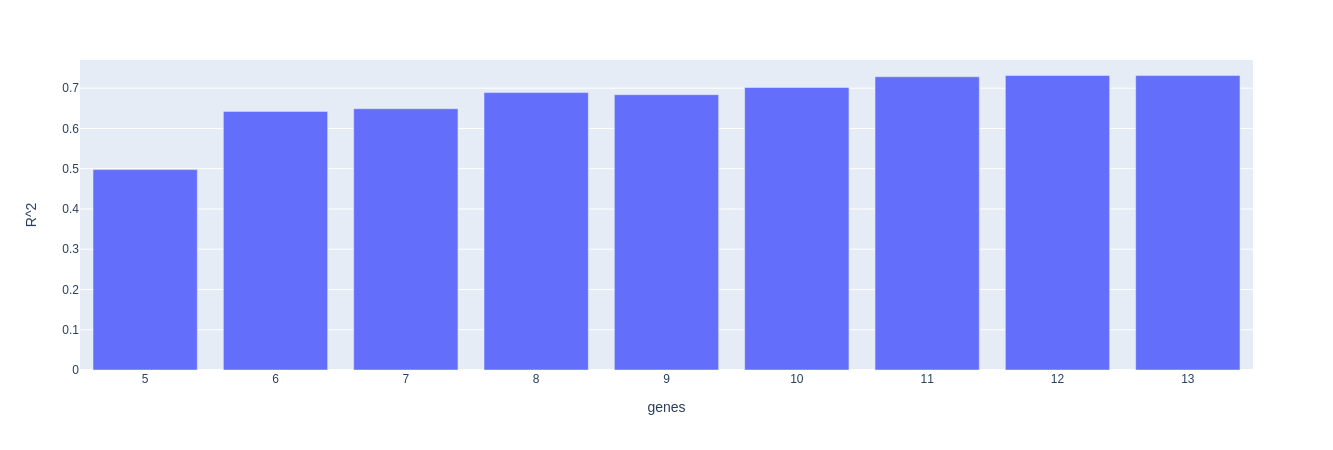

In [138]:
import plotly.express as px
fig = px.bar(rs_pd, x="genes", y="R^2")
fig

## With tissues ##

### Selected genes number ###

In [152]:
genes_number = 6
lifespan_results = lifespan_pipeline.fit_transform(selection(genes_number,"lifespan"))
lifespan_results.metrics_average

2020-11-11 18:48:01.375 | INFO     | yspecies.selection:fit:157 - ===== fitting models with seed 0 =====
2020-11-11 18:48:01.378 | INFO     | yspecies.selection:fit:158 - PARAMETERS:
{'bagging_fraction': 0.3894297532715532, 'boosting_type': 'gbdt', 'drop_rate': 0.26800128097507525, 'feature_fraction': 0.40928196640627, 'lambda_l1': 1.5344719775574764, 'lambda_l2': 2.4063980152266398, 'learning_rate': 0.044493898644234905, 'max_depth': 4, 'max_leaves': 22, 'min_data_in_leaf': 4, 'objective': 'regression', 'metrics': ['l1', 'l2', 'huber'], 'verbose': -1, 'early_stopping_round': 10, 'seed': 9}
2020-11-11 18:48:01.383 | INFO     | yspecies.selection:fit:161 - SEED: 0 | FOLD: 0 | VALIDATION_SPECIES: ['Gorilla_gorilla', 'Pan_paniscus']
/data/miniconda3/envs/yspecies/lib/python3.8/site-packages/lightgbm/engine.py:156: UserWarning:

Found `early_stopping_round` in params. Will use it instead of argument

2020-11-11 18:48:01.508 | INFO     | yspecies.selection:fit:161 - SEED: 0 | FOLD: 1 | VALI

Training until validation scores don't improve for 10 rounds
Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[78]	valid_0's l1: 9.0544	valid_0's l2: 289.732	valid_0's huber: 7.8024
Training until validation scores don't improve for 10 rounds
Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[102]	valid_0's l1: 8.86884	valid_0's l2: 353.245	valid_0's huber: 7.63484
Training until validation scores don't improve for 10 rounds
Training until validation scores don't improve for 10 rounds


2020-11-11 18:48:01.696 | INFO     | yspecies.selection:fit:161 - SEED: 0 | FOLD: 3 | VALIDATION_SPECIES: ['Macaca_nemestrina', 'Microcebus_murinus']
2020-11-11 18:48:01.780 | INFO     | yspecies.selection:fit:161 - SEED: 0 | FOLD: 4 | VALIDATION_SPECIES: ['Felis_catus', 'Pan_troglodytes']


Early stopping, best iteration is:
[95]	valid_0's l1: 8.25585	valid_0's l2: 254.45	valid_0's huber: 7.0963
Training until validation scores don't improve for 10 rounds
Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[84]	valid_0's l1: 6.37588	valid_0's l2: 154.989	valid_0's huber: 5.37913
Training until validation scores don't improve for 10 rounds
Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[67]	valid_0's l1: 7.91436	valid_0's l2: 228.4	valid_0's huber: 6.72991


2020-11-11 18:48:02.835 | INFO     | yspecies.explanations:transform:646 - Metrics: 
Metrics(R2=0.6351705679096066, MAE=8.093868233073206, MSE=256.16336855011764, huber=6.90978253189523)
2020-11-11 18:48:02.841 | INFO     | yspecies.selection:fit:157 - ===== fitting models with seed 1 =====
2020-11-11 18:48:02.842 | INFO     | yspecies.selection:fit:158 - PARAMETERS:
{'bagging_fraction': 0.3894297532715532, 'boosting_type': 'gbdt', 'drop_rate': 0.26800128097507525, 'feature_fraction': 0.40928196640627, 'lambda_l1': 1.5344719775574764, 'lambda_l2': 2.4063980152266398, 'learning_rate': 0.044493898644234905, 'max_depth': 4, 'max_leaves': 22, 'min_data_in_leaf': 4, 'objective': 'regression', 'metrics': ['l1', 'l2', 'huber'], 'verbose': -1, 'early_stopping_round': 10, 'seed': 0}
2020-11-11 18:48:02.846 | INFO     | yspecies.selection:fit:161 - SEED: 1 | FOLD: 0 | VALIDATION_SPECIES: ['Felis_catus', 'Ursus_americanus']
/data/miniconda3/envs/yspecies/lib/python3.8/site-packages/lightgbm/engin

Training until validation scores don't improve for 10 rounds
Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[114]	valid_0's l1: 7.23109	valid_0's l2: 200.532	valid_0's huber: 6.15941
Training until validation scores don't improve for 10 rounds
Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[101]	valid_0's l1: 8.84807	valid_0's l2: 338.364	valid_0's huber: 7.60099


2020-11-11 18:48:03.134 | INFO     | yspecies.selection:fit:161 - SEED: 1 | FOLD: 3 | VALIDATION_SPECIES: ['Gorilla_gorilla', 'Ovis_aries']
2020-11-11 18:48:03.194 | INFO     | yspecies.selection:fit:161 - SEED: 1 | FOLD: 4 | VALIDATION_SPECIES: ['Pan_troglodytes', 'Ailuropoda_melanoleuca']


Training until validation scores don't improve for 10 rounds
Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[66]	valid_0's l1: 7.93136	valid_0's l2: 240.018	valid_0's huber: 6.74395
Training until validation scores don't improve for 10 rounds
Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[50]	valid_0's l1: 10.0123	valid_0's l2: 251.186	valid_0's huber: 8.61121
Training until validation scores don't improve for 10 rounds
Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[112]	valid_0's l1: 7.04686	valid_0's l2: 208.119	valid_0's huber: 5.98775


2020-11-11 18:48:04.269 | INFO     | yspecies.explanations:transform:646 - Metrics: 
Metrics(R2=0.6536820679136054, MAE=8.213931958417984, MSE=247.6439768307931, huber=6.990011172921976)
2020-11-11 18:48:04.273 | INFO     | yspecies.selection:fit:157 - ===== fitting models with seed 2 =====
2020-11-11 18:48:04.274 | INFO     | yspecies.selection:fit:158 - PARAMETERS:
{'bagging_fraction': 0.3894297532715532, 'boosting_type': 'gbdt', 'drop_rate': 0.26800128097507525, 'feature_fraction': 0.40928196640627, 'lambda_l1': 1.5344719775574764, 'lambda_l2': 2.4063980152266398, 'learning_rate': 0.044493898644234905, 'max_depth': 4, 'max_leaves': 22, 'min_data_in_leaf': 4, 'objective': 'regression', 'metrics': ['l1', 'l2', 'huber'], 'verbose': -1, 'early_stopping_round': 10, 'seed': 1}
2020-11-11 18:48:04.278 | INFO     | yspecies.selection:fit:161 - SEED: 2 | FOLD: 0 | VALIDATION_SPECIES: ['Rhinopithecus_bieti', 'Ursus_americanus']
/data/miniconda3/envs/yspecies/lib/python3.8/site-packages/lightg

Training until validation scores don't improve for 10 rounds
Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[59]	valid_0's l1: 9.33025	valid_0's l2: 333.618	valid_0's huber: 7.99684
Training until validation scores don't improve for 10 rounds
Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[99]	valid_0's l1: 9.71719	valid_0's l2: 396.613	valid_0's huber: 8.38619
Training until validation scores don't improve for 10 rounds
Training until validation scores don't improve for 10 rounds


2020-11-11 18:48:04.503 | INFO     | yspecies.selection:fit:161 - SEED: 2 | FOLD: 3 | VALIDATION_SPECIES: ['Rattus_norvegicus', 'Monodelphis_domestica']
2020-11-11 18:48:04.633 | INFO     | yspecies.selection:fit:161 - SEED: 2 | FOLD: 4 | VALIDATION_SPECIES: ['Bos_taurus', 'Tupaia_belangeri']


Early stopping, best iteration is:
[67]	valid_0's l1: 9.24785	valid_0's l2: 308.388	valid_0's huber: 7.93251
Training until validation scores don't improve for 10 rounds
Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[151]	valid_0's l1: 6.2368	valid_0's l2: 99.0445	valid_0's huber: 5.23261
Training until validation scores don't improve for 10 rounds
Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[48]	valid_0's l1: 10.5797	valid_0's l2: 327.387	valid_0's huber: 9.12407


2020-11-11 18:48:05.730 | INFO     | yspecies.explanations:transform:646 - Metrics: 
Metrics(R2=0.6071957132924274, MAE=9.022354712880803, MSE=293.0100454388682, huber=7.700544439071305)
2020-11-11 18:48:05.734 | INFO     | yspecies.selection:fit:157 - ===== fitting models with seed 3 =====
2020-11-11 18:48:05.735 | INFO     | yspecies.selection:fit:158 - PARAMETERS:
{'bagging_fraction': 0.3894297532715532, 'boosting_type': 'gbdt', 'drop_rate': 0.26800128097507525, 'feature_fraction': 0.40928196640627, 'lambda_l1': 1.5344719775574764, 'lambda_l2': 2.4063980152266398, 'learning_rate': 0.044493898644234905, 'max_depth': 4, 'max_leaves': 22, 'min_data_in_leaf': 4, 'objective': 'regression', 'metrics': ['l1', 'l2', 'huber'], 'verbose': -1, 'early_stopping_round': 10, 'seed': 2}
2020-11-11 18:48:05.739 | INFO     | yspecies.selection:fit:161 - SEED: 3 | FOLD: 0 | VALIDATION_SPECIES: ['Microcebus_murinus', 'Pan_paniscus']
/data/miniconda3/envs/yspecies/lib/python3.8/site-packages/lightgbm/en

Training until validation scores don't improve for 10 rounds
Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[103]	valid_0's l1: 7.95276	valid_0's l2: 245.748	valid_0's huber: 6.79744
Training until validation scores don't improve for 10 rounds
Training until validation scores don't improve for 10 rounds


2020-11-11 18:48:05.959 | INFO     | yspecies.selection:fit:161 - SEED: 3 | FOLD: 2 | VALIDATION_SPECIES: ['Bos_taurus', 'Capra_hircus']
2020-11-11 18:48:06.064 | INFO     | yspecies.selection:fit:161 - SEED: 3 | FOLD: 3 | VALIDATION_SPECIES: ['Rhinolophus_ferrumequinum', 'Mus_musculus']


Early stopping, best iteration is:
[118]	valid_0's l1: 10.6601	valid_0's l2: 375.663	valid_0's huber: 9.21505
Training until validation scores don't improve for 10 rounds
Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[103]	valid_0's l1: 8.45647	valid_0's l2: 248.666	valid_0's huber: 7.2691
Training until validation scores don't improve for 10 rounds
Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[101]	valid_0's l1: 4.90724	valid_0's l2: 121.526	valid_0's huber: 4.0782


2020-11-11 18:48:06.157 | INFO     | yspecies.selection:fit:161 - SEED: 3 | FOLD: 4 | VALIDATION_SPECIES: ['Suricata_suricatta', 'Meriones_unguiculatus']


Training until validation scores don't improve for 10 rounds
Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[123]	valid_0's l1: 6.60567	valid_0's l2: 180.76	valid_0's huber: 5.58889


2020-11-11 18:48:07.275 | INFO     | yspecies.explanations:transform:646 - Metrics: 
Metrics(R2=0.6736027220229669, MAE=7.716439772804191, MSE=234.47255505980425, huber=6.597750420499368)
2020-11-11 18:48:07.283 | INFO     | yspecies.selection:fit:157 - ===== fitting models with seed 4 =====
2020-11-11 18:48:07.285 | INFO     | yspecies.selection:fit:158 - PARAMETERS:
{'bagging_fraction': 0.3894297532715532, 'boosting_type': 'gbdt', 'drop_rate': 0.26800128097507525, 'feature_fraction': 0.40928196640627, 'lambda_l1': 1.5344719775574764, 'lambda_l2': 2.4063980152266398, 'learning_rate': 0.044493898644234905, 'max_depth': 4, 'max_leaves': 22, 'min_data_in_leaf': 4, 'objective': 'regression', 'metrics': ['l1', 'l2', 'huber'], 'verbose': -1, 'early_stopping_round': 10, 'seed': 3}
2020-11-11 18:48:07.288 | INFO     | yspecies.selection:fit:161 - SEED: 4 | FOLD: 0 | VALIDATION_SPECIES: ['Macaca_fascicularis', 'Pan_troglodytes']
/data/miniconda3/envs/yspecies/lib/python3.8/site-packages/lightg

Training until validation scores don't improve for 10 rounds
Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[87]	valid_0's l1: 7.7331	valid_0's l2: 228.333	valid_0's huber: 6.59539
Training until validation scores don't improve for 10 rounds
Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[109]	valid_0's l1: 8.64763	valid_0's l2: 348.805	valid_0's huber: 7.42381
Training until validation scores don't improve for 10 rounds
Training until validation scores don't improve for 10 rounds


2020-11-11 18:48:07.623 | INFO     | yspecies.selection:fit:161 - SEED: 4 | FOLD: 3 | VALIDATION_SPECIES: ['Pan_paniscus', 'Gorilla_gorilla']
2020-11-11 18:48:07.708 | INFO     | yspecies.selection:fit:161 - SEED: 4 | FOLD: 4 | VALIDATION_SPECIES: ['Bos_taurus', 'Equus_caballus']


Early stopping, best iteration is:
[153]	valid_0's l1: 7.85203	valid_0's l2: 211.632	valid_0's huber: 6.72221
Training until validation scores don't improve for 10 rounds
Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[75]	valid_0's l1: 7.20237	valid_0's l2: 177.369	valid_0's huber: 6.11198
Training until validation scores don't improve for 10 rounds
Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[66]	valid_0's l1: 8.90143	valid_0's l2: 305.631	valid_0's huber: 7.62163


2020-11-11 18:48:08.822 | INFO     | yspecies.explanations:transform:646 - Metrics: 
Metrics(R2=0.6283661293923789, MAE=8.067314125349721, MSE=254.35378772312043, huber=6.897871565010304)
2020-11-11 18:48:08.826 | INFO     | yspecies.selection:fit:157 - ===== fitting models with seed 5 =====
2020-11-11 18:48:08.827 | INFO     | yspecies.selection:fit:158 - PARAMETERS:
{'bagging_fraction': 0.3894297532715532, 'boosting_type': 'gbdt', 'drop_rate': 0.26800128097507525, 'feature_fraction': 0.40928196640627, 'lambda_l1': 1.5344719775574764, 'lambda_l2': 2.4063980152266398, 'learning_rate': 0.044493898644234905, 'max_depth': 4, 'max_leaves': 22, 'min_data_in_leaf': 4, 'objective': 'regression', 'metrics': ['l1', 'l2', 'huber'], 'verbose': -1, 'early_stopping_round': 10, 'seed': 4}
2020-11-11 18:48:08.831 | INFO     | yspecies.selection:fit:161 - SEED: 5 | FOLD: 0 | VALIDATION_SPECIES: ['Mus_spicilegus', 'Canis_lupus_familiaris']
/data/miniconda3/envs/yspecies/lib/python3.8/site-packages/ligh

Training until validation scores don't improve for 10 rounds
Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[59]	valid_0's l1: 9.00518	valid_0's l2: 308.428	valid_0's huber: 7.71308
Training until validation scores don't improve for 10 rounds
Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[69]	valid_0's l1: 9.28217	valid_0's l2: 357.52	valid_0's huber: 7.96287
Training until validation scores don't improve for 10 rounds
Training until validation scores don't improve for 10 rounds


2020-11-11 18:48:09.044 | INFO     | yspecies.selection:fit:161 - SEED: 5 | FOLD: 3 | VALIDATION_SPECIES: ['Cavia_aperea', 'Ailuropoda_melanoleuca']
2020-11-11 18:48:09.129 | INFO     | yspecies.selection:fit:161 - SEED: 5 | FOLD: 4 | VALIDATION_SPECIES: ['Felis_catus', 'Rhinopithecus_bieti']


Early stopping, best iteration is:
[75]	valid_0's l1: 8.61772	valid_0's l2: 257.332	valid_0's huber: 7.37888
Training until validation scores don't improve for 10 rounds
Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[87]	valid_0's l1: 6.88085	valid_0's l2: 164.578	valid_0's huber: 5.85234
Training until validation scores don't improve for 10 rounds
Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[50]	valid_0's l1: 7.62096	valid_0's l2: 219.296	valid_0's huber: 6.46277


2020-11-11 18:48:10.192 | INFO     | yspecies.explanations:transform:646 - Metrics: 
Metrics(R2=0.6355427144172905, MAE=8.281378508828107, MSE=261.4307208772132, huber=7.053456445947113)
2020-11-11 18:48:10.197 | INFO     | yspecies.selection:fit:157 - ===== fitting models with seed 6 =====
2020-11-11 18:48:10.198 | INFO     | yspecies.selection:fit:158 - PARAMETERS:
{'bagging_fraction': 0.3894297532715532, 'boosting_type': 'gbdt', 'drop_rate': 0.26800128097507525, 'feature_fraction': 0.40928196640627, 'lambda_l1': 1.5344719775574764, 'lambda_l2': 2.4063980152266398, 'learning_rate': 0.044493898644234905, 'max_depth': 4, 'max_leaves': 22, 'min_data_in_leaf': 4, 'objective': 'regression', 'metrics': ['l1', 'l2', 'huber'], 'verbose': -1, 'early_stopping_round': 10, 'seed': 5}
2020-11-11 18:48:10.201 | INFO     | yspecies.selection:fit:161 - SEED: 6 | FOLD: 0 | VALIDATION_SPECIES: ['Rhinolophus_ferrumequinum', 'Heterocephalus_glaber']
/data/miniconda3/envs/yspecies/lib/python3.8/site-pack

Training until validation scores don't improve for 10 rounds
Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[74]	valid_0's l1: 8.59349	valid_0's l2: 282.592	valid_0's huber: 7.36059
Training until validation scores don't improve for 10 rounds
Training until validation scores don't improve for 10 rounds


2020-11-11 18:48:10.415 | INFO     | yspecies.selection:fit:161 - SEED: 6 | FOLD: 2 | VALIDATION_SPECIES: ['Rhinopithecus_bieti', 'Ovis_aries']
2020-11-11 18:48:10.468 | INFO     | yspecies.selection:fit:161 - SEED: 6 | FOLD: 3 | VALIDATION_SPECIES: ['Cavia_porcellus', 'Pan_troglodytes']
2020-11-11 18:48:10.547 | INFO     | yspecies.selection:fit:161 - SEED: 6 | FOLD: 4 | VALIDATION_SPECIES: ['Vombatus_ursinus', 'Sus_scrofa']


Early stopping, best iteration is:
[119]	valid_0's l1: 9.18122	valid_0's l2: 360.493	valid_0's huber: 7.90372
Training until validation scores don't improve for 10 rounds
Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[47]	valid_0's l1: 10.4512	valid_0's l2: 344.816	valid_0's huber: 9.00598
Training until validation scores don't improve for 10 rounds
Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[81]	valid_0's l1: 8.59422	valid_0's l2: 185.378	valid_0's huber: 7.35625
Training until validation scores don't improve for 10 rounds
Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[85]	valid_0's l1: 6.67618	valid_0's l2: 197.129	valid_0's huber: 5.67131


2020-11-11 18:48:11.659 | INFO     | yspecies.explanations:transform:646 - Metrics: 
Metrics(R2=0.6239737493672701, MAE=8.699260234449781, MSE=274.0813626982448, huber=7.468538209078458)
2020-11-11 18:48:11.664 | INFO     | yspecies.selection:fit:157 - ===== fitting models with seed 7 =====
2020-11-11 18:48:11.665 | INFO     | yspecies.selection:fit:158 - PARAMETERS:
{'bagging_fraction': 0.3894297532715532, 'boosting_type': 'gbdt', 'drop_rate': 0.26800128097507525, 'feature_fraction': 0.40928196640627, 'lambda_l1': 1.5344719775574764, 'lambda_l2': 2.4063980152266398, 'learning_rate': 0.044493898644234905, 'max_depth': 4, 'max_leaves': 22, 'min_data_in_leaf': 4, 'objective': 'regression', 'metrics': ['l1', 'l2', 'huber'], 'verbose': -1, 'early_stopping_round': 10, 'seed': 6}
2020-11-11 18:48:11.668 | INFO     | yspecies.selection:fit:161 - SEED: 7 | FOLD: 0 | VALIDATION_SPECIES: ['Macaca_mulatta', 'Cavia_porcellus']
/data/miniconda3/envs/yspecies/lib/python3.8/site-packages/lightgbm/eng

Training until validation scores don't improve for 10 rounds
Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[83]	valid_0's l1: 8.86278	valid_0's l2: 253.672	valid_0's huber: 7.60557
Training until validation scores don't improve for 10 rounds
Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[98]	valid_0's l1: 9.06861	valid_0's l2: 375.257	valid_0's huber: 7.80604
Training until validation scores don't improve for 10 rounds
Training until validation scores don't improve for 10 rounds


2020-11-11 18:48:11.937 | INFO     | yspecies.selection:fit:161 - SEED: 7 | FOLD: 3 | VALIDATION_SPECIES: ['Canis_lupus_familiaris', 'Ursus_americanus']
2020-11-11 18:48:12.063 | INFO     | yspecies.selection:fit:161 - SEED: 7 | FOLD: 4 | VALIDATION_SPECIES: ['Tupaia_belangeri', 'Ailuropoda_melanoleuca']


Early stopping, best iteration is:
[91]	valid_0's l1: 8.04655	valid_0's l2: 247.751	valid_0's huber: 6.90496
Training until validation scores don't improve for 10 rounds
Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[147]	valid_0's l1: 6.46719	valid_0's l2: 163.055	valid_0's huber: 5.48973
Training until validation scores don't improve for 10 rounds
Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[85]	valid_0's l1: 6.50008	valid_0's l2: 185.115	valid_0's huber: 5.50131


2020-11-11 18:48:13.381 | INFO     | yspecies.explanations:transform:646 - Metrics: 
Metrics(R2=0.6603711934794096, MAE=7.7890420489834415, MSE=244.96987932778273, huber=6.671538886749393)
2020-11-11 18:48:13.386 | INFO     | yspecies.selection:fit:157 - ===== fitting models with seed 8 =====
2020-11-11 18:48:13.387 | INFO     | yspecies.selection:fit:158 - PARAMETERS:
{'bagging_fraction': 0.3894297532715532, 'boosting_type': 'gbdt', 'drop_rate': 0.26800128097507525, 'feature_fraction': 0.40928196640627, 'lambda_l1': 1.5344719775574764, 'lambda_l2': 2.4063980152266398, 'learning_rate': 0.044493898644234905, 'max_depth': 4, 'max_leaves': 22, 'min_data_in_leaf': 4, 'objective': 'regression', 'metrics': ['l1', 'l2', 'huber'], 'verbose': -1, 'early_stopping_round': 10, 'seed': 7}
2020-11-11 18:48:13.392 | INFO     | yspecies.selection:fit:161 - SEED: 8 | FOLD: 0 | VALIDATION_SPECIES: ['Pan_paniscus', 'Suricata_suricatta']
/data/miniconda3/envs/yspecies/lib/python3.8/site-packages/lightgbm/

Training until validation scores don't improve for 10 rounds
Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[81]	valid_0's l1: 8.58304	valid_0's l2: 280.678	valid_0's huber: 7.36566
Training until validation scores don't improve for 10 rounds
Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[98]	valid_0's l1: 9.03012	valid_0's l2: 336.871	valid_0's huber: 7.76687
Training until validation scores don't improve for 10 rounds
Training until validation scores don't improve for 10 rounds


2020-11-11 18:48:13.688 | INFO     | yspecies.selection:fit:161 - SEED: 8 | FOLD: 3 | VALIDATION_SPECIES: ['Bos_taurus', 'Rhinolophus_ferrumequinum']
2020-11-11 18:48:13.762 | INFO     | yspecies.selection:fit:161 - SEED: 8 | FOLD: 4 | VALIDATION_SPECIES: ['Oryctolagus_cuniculus', 'Sus_scrofa']


Early stopping, best iteration is:
[122]	valid_0's l1: 6.90367	valid_0's l2: 195.572	valid_0's huber: 5.86598
Training until validation scores don't improve for 10 rounds
Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[73]	valid_0's l1: 7.83634	valid_0's l2: 209.276	valid_0's huber: 6.67536
Training until validation scores don't improve for 10 rounds
Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[90]	valid_0's l1: 7.20629	valid_0's l2: 200.859	valid_0's huber: 6.13296


2020-11-11 18:48:14.799 | INFO     | yspecies.explanations:transform:646 - Metrics: 
Metrics(R2=0.6548241827591346, MAE=7.911892245266448, MSE=244.65130470746308, huber=6.751122719941411)
2020-11-11 18:48:14.804 | INFO     | yspecies.selection:fit:157 - ===== fitting models with seed 9 =====
2020-11-11 18:48:14.805 | INFO     | yspecies.selection:fit:158 - PARAMETERS:
{'bagging_fraction': 0.3894297532715532, 'boosting_type': 'gbdt', 'drop_rate': 0.26800128097507525, 'feature_fraction': 0.40928196640627, 'lambda_l1': 1.5344719775574764, 'lambda_l2': 2.4063980152266398, 'learning_rate': 0.044493898644234905, 'max_depth': 4, 'max_leaves': 22, 'min_data_in_leaf': 4, 'objective': 'regression', 'metrics': ['l1', 'l2', 'huber'], 'verbose': -1, 'early_stopping_round': 10, 'seed': 8}
2020-11-11 18:48:14.809 | INFO     | yspecies.selection:fit:161 - SEED: 9 | FOLD: 0 | VALIDATION_SPECIES: ['Ictidomys_tridecemlineatus', 'Aotus_nancymaae']
/data/miniconda3/envs/yspecies/lib/python3.8/site-packages

Training until validation scores don't improve for 10 rounds
Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[166]	valid_0's l1: 9.09416	valid_0's l2: 265.287	valid_0's huber: 7.81993
Training until validation scores don't improve for 10 rounds
Training until validation scores don't improve for 10 rounds


2020-11-11 18:48:15.041 | INFO     | yspecies.selection:fit:161 - SEED: 9 | FOLD: 2 | VALIDATION_SPECIES: ['Mesocricetus_auratus', 'Meriones_unguiculatus']
2020-11-11 18:48:15.139 | INFO     | yspecies.selection:fit:161 - SEED: 9 | FOLD: 3 | VALIDATION_SPECIES: ['Gorilla_gorilla', 'Microcebus_murinus']
2020-11-11 18:48:15.214 | INFO     | yspecies.selection:fit:161 - SEED: 9 | FOLD: 4 | VALIDATION_SPECIES: ['Rhinolophus_ferrumequinum', 'Felis_catus']


Early stopping, best iteration is:
[87]	valid_0's l1: 10.0985	valid_0's l2: 387.288	valid_0's huber: 8.70023
Training until validation scores don't improve for 10 rounds
Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[114]	valid_0's l1: 6.25557	valid_0's l2: 164.876	valid_0's huber: 5.26424
Training until validation scores don't improve for 10 rounds
Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[75]	valid_0's l1: 7.51844	valid_0's l2: 170.163	valid_0's huber: 6.38421
Training until validation scores don't improve for 10 rounds
Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[168]	valid_0's l1: 7.19949	valid_0's l2: 195.012	valid_0's huber: 6.11135


2020-11-11 18:48:16.345 | INFO     | yspecies.explanations:transform:646 - Metrics: 
Metrics(R2=0.673833339803078, MAE=8.03324115543406, MSE=236.52517169998404, huber=6.851086653470416)


Metrics(R2=0.6446562380357168, MAE=8.182872299548773, MSE=254.73021729133916, huber=6.989170304458499)

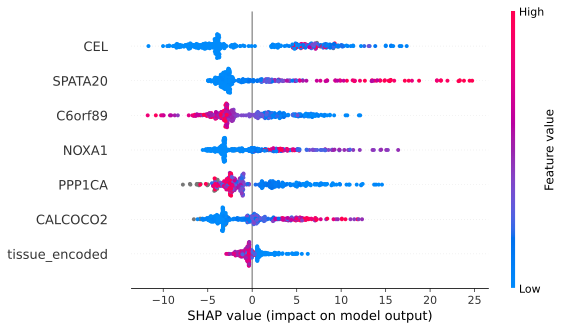

In [153]:
lifespan_results.plot(save=locations.output.plots / "stage_3" / "stage_3_summary.svg")

min_max dataset values: (3.3, 122.5)


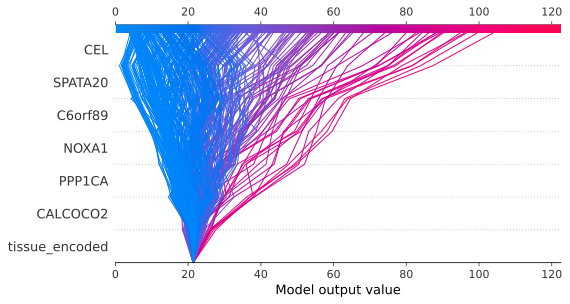

In [155]:
lifespan_results.plot_decision(save=locations.output.plots / "stage_3" / "stage_3_decision.svg")

min_max dataset values: (3.3, 122.5)


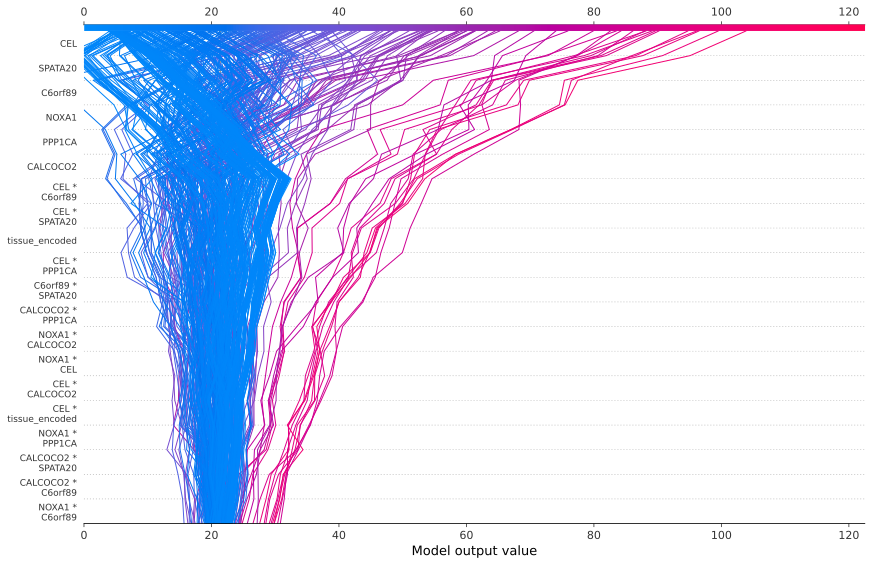

In [173]:
lifespan_results.plot_interaction_decision_plot(save=locations.output.plots / "stage_3" / "stage_3_decision.svg", auto_size_plot=False)

In [346]:
lifespan_results.first.feature_names.shape

(7,)

In [349]:
new_d = d.by_samples.filter(lambda s: s.tissue == "Liver")
new_sh = lifespan_results.filter_shap_by_data_samples(new_d)
print(new_sh.shape, lifespan_results.stable_shap_values.shape)
lifespan_results.first.plot(custom_shap_values = lifespan_results.stable_shap_values, custom_dataframe)

(139, 7) (408, 7)


TypeError: plot() got an unexpected keyword argument 'custom_shap_values'

In [337]:
def plot_tissue(tissue: str):
    new_d = d.by_samples.filter(lambda s: s.tissue == tissue)
    new_sh = lifespan_results.filter_shap_by_data_samples(new_d)
    print(new_sh.shape, lifespan_results.stable_shap_values.shape)
    return lifespan_results.plot_decision(custom_shap_values = new_sh)

../yspecies/explanations.py:235: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



(139, 7) (408, 7)
min_max dataset values: (3.3, 122.5)


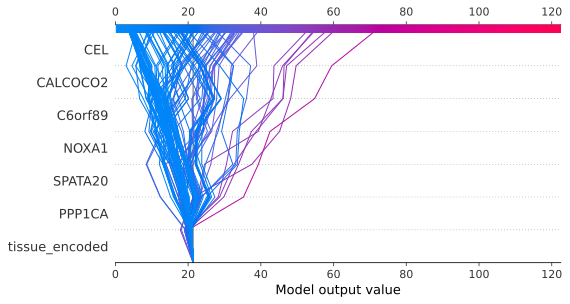

In [338]:
plot_tissue("Liver")

../yspecies/explanations.py:235: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



min_max dataset values: (3.3, 122.5)


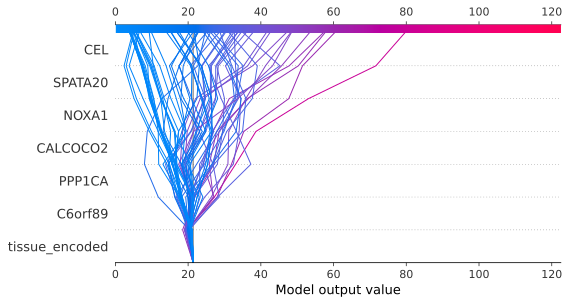

In [334]:
plot_tissue("Kidney")

../yspecies/explanations.py:235: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



min_max dataset values: (3.3, 122.5)


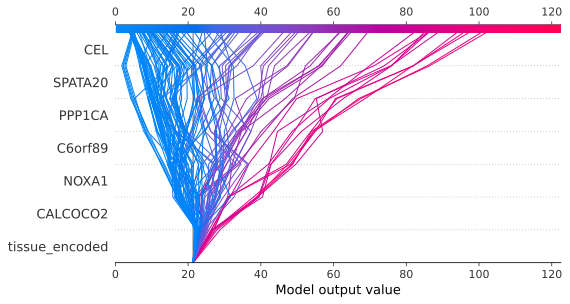

In [335]:
plot_tissue("Brain")

../yspecies/explanations.py:235: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



min_max dataset values: (3.3, 122.5)


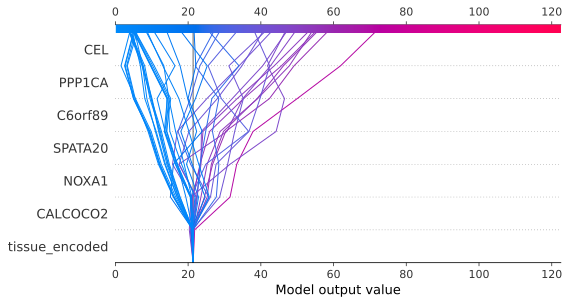

In [336]:
plot_tissue("Heart")

In [372]:
lifespan_results

FeatureSummary(results=[<table border='2'><caption><h3>Feature selection results</h3><caption><tr style='text-align:center'><th>selected</th><th>metrics</th><th>hold out metrics</th></tr><tr><td><div>
<style scoped>
    .dataframe tbody tr th:only-of-type {
        vertical-align: middle;
    }

    .dataframe tbody tr th {
        vertical-align: top;
    }

    .dataframe thead th {
        text-align: right;
    }
</style>
<table border="1" class="dataframe">
  <thead>
    <tr style="text-align: right;">
      <th></th>
      <th>symbol</th>
      <th>shap_absolute_sum_to_lifespan</th>
      <th>shap_mean</th>
      <th>kendall_tau_to_lifespan</th>
    </tr>
  </thead>
  <tbody>
    <tr>
      <th>ENSG00000170835</th>
      <td>CEL</td>
      <td>5.629</td>
      <td>0.279</td>
      <td>0.685</td>
    </tr>
    <tr>
      <th>ENSG00000006282</th>
      <td>SPATA20</td>
      <td>3.813</td>
      <td>0.243</td>
      <td>0.605</td>
    </tr>
    <tr>
      <th>ENSG00000136436</th>
      <td>CALCOCO2</td>
      <td>3.634</td>
      <td>-0.206</td>
      <td>0.730</td>
    </tr>
    <tr>
      <th>ENSG00000198663</th>
      <td>C6orf89</td>
      <td>3.632</td>
      <td>-0.190</td>
      <td>-0.719</td>
    </tr>
    <tr>
      <th>ENSG00000188747</th>
      <td>NOXA1</td>
      <td>3.481</td>
      <td>-0.151</td>
      <td>0.626</td>
    </tr>
    <tr>
      <th>ENSG00000172531</th>
      <td>PPP1CA</td>
      <td>3.477</td>
      <td>-0.052</td>
      <td>-0.669</td>
    </tr>
  </tbody>
</table>
</div></th><th><div>
<style scoped>
    .dataframe tbody tr th:only-of-type {
        vertical-align: middle;
    }

    .dataframe tbody tr th {
        vertical-align: top;
    }

    .dataframe thead th {
        text-align: right;
    }
</style>
<table border="1" class="dataframe">
  <thead>
    <tr style="text-align: right;">
      <th></th>
      <th>R^2</th>
      <th>MAE</th>
      <th>MSE</th>
      <th>huber</th>
      <th>validation_species</th>
    </tr>
  </thead>
  <tbody>
    <tr>
      <th>0</th>
      <td>0.687</td>
      <td>9.054</td>
      <td>289.732</td>
      <td>7.812</td>
      <td>[Gorilla_gorilla, Pan_paniscus]</td>
    </tr>
    <tr>
      <th>1</th>
      <td>0.504</td>
      <td>8.869</td>
      <td>353.245</td>
      <td>7.665</td>
      <td>[Heterocephalus_glaber, Capra_hircus]</td>
    </tr>
    <tr>
      <th>2</th>
      <td>0.632</td>
      <td>8.256</td>
      <td>254.450</td>
      <td>7.054</td>
      <td>[Bos_taurus, Otolemur_garnettii]</td>
    </tr>
    <tr>
      <th>3</th>
      <td>0.703</td>
      <td>6.376</td>
      <td>154.989</td>
      <td>5.383</td>
      <td>[Macaca_nemestrina, Microcebus_murinus]</td>
    </tr>
    <tr>
      <th>4</th>
      <td>0.651</td>
      <td>7.914</td>
      <td>228.400</td>
      <td>6.635</td>
      <td>[Felis_catus, Pan_troglodytes]</td>
    </tr>
  </tbody>
</table>
</div></th><th></th></tr></table>, <table border='2'><caption><h3>Feature selection results</h3><caption><tr style='text-align:center'><th>selected</th><th>metrics</th><th>hold out metrics</th></tr><tr><td><div>
<style scoped>
    .dataframe tbody tr th:only-of-type {
        vertical-align: middle;
    }

    .dataframe tbody tr th {
        vertical-align: top;
    }

    .dataframe thead th {
        text-align: right;
    }
</style>
<table border="1" class="dataframe">
  <thead>
    <tr style="text-align: right;">
      <th></th>
      <th>symbol</th>
      <th>shap_absolute_sum_to_lifespan</th>
      <th>shap_mean</th>
      <th>kendall_tau_to_lifespan</th>
    </tr>
  </thead>
  <tbody>
    <tr>
      <th>ENSG00000170835</th>
      <td>CEL</td>
      <td>5.371</td>
      <td>0.203</td>
      <td>0.669</td>
    </tr>
    <tr>
      <th>ENSG00000006282</th>
      <td>SPATA20</td>
      <td>4.375</td>
      <td>0.180</td>
      <td>0.555</td>
    </tr>
    <tr>
      <th>ENSG00000188747</th>
      <td>NOXA1</td>
      <td>3.661</td>
      <td>0.057</td>
      <td>0.628</td>
    </tr

In [ ]:
exp: shap.Explanation = self.mean_shap_values.copy()
exp.values = self.filter_shap(filter)

min_max dataset values: (3.3, 122.5)


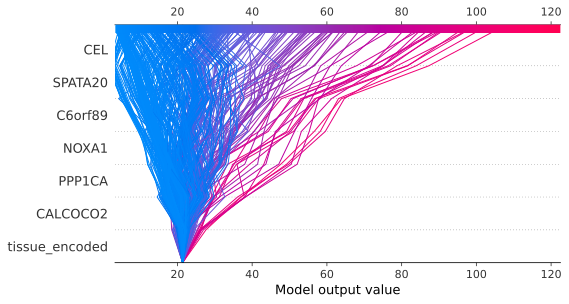

In [181]:
lifespan_results_his.plot_interaction_decision_plot
lifespan_results.first._plot_decision_(self.expected_values_mean, self.stable_shap_values, minimum = 100.0, maximum = 120.0,)

min_max dataset values: (3.3, 122.5)


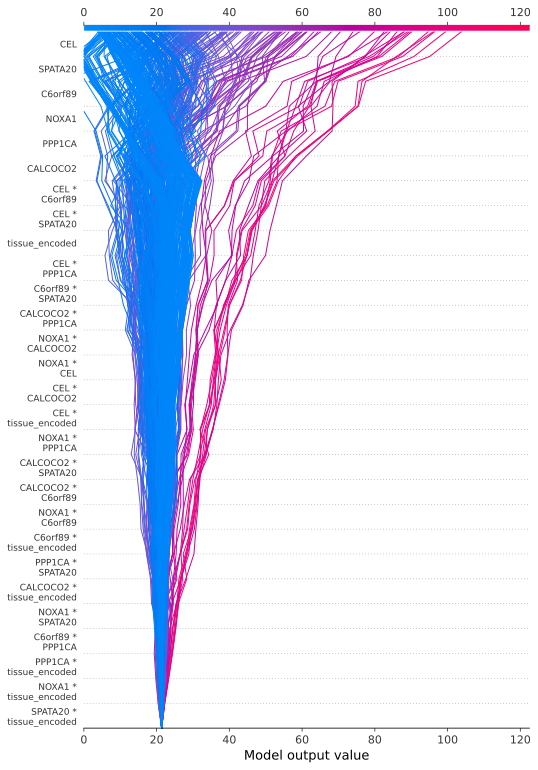

In [371]:
lifespan_results.plot_interaction_decision(feature_display_range = slice(-1, -100-1, -1))

In [281]:
lifespan_results.partitions.X.join(d.samples[d.samples["species"]=="Homo_sapiens"][[]], how="inner")

ENSG00000188747  ENSG00000170835  ENSG00000136436  \
run                                                             
SRR5961830            6.752            0.896          163.066   
SRR5885325           10.621            7.210           29.179   
SRR306843             3.585            0.344           29.014   
SRR306844             0.528           11.557           72.353   
SRR306845             9.232            2.723           38.247   
SRR787277             0.733            0.474          218.864   
SRR306841             5.751            0.290           34.501   
SRR306840            16.480            1.133           68.399   
SRR306839            10.394            0.593           41.146   
SRR1521445           11.492            0.641           63.037   
SRR3715877            9.414            1.737          243.896   
SRR5008362            0.360            0.108          124.115   
SRR5120939            9.031            0.387          112.687   
SRR5120940            9.987            0.365           74.957   
SRR8702484            1.216            0.238           24.373   
SRR5961972            5.696            0.460          145.620   
SRR5961875            2.455            0.146           66.201   
SRR306842            11.748            1.776           65.914   

            ENSG00000198663  ENSG00000172531  ENSG00000006282  tissue_encoded  
run                                                                            
SRR5961830           40.813           27.985           23.225               0  
SRR5885325           13.461           64.715           31.075               2  
SRR306843            18.494           57.888           31.643               0  
SRR306844            12.240           34.725           16.772               0  
SRR306845            17.214           49.474           56.805               0  
SRR787277            34.109           30.511            6.466               4  
SRR306841            25.885           41.366           22.415               0  
SRR306840            31.031           50.199           41.724               0  
SRR306839            23.620           67.882           32.384               0  
SRR1521445           20.705           28.421           36.640               0  
SRR3715877           44.006           70.240           30.076               4  
SRR5008362            8.432           16.637            5.811               1  
SRR5120939           46.848          114.079           27.493               4  
SRR5120940           36.318          111.191           26.375               4  
SRR8702484           10.260           27.215            3.746               3  
SRR5961972           47.370           29.651           17.899               0  
SRR5961875           50.134           35.980           16.412               0  
SRR306842            34.207          162.365           24.766               0

In [294]:
filter_shap(lifespan_results, lambda x: x.join(d.samples[d.samples["species"]=="Homo_sapiens"][[]], how="inner")).shape

VERY UNSAFE FUNCTION!


<ipython-input-293-4d85351fd13b>:10: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



(18, 7)

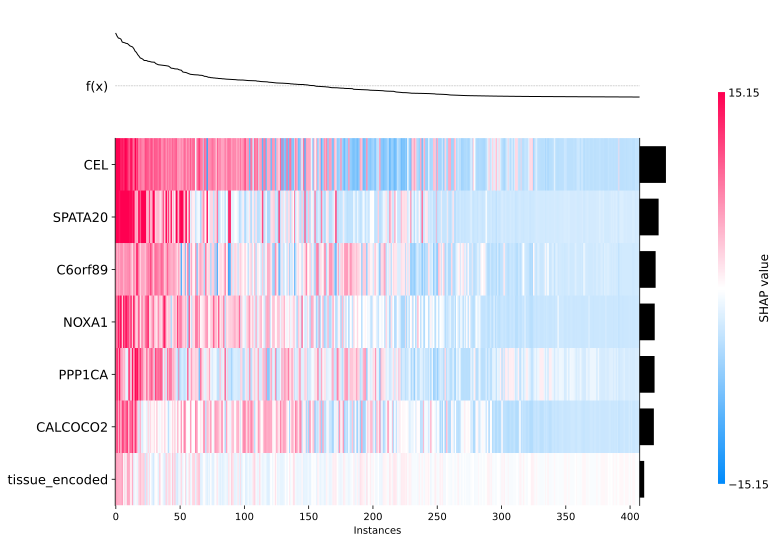

In [154]:
lifespan_results.plot_heatmap(sort_by_clust=False, save=locations.output.plots / "stage_3" / "stage_3_heatmap_unclustered.svg")

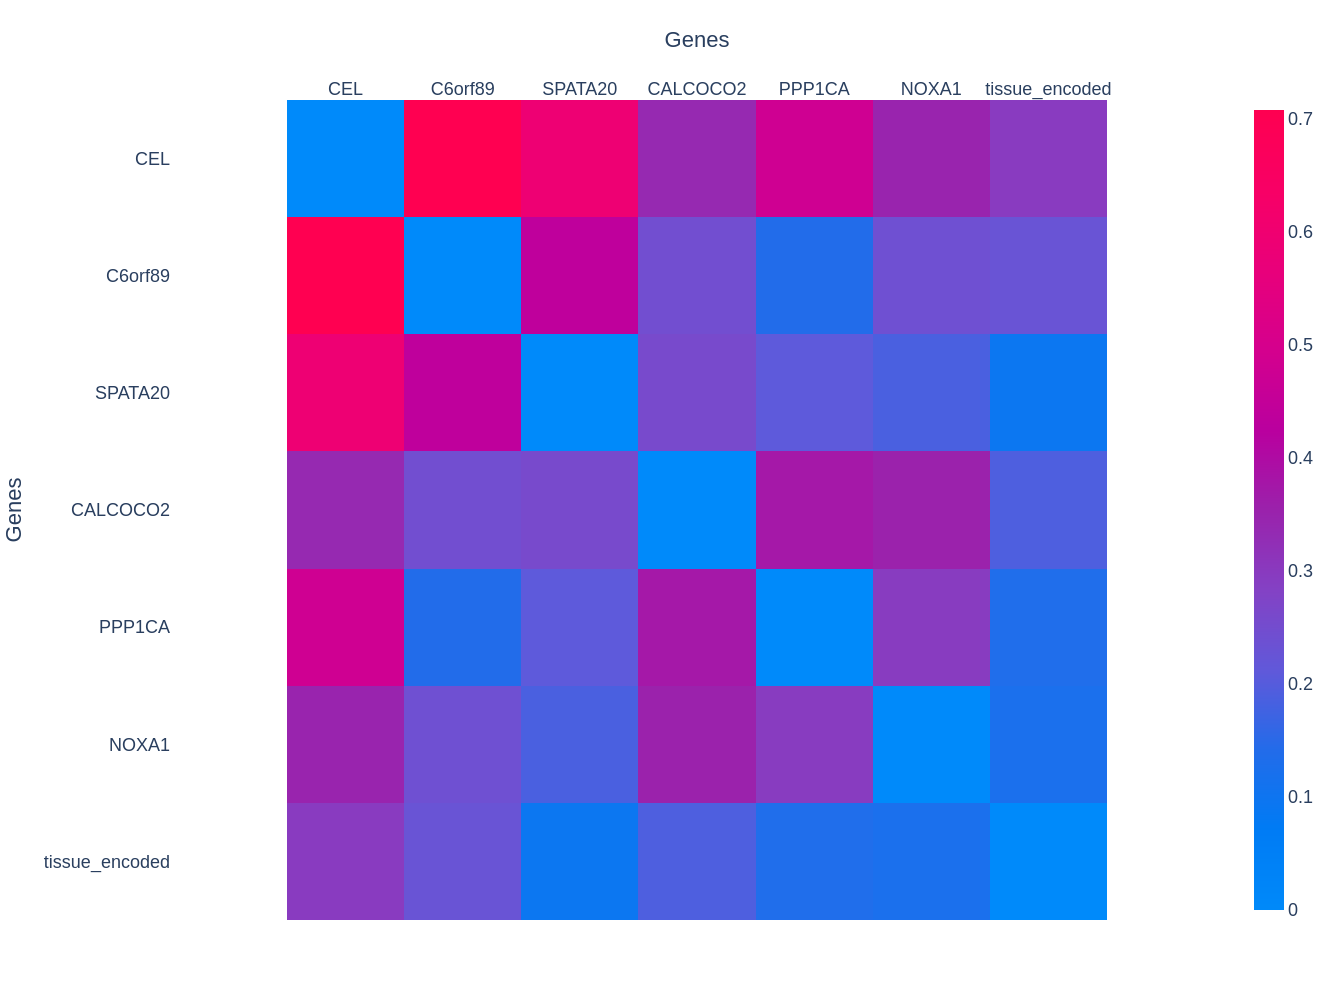

In [157]:
import plotly.io as pio
#pio.orca.config.use_xvfb = True

interactions_stage_two_plot_path = locations.output.plots / "genetic_interactions_stage_three.svg"
from yspecies.explanations import *
lifespan_results.plot_interactions(height=1000, width=1090, max=15, title="", axis_title="Genes")

### Dependency plots for the most interesting interactions ###

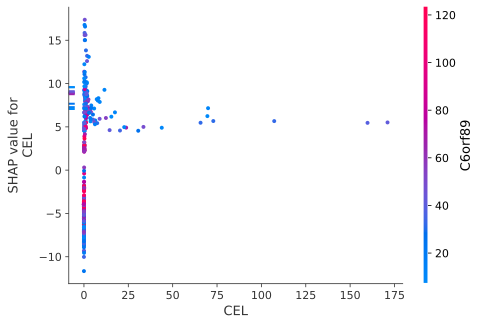

In [158]:
lifespan_results.plot_dependency("CEL", "C6orf89", save=locations.output.plots / "stage_3" / "interactions" / "CEL_C6orf89.svg")

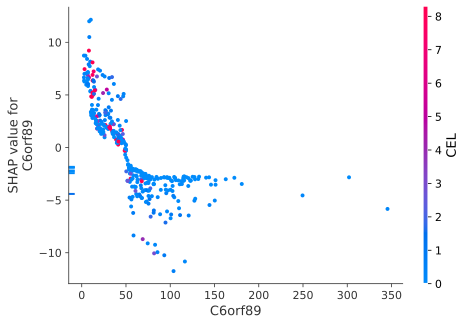

In [159]:
lifespan_results.plot_dependency("C6orf89","CEL", save=locations.output.plots / "stage_3" / "interactions" / "C6orf89_CEL.svg")

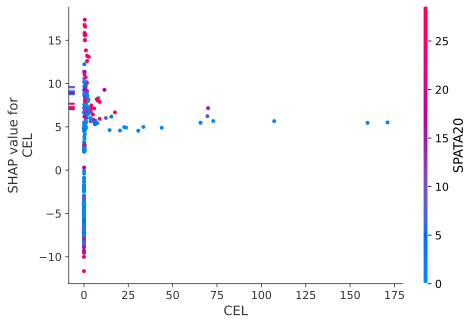

In [160]:
lifespan_results.plot_dependency("CEL", "SPATA20", save=locations.output.plots / "stage_3" / "interactions" / "CEL_SPATA20.svg")

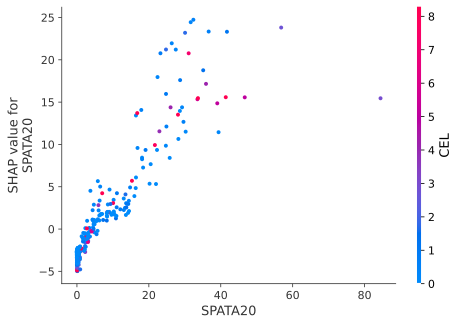

In [161]:
lifespan_results.plot_dependency("SPATA20", "CEL", save=locations.output.plots / "stage_3" / "interactions" / "SPATA20_CEL.svg")

# Life history checks #

In [151]:
from yspecies.preprocess import FeatureSelection
from yspecies.explanations import FeatureResults, FeatureSummary

In [103]:
from dataclasses import replace
other_life = [t for t in life_history if t != trait]
#sps = ["order"] + 
sps = other_life
life_pipe = factory.make_repeated_shap_pipeline(study_path = opt_by_trait("lifespan"), study_name=f"lifespan_r2_huber_kendall", opt_metrics = "huber")
life_pipe_debug = factory.make_shap_pipeline(study_path = opt_by_trait("lifespan"), study_name=f"lifespan_r2_huber_kendall", opt_metrics = "huber")
life_history_selection = replace(default_selection,species = sps, samples=["species"], categorical = [], not_validated_species = data.min_max_trait(trait))
life_history_selection

../yspecies/helpers.py:33: ExperimentalWarning:

create_study is experimental (supported from v1.4.0). The interface can change in the future.

/data/miniconda3/envs/yspecies/lib/python3.8/site-packages/optuna/multi_objective/study.py:114: ExperimentalWarning:

NSGAIIMultiObjectiveSampler is experimental (supported from v1.5.0). The interface can change in the future.

/data/miniconda3/envs/yspecies/lib/python3.8/site-packages/optuna/multi_objective/samplers/_nsga2.py:90: ExperimentalWarning:

RandomMultiObjectiveSampler is experimental (supported from v1.4.0). The interface can change in the future.

[I 2020-11-11 01:55:02,217] Using an existing study with name 'lifespan_r2_huber_kendall' instead of creating a new one.


loading (if exists) study from sqlite:////data/sources/yspecies/notebooks/../data/interim/optimization/lifespan.sqlite


/data/miniconda3/envs/yspecies/lib/python3.8/site-packages/optuna/multi_objective/study.py:133: ExperimentalWarning:

MultiObjectiveStudy is experimental (supported from v1.4.0). The interface can change in the future.

/data/miniconda3/envs/yspecies/lib/python3.8/site-packages/optuna/multi_objective/study.py:442: ExperimentalWarning:

FrozenMultiObjectiveTrial is experimental (supported from v1.4.0). The interface can change in the future.

[I 2020-11-11 01:55:05,236] Using an existing study with name 'lifespan_r2_huber_kendall' instead of creating a new one.


loading (if exists) study from sqlite:////data/sources/yspecies/notebooks/../data/interim/optimization/lifespan.sqlite


FeatureSelection(samples=['species'], species=['mass_kg', 'mtGC', 'metabolic_rate', 'temperature', 'gestation_days'], genes=None, to_predict='lifespan', categorical=[], exclude_from_training=['species'], genes_meta=None, select_by='shap', importance_type='split', feature_perturbation='tree_path_dependent', not_validated_species=['Mus_caroli', 'Homo_sapiens'])

In [104]:
lifespan_results_his = life_pipe.fit_transform((selection(genes_number,"lifespan")[0],life_history_selection))
lifespan_results_his.selected

2020-11-11 01:55:08.369 | INFO     | yspecies.selection:fit:157 - ===== fitting models with seed 0 =====
2020-11-11 01:55:08.370 | INFO     | yspecies.selection:fit:158 - PARAMETERS:
{'bagging_fraction': 0.4542347417151458, 'boosting_type': 'gbdt', 'drop_rate': 0.1249076723522795, 'feature_fraction': 0.4306998732610047, 'lambda_l1': 0.44419815002637947, 'lambda_l2': 0.050656952798591996, 'learning_rate': 0.05298955871762984, 'max_depth': 3, 'max_leaves': 25, 'min_data_in_leaf': 3, 'objective': 'regression', 'metrics': ['l1', 'l2', 'huber'], 'verbose': -1, 'early_stopping_round': 10}
2020-11-11 01:55:08.375 | INFO     | yspecies.selection:fit:161 - SEED: 0 | FOLD: 0 | VALIDATION_SPECIES: ['Gorilla_gorilla', 'Pan_paniscus']
/data/miniconda3/envs/yspecies/lib/python3.8/site-packages/lightgbm/engine.py:156: UserWarning:

Found `early_stopping_round` in params. Will use it instead of argument



Training until validation scores don't improve for 10 rounds
Training until validation scores don't improve for 10 rounds


2020-11-11 01:55:43.960 | INFO     | yspecies.selection:fit:161 - SEED: 0 | FOLD: 1 | VALIDATION_SPECIES: ['Heterocephalus_glaber', 'Capra_hircus']


Early stopping, best iteration is:
[126]	valid_0's l1: 3.19875	valid_0's l2: 29.4366	valid_0's huber: 2.57282
Training until validation scores don't improve for 10 rounds
Training until validation scores don't improve for 10 rounds


2020-11-11 01:56:23.617 | INFO     | yspecies.selection:fit:161 - SEED: 0 | FOLD: 2 | VALIDATION_SPECIES: ['Bos_taurus', 'Otolemur_garnettii']


Early stopping, best iteration is:
[129]	valid_0's l1: 2.45983	valid_0's l2: 16.7965	valid_0's huber: 1.90161
Training until validation scores don't improve for 10 rounds
Training until validation scores don't improve for 10 rounds


2020-11-11 01:56:37.521 | INFO     | yspecies.selection:fit:161 - SEED: 0 | FOLD: 3 | VALIDATION_SPECIES: ['Macaca_nemestrina', 'Microcebus_murinus']


Early stopping, best iteration is:
[36]	valid_0's l1: 5.88253	valid_0's l2: 65.196	valid_0's huber: 4.89079
Training until validation scores don't improve for 10 rounds
Training until validation scores don't improve for 10 rounds


2020-11-11 01:57:33.121 | INFO     | yspecies.selection:fit:161 - SEED: 0 | FOLD: 4 | VALIDATION_SPECIES: ['Felis_catus', 'Pan_troglodytes']


Early stopping, best iteration is:
[184]	valid_0's l1: 1.18597	valid_0's l2: 3.86343	valid_0's huber: 0.779483
Training until validation scores don't improve for 10 rounds
Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[184]	valid_0's l1: 1.12486	valid_0's l2: 4.25425	valid_0's huber: 0.72695


2020-11-11 01:58:16.505 | INFO     | yspecies.explanations:transform:646 - Metrics: 
Metrics(R2=0.9672740231269005, MAE=2.7703880381009323, MSE=23.909348965271324, huber=2.0607878381299725)
2020-11-11 01:58:16.512 | INFO     | yspecies.selection:fit:157 - ===== fitting models with seed 1 =====
2020-11-11 01:58:16.514 | INFO     | yspecies.selection:fit:158 - PARAMETERS:
{'bagging_fraction': 0.4542347417151458, 'boosting_type': 'gbdt', 'drop_rate': 0.1249076723522795, 'feature_fraction': 0.4306998732610047, 'lambda_l1': 0.44419815002637947, 'lambda_l2': 0.050656952798591996, 'learning_rate': 0.05298955871762984, 'max_depth': 3, 'max_leaves': 25, 'min_data_in_leaf': 3, 'objective': 'regression', 'metrics': ['l1', 'l2', 'huber'], 'verbose': -1, 'early_stopping_round': 10, 'seed': 0}
2020-11-11 01:58:16.518 | INFO     | yspecies.selection:fit:161 - SEED: 1 | FOLD: 0 | VALIDATION_SPECIES: ['Felis_catus', 'Ursus_americanus']
/data/miniconda3/envs/yspecies/lib/python3.8/site-packages/lightgbm

Training until validation scores don't improve for 10 rounds
Training until validation scores don't improve for 10 rounds


2020-11-11 01:58:30.239 | INFO     | yspecies.selection:fit:161 - SEED: 1 | FOLD: 1 | VALIDATION_SPECIES: ['Heterocephalus_glaber', 'Vombatus_ursinus']


Early stopping, best iteration is:
[84]	valid_0's l1: 2.37655	valid_0's l2: 15.3798	valid_0's huber: 1.82517
Training until validation scores don't improve for 10 rounds
Training until validation scores don't improve for 10 rounds


2020-11-11 01:58:56.091 | INFO     | yspecies.selection:fit:161 - SEED: 1 | FOLD: 2 | VALIDATION_SPECIES: ['Macaca_fascicularis', 'Rhinopithecus_bieti']


Early stopping, best iteration is:
[174]	valid_0's l1: 2.81491	valid_0's l2: 22.8792	valid_0's huber: 2.23961
Training until validation scores don't improve for 10 rounds
Training until validation scores don't improve for 10 rounds


2020-11-11 01:59:16.540 | INFO     | yspecies.selection:fit:161 - SEED: 1 | FOLD: 3 | VALIDATION_SPECIES: ['Gorilla_gorilla', 'Ovis_aries']


Early stopping, best iteration is:
[135]	valid_0's l1: 0.949347	valid_0's l2: 2.27415	valid_0's huber: 0.582131
Training until validation scores don't improve for 10 rounds
Training until validation scores don't improve for 10 rounds


2020-11-11 01:59:42.318 | INFO     | yspecies.selection:fit:161 - SEED: 1 | FOLD: 4 | VALIDATION_SPECIES: ['Pan_troglodytes', 'Ailuropoda_melanoleuca']


Early stopping, best iteration is:
[186]	valid_0's l1: 1.34443	valid_0's l2: 4.76966	valid_0's huber: 0.923023
Training until validation scores don't improve for 10 rounds
Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[214]	valid_0's l1: 0.938061	valid_0's l2: 5.42977	valid_0's huber: 0.592882


2020-11-11 02:00:15.315 | INFO     | yspecies.explanations:transform:646 - Metrics: 
Metrics(R2=0.9857705398222818, MAE=1.6846609399292525, MSE=10.146523096802273, huber=1.2202196189905306)
2020-11-11 02:00:15.321 | INFO     | yspecies.selection:fit:157 - ===== fitting models with seed 2 =====
2020-11-11 02:00:15.322 | INFO     | yspecies.selection:fit:158 - PARAMETERS:
{'bagging_fraction': 0.4542347417151458, 'boosting_type': 'gbdt', 'drop_rate': 0.1249076723522795, 'feature_fraction': 0.4306998732610047, 'lambda_l1': 0.44419815002637947, 'lambda_l2': 0.050656952798591996, 'learning_rate': 0.05298955871762984, 'max_depth': 3, 'max_leaves': 25, 'min_data_in_leaf': 3, 'objective': 'regression', 'metrics': ['l1', 'l2', 'huber'], 'verbose': -1, 'early_stopping_round': 10, 'seed': 1}
2020-11-11 02:00:15.327 | INFO     | yspecies.selection:fit:161 - SEED: 2 | FOLD: 0 | VALIDATION_SPECIES: ['Rhinopithecus_bieti', 'Ursus_americanus']
/data/miniconda3/envs/yspecies/lib/python3.8/site-packages/

Training until validation scores don't improve for 10 rounds
Training until validation scores don't improve for 10 rounds


2020-11-11 02:00:34.087 | INFO     | yspecies.selection:fit:161 - SEED: 2 | FOLD: 1 | VALIDATION_SPECIES: ['Aotus_nancymaae', 'Phascolarctos_cinereus']


Early stopping, best iteration is:
[120]	valid_0's l1: 1.52241	valid_0's l2: 7.29442	valid_0's huber: 1.08903
Training until validation scores don't improve for 10 rounds
Training until validation scores don't improve for 10 rounds


2020-11-11 02:00:59.824 | INFO     | yspecies.selection:fit:161 - SEED: 2 | FOLD: 2 | VALIDATION_SPECIES: ['Vombatus_ursinus', 'Ailuropoda_melanoleuca']


Early stopping, best iteration is:
[173]	valid_0's l1: 2.22314	valid_0's l2: 15.6874	valid_0's huber: 1.71977
Training until validation scores don't improve for 10 rounds
Training until validation scores don't improve for 10 rounds


2020-11-11 02:01:17.753 | INFO     | yspecies.selection:fit:161 - SEED: 2 | FOLD: 3 | VALIDATION_SPECIES: ['Rattus_norvegicus', 'Monodelphis_domestica']


Early stopping, best iteration is:
[119]	valid_0's l1: 2.30685	valid_0's l2: 26.426	valid_0's huber: 1.77849
Training until validation scores don't improve for 10 rounds
Training until validation scores don't improve for 10 rounds


2020-11-11 02:01:29.237 | INFO     | yspecies.selection:fit:161 - SEED: 2 | FOLD: 4 | VALIDATION_SPECIES: ['Bos_taurus', 'Tupaia_belangeri']


Early stopping, best iteration is:
[75]	valid_0's l1: 3.4346	valid_0's l2: 19.238	valid_0's huber: 2.70971
Training until validation scores don't improve for 10 rounds
Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[26]	valid_0's l1: 9.13042	valid_0's l2: 172.708	valid_0's huber: 7.81468


2020-11-11 02:01:35.482 | INFO     | yspecies.explanations:transform:646 - Metrics: 
Metrics(R2=0.9284038625740386, MAE=3.7234839969076474, MSE=48.270665517660845, huber=2.89088418174324)
2020-11-11 02:01:35.490 | INFO     | yspecies.selection:fit:157 - ===== fitting models with seed 3 =====
2020-11-11 02:01:35.491 | INFO     | yspecies.selection:fit:158 - PARAMETERS:
{'bagging_fraction': 0.4542347417151458, 'boosting_type': 'gbdt', 'drop_rate': 0.1249076723522795, 'feature_fraction': 0.4306998732610047, 'lambda_l1': 0.44419815002637947, 'lambda_l2': 0.050656952798591996, 'learning_rate': 0.05298955871762984, 'max_depth': 3, 'max_leaves': 25, 'min_data_in_leaf': 3, 'objective': 'regression', 'metrics': ['l1', 'l2', 'huber'], 'verbose': -1, 'early_stopping_round': 10, 'seed': 2}
2020-11-11 02:01:35.495 | INFO     | yspecies.selection:fit:161 - SEED: 3 | FOLD: 0 | VALIDATION_SPECIES: ['Microcebus_murinus', 'Pan_paniscus']
/data/miniconda3/envs/yspecies/lib/python3.8/site-packages/lightgb

Training until validation scores don't improve for 10 rounds
Training until validation scores don't improve for 10 rounds


2020-11-11 02:01:50.636 | INFO     | yspecies.selection:fit:161 - SEED: 3 | FOLD: 1 | VALIDATION_SPECIES: ['Ursus_americanus', 'Gorilla_gorilla']


Early stopping, best iteration is:
[104]	valid_0's l1: 2.90503	valid_0's l2: 32.8926	valid_0's huber: 2.30513
Training until validation scores don't improve for 10 rounds
Training until validation scores don't improve for 10 rounds


2020-11-11 02:02:15.609 | INFO     | yspecies.selection:fit:161 - SEED: 3 | FOLD: 2 | VALIDATION_SPECIES: ['Bos_taurus', 'Capra_hircus']


Early stopping, best iteration is:
[170]	valid_0's l1: 1.90172	valid_0's l2: 7.41308	valid_0's huber: 1.37167
Training until validation scores don't improve for 10 rounds
Training until validation scores don't improve for 10 rounds


2020-11-11 02:02:22.424 | INFO     | yspecies.selection:fit:161 - SEED: 3 | FOLD: 3 | VALIDATION_SPECIES: ['Rhinolophus_ferrumequinum', 'Mus_musculus']


Early stopping, best iteration is:
[35]	valid_0's l1: 6.45432	valid_0's l2: 91.5462	valid_0's huber: 5.40959
Training until validation scores don't improve for 10 rounds
Training until validation scores don't improve for 10 rounds


2020-11-11 02:02:37.711 | INFO     | yspecies.selection:fit:161 - SEED: 3 | FOLD: 4 | VALIDATION_SPECIES: ['Suricata_suricatta', 'Meriones_unguiculatus']


Early stopping, best iteration is:
[94]	valid_0's l1: 1.53139	valid_0's l2: 4.3202	valid_0's huber: 1.0324
Training until validation scores don't improve for 10 rounds
Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[219]	valid_0's l1: 0.660556	valid_0's l2: 0.87311	valid_0's huber: 0.334227


2020-11-11 02:03:11.392 | INFO     | yspecies.explanations:transform:646 - Metrics: 
Metrics(R2=0.963381838711461, MAE=2.690603152186994, MSE=27.409031453062376, huber=1.9531888794575232)
2020-11-11 02:03:11.399 | INFO     | yspecies.selection:fit:157 - ===== fitting models with seed 4 =====
2020-11-11 02:03:11.400 | INFO     | yspecies.selection:fit:158 - PARAMETERS:
{'bagging_fraction': 0.4542347417151458, 'boosting_type': 'gbdt', 'drop_rate': 0.1249076723522795, 'feature_fraction': 0.4306998732610047, 'lambda_l1': 0.44419815002637947, 'lambda_l2': 0.050656952798591996, 'learning_rate': 0.05298955871762984, 'max_depth': 3, 'max_leaves': 25, 'min_data_in_leaf': 3, 'objective': 'regression', 'metrics': ['l1', 'l2', 'huber'], 'verbose': -1, 'early_stopping_round': 10, 'seed': 3}
2020-11-11 02:03:11.404 | INFO     | yspecies.selection:fit:161 - SEED: 4 | FOLD: 0 | VALIDATION_SPECIES: ['Macaca_fascicularis', 'Pan_troglodytes']
/data/miniconda3/envs/yspecies/lib/python3.8/site-packages/lig

Training until validation scores don't improve for 10 rounds
Training until validation scores don't improve for 10 rounds


2020-11-11 02:03:41.205 | INFO     | yspecies.selection:fit:161 - SEED: 4 | FOLD: 1 | VALIDATION_SPECIES: ['Otolemur_garnettii', 'Ursus_americanus']


Early stopping, best iteration is:
[193]	valid_0's l1: 1.19662	valid_0's l2: 5.10627	valid_0's huber: 0.795749
Training until validation scores don't improve for 10 rounds
Training until validation scores don't improve for 10 rounds


2020-11-11 02:04:20.772 | INFO     | yspecies.selection:fit:161 - SEED: 4 | FOLD: 2 | VALIDATION_SPECIES: ['Heterocephalus_glaber', 'Cavia_aperea']


Early stopping, best iteration is:
[232]	valid_0's l1: 2.39428	valid_0's l2: 15.0194	valid_0's huber: 1.85273
Training until validation scores don't improve for 10 rounds
Training until validation scores don't improve for 10 rounds


2020-11-11 02:04:35.566 | INFO     | yspecies.selection:fit:161 - SEED: 4 | FOLD: 3 | VALIDATION_SPECIES: ['Pan_paniscus', 'Gorilla_gorilla']


Early stopping, best iteration is:
[88]	valid_0's l1: 3.93292	valid_0's l2: 44.3735	valid_0's huber: 3.24038
Training until validation scores don't improve for 10 rounds
Training until validation scores don't improve for 10 rounds


2020-11-11 02:04:57.463 | INFO     | yspecies.selection:fit:161 - SEED: 4 | FOLD: 4 | VALIDATION_SPECIES: ['Bos_taurus', 'Equus_caballus']


Early stopping, best iteration is:
[155]	valid_0's l1: 2.8956	valid_0's l2: 29.0094	valid_0's huber: 2.28655
Training until validation scores don't improve for 10 rounds
Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[70]	valid_0's l1: 4.09629	valid_0's l2: 67.2002	valid_0's huber: 3.36658


2020-11-11 02:05:10.086 | INFO     | yspecies.explanations:transform:646 - Metrics: 
Metrics(R2=0.9510219598020668, MAE=2.9031408178035827, MSE=32.1417617118057, huber=2.287014936355768)
2020-11-11 02:05:10.092 | INFO     | yspecies.selection:fit:157 - ===== fitting models with seed 5 =====
2020-11-11 02:05:10.093 | INFO     | yspecies.selection:fit:158 - PARAMETERS:
{'bagging_fraction': 0.4542347417151458, 'boosting_type': 'gbdt', 'drop_rate': 0.1249076723522795, 'feature_fraction': 0.4306998732610047, 'lambda_l1': 0.44419815002637947, 'lambda_l2': 0.050656952798591996, 'learning_rate': 0.05298955871762984, 'max_depth': 3, 'max_leaves': 25, 'min_data_in_leaf': 3, 'objective': 'regression', 'metrics': ['l1', 'l2', 'huber'], 'verbose': -1, 'early_stopping_round': 10, 'seed': 4}
2020-11-11 02:05:10.097 | INFO     | yspecies.selection:fit:161 - SEED: 5 | FOLD: 0 | VALIDATION_SPECIES: ['Mus_spicilegus', 'Canis_lupus_familiaris']
/data/miniconda3/envs/yspecies/lib/python3.8/site-packages/li

Training until validation scores don't improve for 10 rounds
Training until validation scores don't improve for 10 rounds


2020-11-11 02:05:28.279 | INFO     | yspecies.selection:fit:161 - SEED: 5 | FOLD: 1 | VALIDATION_SPECIES: ['Ovis_aries', 'Heterocephalus_glaber']


Early stopping, best iteration is:
[125]	valid_0's l1: 0.891114	valid_0's l2: 3.01404	valid_0's huber: 0.563052
Training until validation scores don't improve for 10 rounds
Training until validation scores don't improve for 10 rounds


2020-11-11 02:05:46.282 | INFO     | yspecies.selection:fit:161 - SEED: 5 | FOLD: 2 | VALIDATION_SPECIES: ['Ursus_americanus', 'Oryctolagus_cuniculus']


Early stopping, best iteration is:
[116]	valid_0's l1: 1.5371	valid_0's l2: 6.18839	valid_0's huber: 1.07459
Training until validation scores don't improve for 10 rounds
Training until validation scores don't improve for 10 rounds


2020-11-11 02:05:59.736 | INFO     | yspecies.selection:fit:161 - SEED: 5 | FOLD: 3 | VALIDATION_SPECIES: ['Cavia_aperea', 'Ailuropoda_melanoleuca']


Early stopping, best iteration is:
[87]	valid_0's l1: 1.93231	valid_0's l2: 11.3988	valid_0's huber: 1.45783
Training until validation scores don't improve for 10 rounds
Training until validation scores don't improve for 10 rounds


2020-11-11 02:06:20.465 | INFO     | yspecies.selection:fit:161 - SEED: 5 | FOLD: 4 | VALIDATION_SPECIES: ['Felis_catus', 'Rhinopithecus_bieti']


Early stopping, best iteration is:
[144]	valid_0's l1: 2.09198	valid_0's l2: 18.0393	valid_0's huber: 1.61886
Training until validation scores don't improve for 10 rounds
Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[205]	valid_0's l1: 1.49425	valid_0's l2: 8.20609	valid_0's huber: 1.08273


2020-11-11 02:06:50.223 | INFO     | yspecies.explanations:transform:646 - Metrics: 
Metrics(R2=0.9864830773780733, MAE=1.589351523073704, MSE=9.369334531306444, huber=1.1524054007465219)
2020-11-11 02:06:50.230 | INFO     | yspecies.selection:fit:157 - ===== fitting models with seed 6 =====
2020-11-11 02:06:50.231 | INFO     | yspecies.selection:fit:158 - PARAMETERS:
{'bagging_fraction': 0.4542347417151458, 'boosting_type': 'gbdt', 'drop_rate': 0.1249076723522795, 'feature_fraction': 0.4306998732610047, 'lambda_l1': 0.44419815002637947, 'lambda_l2': 0.050656952798591996, 'learning_rate': 0.05298955871762984, 'max_depth': 3, 'max_leaves': 25, 'min_data_in_leaf': 3, 'objective': 'regression', 'metrics': ['l1', 'l2', 'huber'], 'verbose': -1, 'early_stopping_round': 10, 'seed': 5}
2020-11-11 02:06:50.235 | INFO     | yspecies.selection:fit:161 - SEED: 6 | FOLD: 0 | VALIDATION_SPECIES: ['Rhinolophus_ferrumequinum', 'Heterocephalus_glaber']
/data/miniconda3/envs/yspecies/lib/python3.8/site-

Training until validation scores don't improve for 10 rounds
Training until validation scores don't improve for 10 rounds


2020-11-11 02:07:04.260 | INFO     | yspecies.selection:fit:161 - SEED: 6 | FOLD: 1 | VALIDATION_SPECIES: ['Mus_spicilegus', 'Suricata_suricatta']


Early stopping, best iteration is:
[93]	valid_0's l1: 1.92921	valid_0's l2: 11.3335	valid_0's huber: 1.42921
Training until validation scores don't improve for 10 rounds
Training until validation scores don't improve for 10 rounds


2020-11-11 02:07:39.977 | INFO     | yspecies.selection:fit:161 - SEED: 6 | FOLD: 2 | VALIDATION_SPECIES: ['Rhinopithecus_bieti', 'Ovis_aries']


[250]	valid_0's l1: 1.71032	valid_0's l2: 12.6403	valid_0's huber: 1.25121
Did not meet early stopping. Best iteration is:
[250]	valid_0's l1: 1.71032	valid_0's l2: 12.6403	valid_0's huber: 1.25121
Training until validation scores don't improve for 10 rounds
Training until validation scores don't improve for 10 rounds


2020-11-11 02:08:05.171 | INFO     | yspecies.selection:fit:161 - SEED: 6 | FOLD: 3 | VALIDATION_SPECIES: ['Cavia_porcellus', 'Pan_troglodytes']


Early stopping, best iteration is:
[180]	valid_0's l1: 1.20103	valid_0's l2: 6.64348	valid_0's huber: 0.803857
Training until validation scores don't improve for 10 rounds
Training until validation scores don't improve for 10 rounds


2020-11-11 02:08:19.352 | INFO     | yspecies.selection:fit:161 - SEED: 6 | FOLD: 4 | VALIDATION_SPECIES: ['Vombatus_ursinus', 'Sus_scrofa']


Early stopping, best iteration is:
[102]	valid_0's l1: 3.03047	valid_0's l2: 21.0691	valid_0's huber: 2.40243
Training until validation scores don't improve for 10 rounds
Training until validation scores don't improve for 10 rounds
[250]	valid_0's l1: 1.99078	valid_0's l2: 17.9699	valid_0's huber: 1.52813
Did not meet early stopping. Best iteration is:
[248]	valid_0's l1: 1.99039	valid_0's l2: 17.9342	valid_0's huber: 1.52739


2020-11-11 02:08:54.055 | INFO     | yspecies.explanations:transform:646 - Metrics: 
Metrics(R2=0.9798398174008079, MAE=1.972284429936775, MSE=13.924120599952596, huber=1.4768752302679622)
2020-11-11 02:08:54.061 | INFO     | yspecies.selection:fit:157 - ===== fitting models with seed 7 =====
2020-11-11 02:08:54.062 | INFO     | yspecies.selection:fit:158 - PARAMETERS:
{'bagging_fraction': 0.4542347417151458, 'boosting_type': 'gbdt', 'drop_rate': 0.1249076723522795, 'feature_fraction': 0.4306998732610047, 'lambda_l1': 0.44419815002637947, 'lambda_l2': 0.050656952798591996, 'learning_rate': 0.05298955871762984, 'max_depth': 3, 'max_leaves': 25, 'min_data_in_leaf': 3, 'objective': 'regression', 'metrics': ['l1', 'l2', 'huber'], 'verbose': -1, 'early_stopping_round': 10, 'seed': 6}
2020-11-11 02:08:54.066 | INFO     | yspecies.selection:fit:161 - SEED: 7 | FOLD: 0 | VALIDATION_SPECIES: ['Macaca_mulatta', 'Cavia_porcellus']
/data/miniconda3/envs/yspecies/lib/python3.8/site-packages/lightgb

Training until validation scores don't improve for 10 rounds
Training until validation scores don't improve for 10 rounds


2020-11-11 02:09:17.633 | INFO     | yspecies.selection:fit:161 - SEED: 7 | FOLD: 1 | VALIDATION_SPECIES: ['Pan_paniscus', 'Capra_hircus']


Early stopping, best iteration is:
[161]	valid_0's l1: 2.91187	valid_0's l2: 19.7711	valid_0's huber: 2.29746
Training until validation scores don't improve for 10 rounds
Training until validation scores don't improve for 10 rounds


2020-11-11 02:09:40.644 | INFO     | yspecies.selection:fit:161 - SEED: 7 | FOLD: 2 | VALIDATION_SPECIES: ['Otolemur_garnettii', 'Ictidomys_tridecemlineatus']


Early stopping, best iteration is:
[156]	valid_0's l1: 2.97873	valid_0's l2: 28.2367	valid_0's huber: 2.35422
Training until validation scores don't improve for 10 rounds
Training until validation scores don't improve for 10 rounds


2020-11-11 02:09:59.639 | INFO     | yspecies.selection:fit:161 - SEED: 7 | FOLD: 3 | VALIDATION_SPECIES: ['Canis_lupus_familiaris', 'Ursus_americanus']


Early stopping, best iteration is:
[126]	valid_0's l1: 1.64352	valid_0's l2: 6.47927	valid_0's huber: 1.17623
Training until validation scores don't improve for 10 rounds
Training until validation scores don't improve for 10 rounds


2020-11-11 02:10:16.244 | INFO     | yspecies.selection:fit:161 - SEED: 7 | FOLD: 4 | VALIDATION_SPECIES: ['Tupaia_belangeri', 'Ailuropoda_melanoleuca']


Early stopping, best iteration is:
[112]	valid_0's l1: 1.65895	valid_0's l2: 6.79889	valid_0's huber: 1.18826
Training until validation scores don't improve for 10 rounds
Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[77]	valid_0's l1: 2.87216	valid_0's l2: 33.5683	valid_0's huber: 2.28825


2020-11-11 02:10:28.395 | INFO     | yspecies.explanations:transform:646 - Metrics: 
Metrics(R2=0.9731867626954145, MAE=2.413046071102861, MSE=18.970845363285147, huber=1.854089327690725)
2020-11-11 02:10:28.400 | INFO     | yspecies.selection:fit:157 - ===== fitting models with seed 8 =====
2020-11-11 02:10:28.401 | INFO     | yspecies.selection:fit:158 - PARAMETERS:
{'bagging_fraction': 0.4542347417151458, 'boosting_type': 'gbdt', 'drop_rate': 0.1249076723522795, 'feature_fraction': 0.4306998732610047, 'lambda_l1': 0.44419815002637947, 'lambda_l2': 0.050656952798591996, 'learning_rate': 0.05298955871762984, 'max_depth': 3, 'max_leaves': 25, 'min_data_in_leaf': 3, 'objective': 'regression', 'metrics': ['l1', 'l2', 'huber'], 'verbose': -1, 'early_stopping_round': 10, 'seed': 7}
2020-11-11 02:10:28.404 | INFO     | yspecies.selection:fit:161 - SEED: 8 | FOLD: 0 | VALIDATION_SPECIES: ['Pan_paniscus', 'Suricata_suricatta']
/data/miniconda3/envs/yspecies/lib/python3.8/site-packages/lightgb

Training until validation scores don't improve for 10 rounds
Training until validation scores don't improve for 10 rounds


2020-11-11 02:10:46.778 | INFO     | yspecies.selection:fit:161 - SEED: 8 | FOLD: 1 | VALIDATION_SPECIES: ['Macaca_fascicularis', 'Tupaia_belangeri']


Early stopping, best iteration is:
[128]	valid_0's l1: 2.56055	valid_0's l2: 31.2179	valid_0's huber: 2.03154
Training until validation scores don't improve for 10 rounds
Training until validation scores don't improve for 10 rounds


2020-11-11 02:10:57.918 | INFO     | yspecies.selection:fit:161 - SEED: 8 | FOLD: 2 | VALIDATION_SPECIES: ['Ursus_americanus', 'Capra_hircus']


Early stopping, best iteration is:
[75]	valid_0's l1: 2.57318	valid_0's l2: 21.4492	valid_0's huber: 1.96852
Training until validation scores don't improve for 10 rounds
Training until validation scores don't improve for 10 rounds


2020-11-11 02:11:21.480 | INFO     | yspecies.selection:fit:161 - SEED: 8 | FOLD: 3 | VALIDATION_SPECIES: ['Bos_taurus', 'Rhinolophus_ferrumequinum']


Early stopping, best iteration is:
[171]	valid_0's l1: 1.40683	valid_0's l2: 8.37974	valid_0's huber: 1.01156
Training until validation scores don't improve for 10 rounds
Training until validation scores don't improve for 10 rounds


2020-11-11 02:11:29.998 | INFO     | yspecies.selection:fit:161 - SEED: 8 | FOLD: 4 | VALIDATION_SPECIES: ['Oryctolagus_cuniculus', 'Sus_scrofa']


Early stopping, best iteration is:
[49]	valid_0's l1: 5.13484	valid_0's l2: 102.313	valid_0's huber: 4.22624
Training until validation scores don't improve for 10 rounds
Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[63]	valid_0's l1: 3.17327	valid_0's l2: 31.6347	valid_0's huber: 2.4932


2020-11-11 02:11:40.039 | INFO     | yspecies.explanations:transform:646 - Metrics: 
Metrics(R2=0.9412263294910096, MAE=2.9697337016555165, MSE=38.998818233466736, huber=2.2392129543813253)
2020-11-11 02:11:40.043 | INFO     | yspecies.selection:fit:157 - ===== fitting models with seed 9 =====
2020-11-11 02:11:40.044 | INFO     | yspecies.selection:fit:158 - PARAMETERS:
{'bagging_fraction': 0.4542347417151458, 'boosting_type': 'gbdt', 'drop_rate': 0.1249076723522795, 'feature_fraction': 0.4306998732610047, 'lambda_l1': 0.44419815002637947, 'lambda_l2': 0.050656952798591996, 'learning_rate': 0.05298955871762984, 'max_depth': 3, 'max_leaves': 25, 'min_data_in_leaf': 3, 'objective': 'regression', 'metrics': ['l1', 'l2', 'huber'], 'verbose': -1, 'early_stopping_round': 10, 'seed': 8}
2020-11-11 02:11:40.047 | INFO     | yspecies.selection:fit:161 - SEED: 9 | FOLD: 0 | VALIDATION_SPECIES: ['Ictidomys_tridecemlineatus', 'Aotus_nancymaae']
/data/miniconda3/envs/yspecies/lib/python3.8/site-pac

Training until validation scores don't improve for 10 rounds
Training until validation scores don't improve for 10 rounds


2020-11-11 02:11:54.996 | INFO     | yspecies.selection:fit:161 - SEED: 9 | FOLD: 1 | VALIDATION_SPECIES: ['Pan_troglodytes', 'Oryctolagus_cuniculus']


Early stopping, best iteration is:
[94]	valid_0's l1: 1.46506	valid_0's l2: 5.2031	valid_0's huber: 1.0166
Training until validation scores don't improve for 10 rounds
Training until validation scores don't improve for 10 rounds


2020-11-11 02:12:27.083 | INFO     | yspecies.selection:fit:161 - SEED: 9 | FOLD: 2 | VALIDATION_SPECIES: ['Mesocricetus_auratus', 'Meriones_unguiculatus']


Early stopping, best iteration is:
[229]	valid_0's l1: 1.69906	valid_0's l2: 8.24225	valid_0's huber: 1.2426
Training until validation scores don't improve for 10 rounds
Training until validation scores don't improve for 10 rounds


2020-11-11 02:12:49.999 | INFO     | yspecies.selection:fit:161 - SEED: 9 | FOLD: 3 | VALIDATION_SPECIES: ['Gorilla_gorilla', 'Microcebus_murinus']


Early stopping, best iteration is:
[156]	valid_0's l1: 1.28055	valid_0's l2: 6.17758	valid_0's huber: 0.840899
Training until validation scores don't improve for 10 rounds
Training until validation scores don't improve for 10 rounds


2020-11-11 02:13:19.209 | INFO     | yspecies.selection:fit:161 - SEED: 9 | FOLD: 4 | VALIDATION_SPECIES: ['Rhinolophus_ferrumequinum', 'Felis_catus']


Early stopping, best iteration is:
[199]	valid_0's l1: 1.45451	valid_0's l2: 5.05353	valid_0's huber: 1.00781
Training until validation scores don't improve for 10 rounds
Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[148]	valid_0's l1: 1.75263	valid_0's l2: 9.77814	valid_0's huber: 1.28925


2020-11-11 02:13:43.312 | INFO     | yspecies.explanations:transform:646 - Metrics: 
Metrics(R2=0.9899652760343283, MAE=1.530363171471281, MSE=6.8909206123706666, huber=1.0727724157666738)


symbol  repeats  mean_abs_shap  mean_kendall_tau  shap_0  \
ENSG00000170835       CEL   10.000          1.979             0.800   2.073   
ENSG00000198663   C6orf89   10.000          0.749            -0.799   0.845   
ENSG00000136436  CALCOCO2   10.000          0.721             0.831   0.776   
ENSG00000188747     NOXA1   10.000          0.615             0.761   0.706   
ENSG00000006282   SPATA20   10.000          0.579             0.477   0.344   
ENSG00000172531    PPP1CA    9.000          0.353            -0.647   0.369   

                 kendall_tau_0  shap_1  kendall_tau_1  shap_2  kendall_tau_2  \
ENSG00000170835          0.804   2.072          0.785   1.782          0.797   
ENSG00000198663         -0.771   0.758         -0.797   0.491         -0.779   
ENSG00000136436          0.849   0.707          0.846   0.627          0.836   
ENSG00000188747          0.738   0.649          0.689   0.458          0.771   
ENSG00000006282          0.549   0.190          0.252   0.160         -0.106   
ENSG00000172531         -0.572   0.397         -0.683     nan            nan   

                 shap_3  kendall_tau_3  shap_4  kendall_tau_4  shap_5  \
ENSG00000170835   1.699          0.823   2.106          0.803   2.088   
ENSG00000198663   0.684         -0.786   0.806         -0.823   0.626   
ENSG00000136436   0.762          0.805   0.921          0.803   0.603   
ENSG00000188747   0.430          0.731   0.861          0.755   0.439   
ENSG00000006282   0.992          0.642   0.645          0.511   0.709   
ENSG00000172531   0.381         -0.677   0.434         -0.655   0.314   

                 kendall_tau_5  shap_6  kendall_tau_6  shap_7  kendall_tau_7  \
ENSG00000170835          0.798   2.094          0.796   2.251          0.790   
ENSG00000198663         -0.808   0.714         -0.819   0.920         -0.813   
ENSG00000136436          0.815   0.573          0.828   0.927          0.831   
ENSG00000188747          0.765   0.616          0.808   0.745          0.792   
ENSG00000006282          0.623   0.356          0.496   0.924          0.603   
ENSG00000172531         -0.566   0.346         -0.732   0.592         -0.605   

                 shap_8  kendall_tau_8  shap_9  kendall_tau_9  
ENSG00000170835   1.532          0.804   2.089          0.799  
ENSG00000198663   0.820         -0.764   0.829         -0.826  
ENSG00000136436   0.562          0.848   0.749          0.848  
ENSG00000188747   0.629          0.781   0.622          0.781  
ENSG00000006282   0.841          0.626   0.624          0.572  
ENSG00000172531   0.296         -0.605   0.398         -0.728

min_max dataset values: (3.3, 122.5)


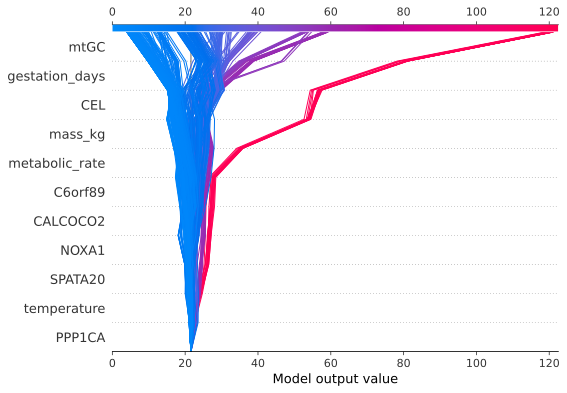

In [109]:
lifespan_results_his.plot_decision(save=locations.output.plots / "stage_3" / "life_history" / "stage_3_lh_decision.svg")

min_max dataset values: (3.3, 122.5)


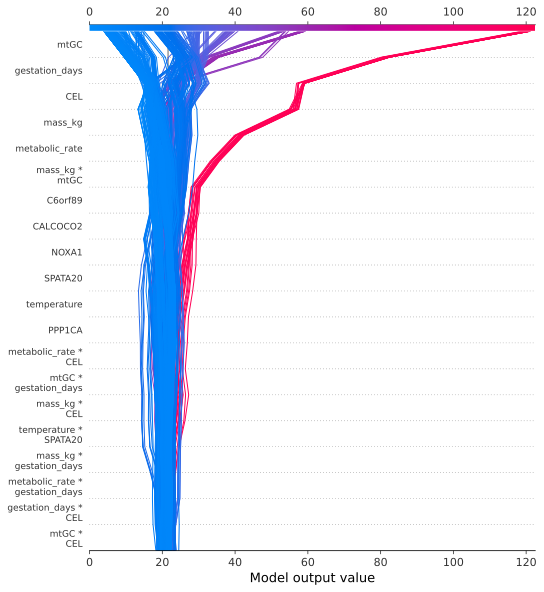

In [363]:
lifespan_results_his_2.plot_interaction_decision(save=locations.output.plots / "stage_3" / "life_history" / "stage_3_lh_decision.svg")

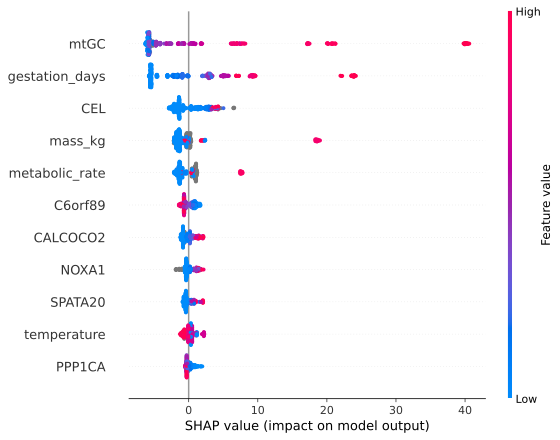

In [110]:
lifespan_results_his.plot(save=locations.output.plots / "stage_3" / "life_history" / "stage_3_lh_summary.svg")

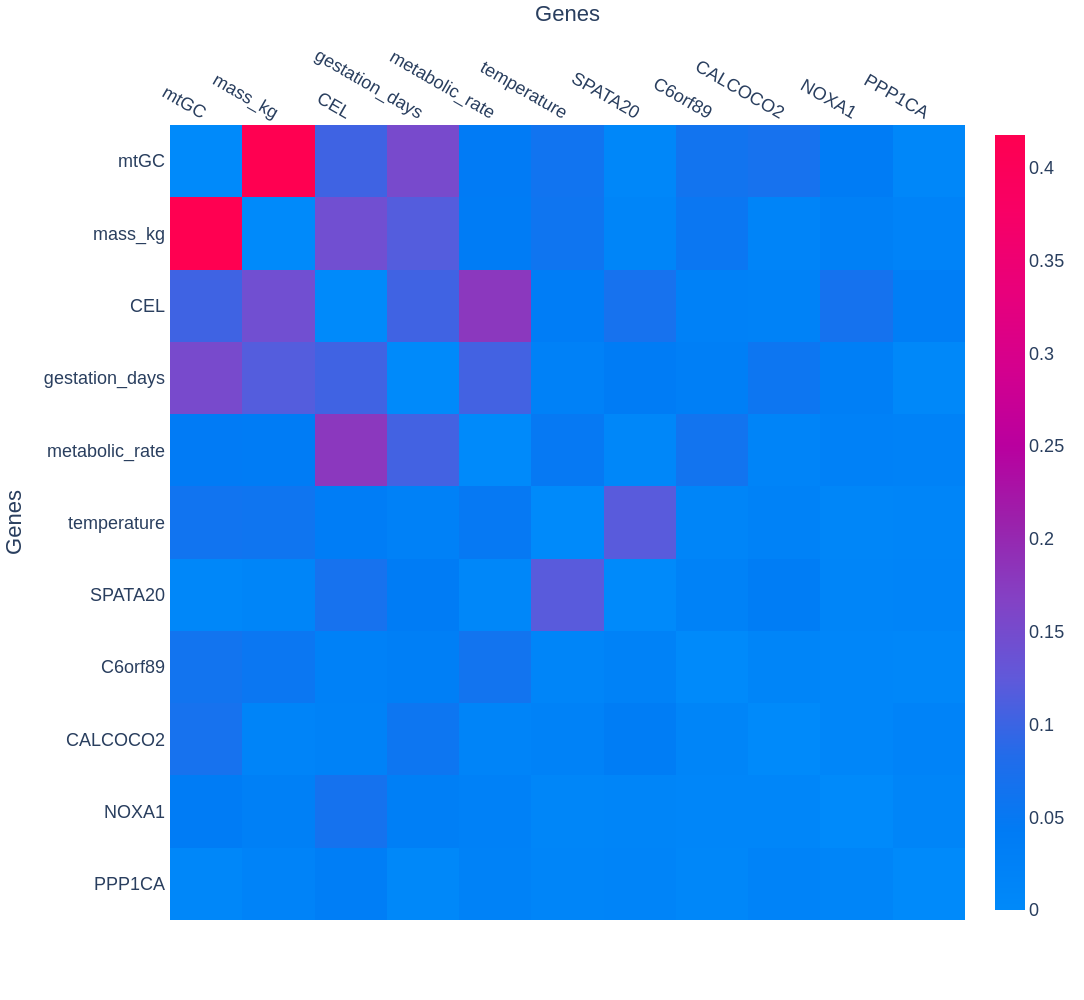

In [162]:
lifespan_results_his.plot_interactions(height=1000, width=1090, max=15, title="", axis_title="Genes")

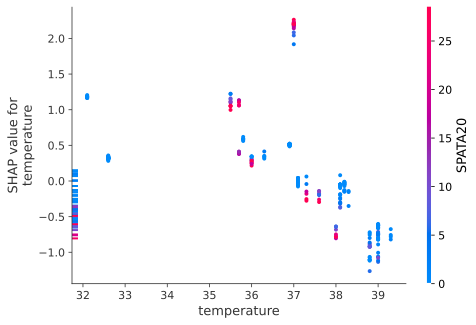

In [164]:
lifespan_results_his.plot_dependency("temperature", "SPATA20", save=locations.output.plots / "stage_3" / "life_history"/ "interactions" / "temperature_SPATA20.svg")

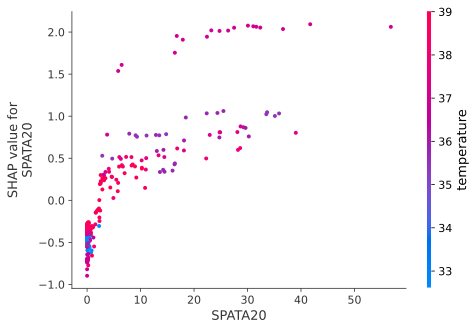

In [165]:
lifespan_results_his.plot_dependency("SPATA20", "temperature", save=locations.output.plots / "stage_3" / "life_history"/ "interactions" / "SPATA20_temperature.svg")

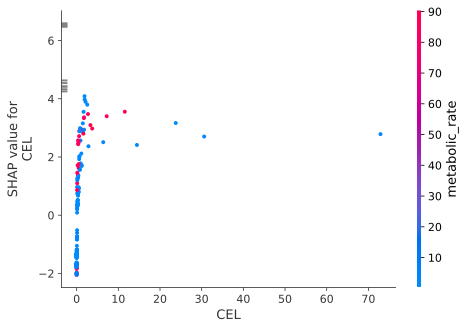

In [166]:
lifespan_results_his.plot_dependency("CEL", "metabolic_rate", save=locations.output.plots / "stage_3" / "life_history"/ "interactions" / "CEL_metabolic_rate.svg")

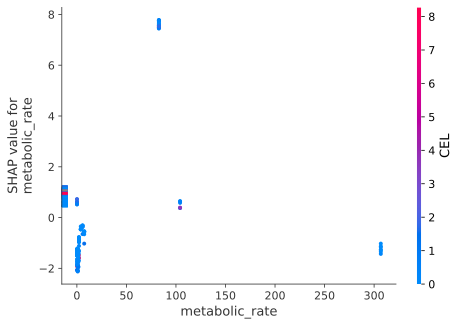

In [167]:
lifespan_results_his.plot_dependency("metabolic_rate","CEL", save=locations.output.plots / "stage_3" / "life_history"/ "interactions" / "metabolic_rate_CEL.svg")